In [114]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

In [115]:
# 确定random seed
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [116]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'

prefix = Path(data_dir).absolute() / dataset_name

In [117]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [118]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


In [119]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # 将全型字变为半型字
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)

def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])         # 去掉() []
        s = s.replace('-', '') # remove '-'                        # 去掉-
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation # 用\1代表所有标点符号
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])        # 去掉() []
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')                                    # 去掉 tab “ — _
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation # 用\1代表所有标点符号
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:  # 两个句子的比值大于ratio也要清洗掉
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [120]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [121]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [122]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


In [123]:
# Subword Units

# 在机器翻译中 out of vocabulary (OOV)是主要问题 需要使用subword units
# 使用sentencepiece库进行分割

import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [124]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/wy/ML_study/chapter5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [125]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


In [126]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


In [127]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/rnn",
    source_lang = "en",
    target_lang = "zh",

    # cpu threads when fetching & processing data.
    num_workers=2,
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,

    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,

    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,

    # maximum epochs for training
    max_epoch=200,
    start_epoch=1,

    # beam size for beam search
    beam=5,
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2,
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",

    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)

    # logging
    use_wandb=False,
)

In [128]:
# Logging
# logging package logs ordinary messages
# wandb logs the loss, bleu, etc. in the training process

logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.transformer"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

In [129]:

# CUDA

cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

2021-11-13 09:29:47 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-11-13 09:29:47 | INFO | fairseq.utils | rank   0: capabilities =  8.6  ; total memory = 23.700 GB ; name = NVIDIA GeForce RTX 3090                 
2021-11-13 09:29:47 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


In [130]:
# Data Loading

## We borrow the TranslationTask from fairseq
# used to load the binarized data created above
# well-implemented data iterator (dataloader)
# built-in task.source_dictionary and task.target_dictionary are also handy
# well-implemented beach search decoder

from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-11-13 09:29:47 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-11-13 09:29:47 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [131]:

logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-11-13 09:29:47 | INFO | hw5.transformer | loading data for epoch 1
2021-11-13 09:29:47 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-11-13 09:29:47 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-11-13 09:29:47 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2021-11-13 09:29:47 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-11-13 09:29:47 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-11-13 09:29:47 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [132]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2234,   60,   19,   80,    5,  256,   16,  405, 1407,
        1706,    7,    2]),
 'target': tensor([ 140,  690,   28,  270,   45,  151, 1142,  660,  606,  369, 3114, 2434,
        1434,  192,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


In [133]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond
        # first call of this method has no effect.
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-11-13 09:29:47 | WARNING | fairseq.tasks.fairseq_task | 2,532 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 135, 2444, 3058, 682, 731, 235, 1558, 3383, 559]


{'id': tensor([723]),
 'nsentences': 1,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,   18,   26,   82,    8,  480,   15,  651,
           1361,   38,    6,  176, 2696,   39,    5,  822,   92,  260,    7,    2]]),
  'src_lengths': tensor([19]),
  'prev_output_tokens': tensor([[   2,  140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,
            151, 2691,    9,  215, 1680,   10,    1,    1,    1,    1,    1,    1]])},
 'target': tensor([[ 140,  296,  318, 1560,   51,  568,  316,  225, 1952,  254,   78,  151,
          2691,    9,  215, 1680,   10,    2,    1,    1,    1,    1,    1,    1]])}

In [134]:
from fairseq.models import (
    FairseqEncoder,
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

In [135]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args

    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

In [136]:
from fairseq.models.transformer import (
    TransformerEncoder,
    TransformerDecoder,
)
def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())

    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)

    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)

    # weight initialization
    model.apply(init_params)
    return model

In [137]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=1,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=1,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)
# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    args.encoder_layers = 4

    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    args.decoder_layers = 4

    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024

    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [138]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [139]:
model = build_model(arch_args, task)
logger.info(model)

2021-11-13 09:29:49 | INFO | hw5.transformer | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, b

In [140]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce

    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

In [141]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    @property
    def param_groups(self):
        return self.optimizer.param_groups

    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

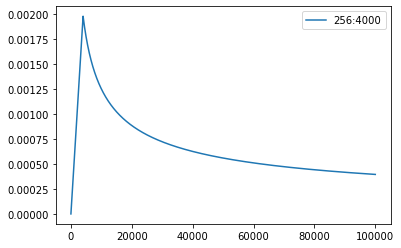

In [142]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim,
    factor=config.lr_factor,
    warmup=config.lr_warmup,
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

In [143]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次

    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp)

    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i

            # 混和精度訓練
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))

                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸

        scaler.step(optimizer)
        scaler.update()

        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })

    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

In [144]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()),
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()),
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [145]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)

            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)

    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs

    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)

    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])

    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

In [146]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)

        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"_transformer_checkpoint{epoch}.pt")
        shutil.copy(savedir/f"_transformer_checkpoint{epoch}.pt", savedir/f"_transformer_checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/_transformer_checkpoint{epoch}.pt")

        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"_transformer_checkpoint_best.pt")

        del_file = savedir / f"_transformer_checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()

    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "_transformer_checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

In [147]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [148]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-11-13 09:29:50 | INFO | hw5.transformer | task: TranslationTask
2021-11-13 09:29:50 | INFO | hw5.transformer | encoder: TransformerEncoder
2021-11-13 09:29:50 | INFO | hw5.transformer | decoder: TransformerDecoder
2021-11-13 09:29:50 | INFO | hw5.transformer | criterion: LabelSmoothedCrossEntropyCriterion
2021-11-13 09:29:50 | INFO | hw5.transformer | optimizer: NoamOpt
2021-11-13 09:29:50 | INFO | hw5.transformer | num. model params: 10,419,200 (num. trained: 10,419,200)
2021-11-13 09:29:50 | INFO | hw5.transformer | max tokens per batch = 8192, accumulate steps = 2


In [149]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)


2021-11-13 09:29:50 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-11-13 09:29:50 | INFO | hw5.transformer | loaded checkpoint checkpoints/rnn/_transformer_checkpoint_last.pt: step=23395 loss=3.5280888080596924 bleu=22.900005908979022


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc8297941f0><function _MultiProcessingDataLoaderIter.__del__ at 0x7fc8297941f0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
      File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/home/wy/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive

  File "/home/wy/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
      

2021-11-13 09:31:55 | INFO | hw5.transformer | training loss: 3.6142
2021-11-13 09:31:55 | INFO | hw5.transformer | begin validation


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc8297941f0>
Traceback (most recent call last):
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/wy/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/home/wy/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


2021-11-13 09:32:14 | INFO | hw5.transformer | example source: but the point is , it doesn't feel that way .
2021-11-13 09:32:14 | INFO | hw5.transformer | example hypothesis: 但重點是 , 感覺並不那樣 。
2021-11-13 09:32:14 | INFO | hw5.transformer | example reference: 但重點是 , 感覺起來卻不是那麼回事呀
2021-11-13 09:32:14 | INFO | hw5.transformer | validation loss:	3.5326
2021-11-13 09:32:14 | INFO | hw5.transformer | BLEU = 23.00 58.5/32.4/18.8/11.4 (BP = 0.910 ratio = 0.914 hyp_len = 102154 ref_len = 111811)
2021-11-13 09:32:14 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint1.pt
2021-11-13 09:32:15 | INFO | hw5.transformer | end of epoch 1


2021-11-13 09:34:22 | INFO | hw5.transformer | training loss: 3.6068
2021-11-13 09:34:22 | INFO | hw5.transformer | begin validation


2021-11-13 09:34:40 | INFO | hw5.transformer | example source: we can push through that .
2021-11-13 09:34:40 | INFO | hw5.transformer | example hypothesis: 我們可以這樣推動 。
2021-11-13 09:34:40 | INFO | hw5.transformer | example reference: 我們可以衝破這些限制 。
2021-11-13 09:34:40 | INFO | hw5.transformer | validation loss:	3.5299
2021-11-13 09:34:40 | INFO | hw5.transformer | BLEU = 22.91 58.6/32.5/18.8/11.4 (BP = 0.907 ratio = 0.911 hyp_len = 101840 ref_len = 111811)
2021-11-13 09:34:40 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint2.pt
2021-11-13 09:34:40 | INFO | hw5.transformer | end of epoch 2


2021-11-13 09:36:45 | INFO | hw5.transformer | training loss: 3.6033
2021-11-13 09:36:45 | INFO | hw5.transformer | begin validation


2021-11-13 09:37:04 | INFO | hw5.transformer | example source: thank you .
2021-11-13 09:37:04 | INFO | hw5.transformer | example hypothesis: 謝謝 。
2021-11-13 09:37:04 | INFO | hw5.transformer | example reference: 謝謝 。
2021-11-13 09:37:04 | INFO | hw5.transformer | validation loss:	3.5198
2021-11-13 09:37:04 | INFO | hw5.transformer | BLEU = 23.11 57.8/31.9/18.4/11.1 (BP = 0.932 ratio = 0.934 hyp_len = 104476 ref_len = 111811)
2021-11-13 09:37:04 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint3.pt
2021-11-13 09:37:05 | INFO | hw5.transformer | end of epoch 3


2021-11-13 09:39:11 | INFO | hw5.transformer | training loss: 3.5970
2021-11-13 09:39:11 | INFO | hw5.transformer | begin validation


2021-11-13 09:39:31 | INFO | hw5.transformer | example source: those men would eventually be convicted of placing a van filled with 1 , 500 pounds of explosives into the sublevel parking lot of the world trade center's north tower , causing an explosion that killed six people and injured over 1 , 000 others .
2021-11-13 09:39:31 | INFO | hw5.transformer | example hypothesis: 這些人最終會被定罪 , 把一台車裝滿了一千五百磅的爆炸 , 進入了世界各地的貿易中心 , 造成六個人的爆炸 , 傷害了超過一千人 。
2021-11-13 09:39:31 | INFO | hw5.transformer | example reference: 這群男人最終被指控將滿載1500磅重的炸彈的廂式貨車停在世界貿易中心北塔的地下停車場 , 爆炸造成6人死亡 , 同時致使超過1000人受傷 。
2021-11-13 09:39:31 | INFO | hw5.transformer | validation loss:	3.5161
2021-11-13 09:39:31 | INFO | hw5.transformer | BLEU = 23.26 57.7/31.8/18.4/11.2 (BP = 0.938 ratio = 0.940 hyp_len = 105111 ref_len = 111811)
2021-11-13 09:39:31 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint4.pt
2021-11-13 09:39:32 | INFO | hw5.transformer | end of epoch 4


2021-11-13 09:41:38 | INFO | hw5.transformer | training loss: 3.5878
2021-11-13 09:41:38 | INFO | hw5.transformer | begin validation


2021-11-13 09:41:57 | INFO | hw5.transformer | example source: but this is really how i go about creating these photographs .
2021-11-13 09:41:57 | INFO | hw5.transformer | example hypothesis: 但這真的是我要如何創造這些照片 。
2021-11-13 09:41:57 | INFO | hw5.transformer | example reference: 但是我真的是這樣做出這些相片的 。
2021-11-13 09:41:57 | INFO | hw5.transformer | validation loss:	3.5150
2021-11-13 09:41:57 | INFO | hw5.transformer | BLEU = 23.52 57.1/31.4/18.2/11.0 (BP = 0.960 ratio = 0.961 hyp_len = 107459 ref_len = 111811)
2021-11-13 09:41:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint5.pt
2021-11-13 09:41:58 | INFO | hw5.transformer | end of epoch 5


2021-11-13 09:44:06 | INFO | hw5.transformer | training loss: 3.5832
2021-11-13 09:44:06 | INFO | hw5.transformer | begin validation


2021-11-13 09:44:25 | INFO | hw5.transformer | example source: so that is a fact .
2021-11-13 09:44:25 | INFO | hw5.transformer | example hypothesis: 這是事實 。
2021-11-13 09:44:25 | INFO | hw5.transformer | example reference: 這就是事實
2021-11-13 09:44:25 | INFO | hw5.transformer | validation loss:	3.5094
2021-11-13 09:44:25 | INFO | hw5.transformer | BLEU = 23.29 58.3/32.3/18.8/11.4 (BP = 0.924 ratio = 0.927 hyp_len = 103672 ref_len = 111811)
2021-11-13 09:44:25 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint6.pt
2021-11-13 09:44:25 | INFO | hw5.transformer | end of epoch 6


2021-11-13 09:46:35 | INFO | hw5.transformer | training loss: 3.5792
2021-11-13 09:46:35 | INFO | hw5.transformer | begin validation


2021-11-13 09:46:54 | INFO | hw5.transformer | example source: thank you so much everyone .
2021-11-13 09:46:54 | INFO | hw5.transformer | example hypothesis: 謝謝大家
2021-11-13 09:46:54 | INFO | hw5.transformer | example reference: 謝謝大家 !
2021-11-13 09:46:54 | INFO | hw5.transformer | validation loss:	3.5077
2021-11-13 09:46:54 | INFO | hw5.transformer | BLEU = 23.06 58.8/32.7/19.1/11.7 (BP = 0.902 ratio = 0.906 hyp_len = 101317 ref_len = 111811)
2021-11-13 09:46:54 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint7.pt
2021-11-13 09:46:54 | INFO | hw5.transformer | end of epoch 7


2021-11-13 09:49:03 | INFO | hw5.transformer | training loss: 3.5739
2021-11-13 09:49:03 | INFO | hw5.transformer | begin validation


2021-11-13 09:49:22 | INFO | hw5.transformer | example source: these differences became a source of inspired artistic celebration .
2021-11-13 09:49:22 | INFO | hw5.transformer | example hypothesis: 這些差異變成了啟發藝術的來源 。
2021-11-13 09:49:22 | INFO | hw5.transformer | example reference: 這些差異變成了一個源頭 , 富有靈感之藝術讚頌的源頭 。
2021-11-13 09:49:22 | INFO | hw5.transformer | validation loss:	3.4994
2021-11-13 09:49:22 | INFO | hw5.transformer | BLEU = 23.08 58.7/32.6/19.0/11.6 (BP = 0.907 ratio = 0.911 hyp_len = 101827 ref_len = 111811)
2021-11-13 09:49:22 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint8.pt
2021-11-13 09:49:22 | INFO | hw5.transformer | end of epoch 8


2021-11-13 09:51:32 | INFO | hw5.transformer | training loss: 3.5693
2021-11-13 09:51:32 | INFO | hw5.transformer | begin validation


2021-11-13 09:51:52 | INFO | hw5.transformer | example source: it's not .
2021-11-13 09:51:52 | INFO | hw5.transformer | example hypothesis: 不是 。
2021-11-13 09:51:52 | INFO | hw5.transformer | example reference: 不是
2021-11-13 09:51:52 | INFO | hw5.transformer | validation loss:	3.5039
2021-11-13 09:51:52 | INFO | hw5.transformer | BLEU = 23.74 56.6/31.2/18.1/11.0 (BP = 0.976 ratio = 0.976 hyp_len = 109125 ref_len = 111811)
2021-11-13 09:51:52 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint9.pt
2021-11-13 09:51:52 | INFO | hw5.transformer | end of epoch 9


2021-11-13 09:54:01 | INFO | hw5.transformer | training loss: 3.5650
2021-11-13 09:54:01 | INFO | hw5.transformer | begin validation


2021-11-13 09:54:19 | INFO | hw5.transformer | example source: so think about when you have friends , families and coworkers in california , on the west coast or in other parts of the world .
2021-11-13 09:54:19 | INFO | hw5.transformer | example hypothesis: 想想看 , 當你有朋友、家人和加州的同事 , 在西岸或世界其他地方 。
2021-11-13 09:54:19 | INFO | hw5.transformer | example reference: 所以 , 想像當你嘗試聯繫在加州 , 在西海岸或者在世界的另一面
2021-11-13 09:54:19 | INFO | hw5.transformer | validation loss:	3.4980
2021-11-13 09:54:19 | INFO | hw5.transformer | BLEU = 22.98 58.9/32.6/18.9/11.5 (BP = 0.903 ratio = 0.907 hyp_len = 101457 ref_len = 111811)
2021-11-13 09:54:19 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint10.pt
2021-11-13 09:54:19 | INFO | hw5.transformer | end of epoch 10


2021-11-13 09:56:29 | INFO | hw5.transformer | training loss: 3.5609
2021-11-13 09:56:29 | INFO | hw5.transformer | begin validation


2021-11-13 09:56:48 | INFO | hw5.transformer | example source: and i was asked to move out because one of my roommates had shared my status with her parents .
2021-11-13 09:56:48 | INFO | hw5.transformer | example hypothesis: 我被要求搬出去 , 因為我的其中一位室友和她的父母分享我的地位 。
2021-11-13 09:56:48 | INFO | hw5.transformer | example reference: 我會被要求搬出去 , 是因為其中一名室友和她的父母談了我的狀況 。
2021-11-13 09:56:48 | INFO | hw5.transformer | validation loss:	3.4988
2021-11-13 09:56:48 | INFO | hw5.transformer | BLEU = 23.45 58.3/32.3/18.8/11.5 (BP = 0.928 ratio = 0.931 hyp_len = 104053 ref_len = 111811)
2021-11-13 09:56:48 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint11.pt
2021-11-13 09:56:48 | INFO | hw5.transformer | end of epoch 11


2021-11-13 09:58:59 | INFO | hw5.transformer | training loss: 3.5585
2021-11-13 09:58:59 | INFO | hw5.transformer | begin validation


2021-11-13 09:59:18 | INFO | hw5.transformer | example source: and i want to share with you a quick video from our facility that gives you a sense of how this looks at scale .
2021-11-13 09:59:18 | INFO | hw5.transformer | example hypothesis: 我想和各位分享一段影片 , 來自我們的設備 , 可以讓你了解它的規模 。
2021-11-13 09:59:18 | INFO | hw5.transformer | example reference: 我想與你們快速分享一段關於我們設備的影片可以瞭解一下它的規模
2021-11-13 09:59:18 | INFO | hw5.transformer | validation loss:	3.4889
2021-11-13 09:59:18 | INFO | hw5.transformer | BLEU = 23.41 58.3/32.4/18.8/11.5 (BP = 0.926 ratio = 0.928 hyp_len = 103801 ref_len = 111811)
2021-11-13 09:59:18 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint12.pt
2021-11-13 09:59:18 | INFO | hw5.transformer | end of epoch 12


2021-11-13 10:01:27 | INFO | hw5.transformer | training loss: 3.5550
2021-11-13 10:01:27 | INFO | hw5.transformer | begin validation


2021-11-13 10:01:44 | INFO | hw5.transformer | example source: it's a distinction perhaps we might make between two nobel laureates , richard feynman and john nash .
2021-11-13 10:01:44 | INFO | hw5.transformer | example hypothesis: 或許我們可能在兩個諾貝爾獎得主、理查德.費曼和約翰納許許許許之間產生區別 。
2021-11-13 10:01:44 | INFO | hw5.transformer | example reference: 我們或許可以從兩位諾貝爾獎得主 , 理查費曼和約翰奈許之間看出這樣的差異 。
2021-11-13 10:01:44 | INFO | hw5.transformer | validation loss:	3.5005
2021-11-13 10:01:44 | INFO | hw5.transformer | BLEU = 23.26 58.8/32.6/18.9/11.5 (BP = 0.913 ratio = 0.917 hyp_len = 102533 ref_len = 111811)
2021-11-13 10:01:45 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint13.pt
2021-11-13 10:01:45 | INFO | hw5.transformer | end of epoch 13


2021-11-13 10:03:55 | INFO | hw5.transformer | training loss: 3.5524
2021-11-13 10:03:55 | INFO | hw5.transformer | begin validation


2021-11-13 10:04:14 | INFO | hw5.transformer | example source: and therein lie the words of wisdom of a young girl whose brief life forever impacted mine .
2021-11-13 10:04:14 | INFO | hw5.transformer | example hypothesis: 這裡有一位年輕女孩的智慧字眼 , 他的短暫生命永遠影響著我 。
2021-11-13 10:04:14 | INFO | hw5.transformer | example reference: 她說的話對我有很大啟發 。 這一個年幼女孩短暫的一生永遠影響著我 。
2021-11-13 10:04:14 | INFO | hw5.transformer | validation loss:	3.4885
2021-11-13 10:04:14 | INFO | hw5.transformer | BLEU = 23.08 59.2/33.0/19.2/11.7 (BP = 0.897 ratio = 0.902 hyp_len = 100855 ref_len = 111811)
2021-11-13 10:04:14 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint14.pt
2021-11-13 10:04:14 | INFO | hw5.transformer | end of epoch 14


2021-11-13 10:06:24 | INFO | hw5.transformer | training loss: 3.5524
2021-11-13 10:06:24 | INFO | hw5.transformer | begin validation


2021-11-13 10:06:42 | INFO | hw5.transformer | example source: and we've started making curtains , and not only is it beautiful , but people can see status that you care about your children .
2021-11-13 10:06:42 | INFO | hw5.transformer | example hypothesis: 我們開始製作曲線 , 不僅是美麗 , 還可以看到你的孩子的地位 。
2021-11-13 10:06:42 | INFO | hw5.transformer | example reference: 我們也開始生産窗簾不止因爲窗簾看起來漂亮 , 人們也可以看到你的地位看得出你很關心小孩
2021-11-13 10:06:42 | INFO | hw5.transformer | validation loss:	3.4889
2021-11-13 10:06:42 | INFO | hw5.transformer | BLEU = 23.01 59.3/33.1/19.3/11.8 (BP = 0.890 ratio = 0.895 hyp_len = 100109 ref_len = 111811)
2021-11-13 10:06:42 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint15.pt
2021-11-13 10:06:42 | INFO | hw5.transformer | end of epoch 15


2021-11-13 10:08:51 | INFO | hw5.transformer | training loss: 3.5453
2021-11-13 10:08:51 | INFO | hw5.transformer | begin validation


2021-11-13 10:09:09 | INFO | hw5.transformer | example source: now , i'm not suggesting we want to raise our babies in our stomach , but i am suggesting it's possible we might want to manage gastric secretion in the gut .
2021-11-13 10:09:09 | INFO | hw5.transformer | example hypothesis: 我並不是建議我們想要在胃裡養育嬰兒 , 但我建議 , 我們可能想在腸子裡管理氣體分泌 。
2021-11-13 10:09:09 | INFO | hw5.transformer | example reference: 我並不是說要把嬰兒養在胃裡而是我們可能可以了解胃在內臟裡的分泌物
2021-11-13 10:09:09 | INFO | hw5.transformer | validation loss:	3.4905
2021-11-13 10:09:09 | INFO | hw5.transformer | BLEU = 23.55 58.1/32.3/18.7/11.4 (BP = 0.937 ratio = 0.939 hyp_len = 104968 ref_len = 111811)
2021-11-13 10:09:09 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint16.pt
2021-11-13 10:09:09 | INFO | hw5.transformer | end of epoch 16


2021-11-13 10:11:20 | INFO | hw5.transformer | training loss: 3.5447
2021-11-13 10:11:20 | INFO | hw5.transformer | begin validation


2021-11-13 10:11:39 | INFO | hw5.transformer | example source: so we're hoping that's what they'll do .
2021-11-13 10:11:39 | INFO | hw5.transformer | example hypothesis: 所以 , 我們希望他們會這樣做 。
2021-11-13 10:11:39 | INFO | hw5.transformer | example reference: 所以 , 我們希望它們能夠幫忙 。
2021-11-13 10:11:39 | INFO | hw5.transformer | validation loss:	3.4799
2021-11-13 10:11:39 | INFO | hw5.transformer | BLEU = 23.68 58.3/32.5/19.0/11.6 (BP = 0.931 ratio = 0.934 hyp_len = 104400 ref_len = 111811)
2021-11-13 10:11:39 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint17.pt
2021-11-13 10:11:39 | INFO | hw5.transformer | end of epoch 17


2021-11-13 10:13:49 | INFO | hw5.transformer | training loss: 3.5404
2021-11-13 10:13:49 | INFO | hw5.transformer | begin validation


2021-11-13 10:14:09 | INFO | hw5.transformer | example source: i remember so vividly that day .
2021-11-13 10:14:09 | INFO | hw5.transformer | example hypothesis: 我記得那天很活躍 。
2021-11-13 10:14:09 | INFO | hw5.transformer | example reference: 我對那一天還記憶猶新 。
2021-11-13 10:14:09 | INFO | hw5.transformer | validation loss:	3.4826
2021-11-13 10:14:09 | INFO | hw5.transformer | BLEU = 23.48 58.1/32.3/18.8/11.4 (BP = 0.932 ratio = 0.934 hyp_len = 104411 ref_len = 111811)
2021-11-13 10:14:09 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint18.pt
2021-11-13 10:14:09 | INFO | hw5.transformer | end of epoch 18


2021-11-13 10:16:20 | INFO | hw5.transformer | training loss: 3.5372
2021-11-13 10:16:20 | INFO | hw5.transformer | begin validation


2021-11-13 10:16:39 | INFO | hw5.transformer | example source: the next step is to make compliant toes , and try to add spines and claws and set it for dry adhesives .
2021-11-13 10:16:39 | INFO | hw5.transformer | example hypothesis: 下一步是要製造複雜的腳趾 , 試著加上脊椎、爪子 , 並為乾燥的黏土設置 。
2021-11-13 10:16:39 | INFO | hw5.transformer | example reference: 下一步是要製造順從聽話的腳趾頭 。 然後加上刺和爪子 , 再加上乾膠 。
2021-11-13 10:16:39 | INFO | hw5.transformer | validation loss:	3.4824
2021-11-13 10:16:39 | INFO | hw5.transformer | BLEU = 23.85 57.9/32.2/18.7/11.5 (BP = 0.948 ratio = 0.949 hyp_len = 106152 ref_len = 111811)
2021-11-13 10:16:39 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint19.pt
2021-11-13 10:16:40 | INFO | hw5.transformer | end of epoch 19


2021-11-13 10:18:51 | INFO | hw5.transformer | training loss: 3.5338
2021-11-13 10:18:51 | INFO | hw5.transformer | begin validation


2021-11-13 10:19:10 | INFO | hw5.transformer | example source: and got the cord off of the baby's neck , and a healthy screaming , kicking baby arrived , just as the dad ran in from the parking lot , " hi , you have a son , i'm dr . darria .
2021-11-13 10:19:10 | INFO | hw5.transformer | example hypothesis: 拿到嬰兒脖子的角落 , 健康的尖叫 , 凱克·貝到來 , 就像爸爸從停車場跑來的一樣 , 「 嗨 , 你有兒子 , 我是達里亞博士 。
2021-11-13 10:19:10 | INFO | hw5.transformer | example reference: 我把臍帶從嬰兒的脖子繞開 , 接著 , 一個健康哭鬧的嬰兒誕生了 。 同時 , 他的父親剛從停車場趕來 。 「 你好 , 是一個男孩 。 我是達里亞醫生 。
2021-11-13 10:19:10 | INFO | hw5.transformer | validation loss:	3.4801
2021-11-13 10:19:10 | INFO | hw5.transformer | BLEU = 23.68 58.6/32.7/19.0/11.7 (BP = 0.927 ratio = 0.929 hyp_len = 103914 ref_len = 111811)
2021-11-13 10:19:10 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint20.pt
2021-11-13 10:19:10 | INFO | hw5.transformer | end of epoch 20


2021-11-13 10:21:20 | INFO | hw5.transformer | training loss: 3.5349
2021-11-13 10:21:20 | INFO | hw5.transformer | begin validation


2021-11-13 10:21:39 | INFO | hw5.transformer | example source: no , but the issue of city building in democracy is interesting because it creates chaos , right ?
2021-11-13 10:21:39 | INFO | hw5.transformer | example hypothesis: 不 , 但民主的城市建築問題很有趣 , 因為它創造混亂 , 對吧 ?
2021-11-13 10:21:39 | INFO | hw5.transformer | example reference: 不 , 但民主的城市建設很有趣 , 因為會造成混亂 , 是嗎 ?
2021-11-13 10:21:39 | INFO | hw5.transformer | validation loss:	3.4756
2021-11-13 10:21:39 | INFO | hw5.transformer | BLEU = 23.76 58.3/32.5/19.0/11.6 (BP = 0.934 ratio = 0.936 hyp_len = 104686 ref_len = 111811)
2021-11-13 10:21:39 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint21.pt
2021-11-13 10:21:39 | INFO | hw5.transformer | end of epoch 21


2021-11-13 10:23:48 | INFO | hw5.transformer | training loss: 3.5278
2021-11-13 10:23:48 | INFO | hw5.transformer | begin validation


2021-11-13 10:24:07 | INFO | hw5.transformer | example source: so i'm going to show you a demo of this .
2021-11-13 10:24:07 | INFO | hw5.transformer | example hypothesis: 我要給你們看一個關於這個的示範 。
2021-11-13 10:24:07 | INFO | hw5.transformer | example reference: 現在請各位看示範
2021-11-13 10:24:07 | INFO | hw5.transformer | validation loss:	3.4824
2021-11-13 10:24:07 | INFO | hw5.transformer | BLEU = 23.55 58.8/32.9/19.1/11.7 (BP = 0.918 ratio = 0.922 hyp_len = 103048 ref_len = 111811)
2021-11-13 10:24:07 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint22.pt
2021-11-13 10:24:07 | INFO | hw5.transformer | end of epoch 22


2021-11-13 10:26:18 | INFO | hw5.transformer | training loss: 3.5269
2021-11-13 10:26:18 | INFO | hw5.transformer | begin validation


2021-11-13 10:26:37 | INFO | hw5.transformer | example source: you see , in every country where you hear about armed jihadis targeting civilians , there are also unarmed people defying those militants that you don't hear about , and those people need our support to succeed .
2021-11-13 10:26:37 | INFO | hw5.transformer | example hypothesis: 你看 , 在每一個你聽過武裝聖戰的國家中 , 也有一些不受傷的人 , 那些你聽不到的軍隊 , 而那些人需要我們的支持才能成功 。
2021-11-13 10:26:37 | INFO | hw5.transformer | example reference: 你看 , 不管在哪個國家你都會聽到武裝聖戰者針對平民百姓 , 也有很多手無寸鐵的人民公然反抗那些激進分子 , 只是你沒聽過 , 那些人需要我們的支持才能成功 。
2021-11-13 10:26:37 | INFO | hw5.transformer | validation loss:	3.4767
2021-11-13 10:26:37 | INFO | hw5.transformer | BLEU = 23.46 59.0/32.8/19.1/11.7 (BP = 0.914 ratio = 0.918 hyp_len = 102633 ref_len = 111811)
2021-11-13 10:26:37 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint23.pt
2021-11-13 10:26:37 | INFO | hw5.transformer | end of epoch 23


2021-11-13 10:28:47 | INFO | hw5.transformer | training loss: 3.5230
2021-11-13 10:28:47 | INFO | hw5.transformer | begin validation


2021-11-13 10:29:05 | INFO | hw5.transformer | example source: from gezi to tahrir to elsewhere , i've seen people put their lives and livelihoods on the line .
2021-11-13 10:29:05 | INFO | hw5.transformer | example hypothesis: 從gezi到tahrir到其他地方 , 我看到人們把他們的生活和生活放在線上 。
2021-11-13 10:29:05 | INFO | hw5.transformer | example reference: 從格濟公園 , 到解放廣場 , 再到其它地方 , 我見過許多人用他們的生命和生計做賭注 。
2021-11-13 10:29:05 | INFO | hw5.transformer | validation loss:	3.4785
2021-11-13 10:29:05 | INFO | hw5.transformer | BLEU = 23.55 58.9/32.9/19.2/11.8 (BP = 0.915 ratio = 0.919 hyp_len = 102731 ref_len = 111811)
2021-11-13 10:29:06 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint24.pt
2021-11-13 10:29:06 | INFO | hw5.transformer | end of epoch 24


2021-11-13 10:31:12 | INFO | hw5.transformer | training loss: 3.5231
2021-11-13 10:31:12 | INFO | hw5.transformer | begin validation


2021-11-13 10:31:30 | INFO | hw5.transformer | example source: and every project before that had been completely personal and it was a revelation when people just started commenting , started giving feedback on your code .
2021-11-13 10:31:30 | INFO | hw5.transformer | example hypothesis: 在這之前 , 每個專案都完全個人化 , 大家開始評論之前 , 開始對你的程式做出回饋 。
2021-11-13 10:31:30 | INFO | hw5.transformer | example reference: 在那之前每一件計劃都是我個人的東西 , 所以當大家開始評論 , 開始對你的程式給意見時 , 真的是一種啟示 。
2021-11-13 10:31:30 | INFO | hw5.transformer | validation loss:	3.4713
2021-11-13 10:31:30 | INFO | hw5.transformer | BLEU = 23.90 58.2/32.5/19.0/11.6 (BP = 0.940 ratio = 0.942 hyp_len = 105346 ref_len = 111811)
2021-11-13 10:31:30 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint25.pt
2021-11-13 10:31:31 | INFO | hw5.transformer | end of epoch 25


2021-11-13 10:33:36 | INFO | hw5.transformer | training loss: 3.5220
2021-11-13 10:33:36 | INFO | hw5.transformer | begin validation


2021-11-13 10:33:55 | INFO | hw5.transformer | example source: thank you so much .
2021-11-13 10:33:55 | INFO | hw5.transformer | example hypothesis: 謝謝大家 。
2021-11-13 10:33:55 | INFO | hw5.transformer | example reference: 感謝各位.
2021-11-13 10:33:55 | INFO | hw5.transformer | validation loss:	3.4770
2021-11-13 10:33:55 | INFO | hw5.transformer | BLEU = 23.21 59.7/33.5/19.5/12.0 (BP = 0.886 ratio = 0.892 hyp_len = 99763 ref_len = 111811)
2021-11-13 10:33:56 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint26.pt
2021-11-13 10:33:56 | INFO | hw5.transformer | end of epoch 26


2021-11-13 10:36:02 | INFO | hw5.transformer | training loss: 3.5203
2021-11-13 10:36:02 | INFO | hw5.transformer | begin validation


2021-11-13 10:36:21 | INFO | hw5.transformer | example source: at the age of six months , virtually every one of us is able to differentiate between animate and inanimate objects .
2021-11-13 10:36:21 | INFO | hw5.transformer | example hypothesis: 在六個月之內 , 幾乎我們每一個人都能夠分辨出動畫和非凡物體之間 。
2021-11-13 10:36:21 | INFO | hw5.transformer | example reference: 在六個月大時 , 幾乎每個人都能辨別東西是否有生命 。
2021-11-13 10:36:21 | INFO | hw5.transformer | validation loss:	3.4770
2021-11-13 10:36:21 | INFO | hw5.transformer | BLEU = 23.65 59.1/33.1/19.3/11.8 (BP = 0.915 ratio = 0.918 hyp_len = 102689 ref_len = 111811)
2021-11-13 10:36:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint27.pt
2021-11-13 10:36:21 | INFO | hw5.transformer | end of epoch 27


2021-11-13 10:38:28 | INFO | hw5.transformer | training loss: 3.5154
2021-11-13 10:38:28 | INFO | hw5.transformer | begin validation


2021-11-13 10:38:47 | INFO | hw5.transformer | example source: the problem is there is no such thing as a viable democracy made up of experts , zealots , politicians and spectators .
2021-11-13 10:38:47 | INFO | hw5.transformer | example hypothesis: 問題是 , 身為一個可行的民主是由專家、zealots、政治人物和光譜家組成的 。
2021-11-13 10:38:47 | INFO | hw5.transformer | example reference: 事實上 , 根本沒有一種民主制度是由專家 , 狂熱分子 , 政治家和旁觀者組成的
2021-11-13 10:38:47 | INFO | hw5.transformer | validation loss:	3.4641
2021-11-13 10:38:47 | INFO | hw5.transformer | BLEU = 23.92 58.1/32.3/18.7/11.4 (BP = 0.949 ratio = 0.951 hyp_len = 106301 ref_len = 111811)
2021-11-13 10:38:48 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint28.pt
2021-11-13 10:38:48 | INFO | hw5.transformer | end of epoch 28


2021-11-13 10:40:57 | INFO | hw5.transformer | training loss: 3.5143
2021-11-13 10:40:57 | INFO | hw5.transformer | begin validation


2021-11-13 10:41:16 | INFO | hw5.transformer | example source: they're learning our culture , our language , our heritage and realizing we're just as different and just the same as each other .
2021-11-13 10:41:16 | INFO | hw5.transformer | example hypothesis: 他們在學習我們的文化、我們的語言、我們的遺產 , 並意識到我們和彼此相同 。
2021-11-13 10:41:16 | INFO | hw5.transformer | example reference: 他們正在習知我們的文化、語言、傳統 , 並意識到彼此不同及相同之處 。
2021-11-13 10:41:16 | INFO | hw5.transformer | validation loss:	3.4637
2021-11-13 10:41:16 | INFO | hw5.transformer | BLEU = 23.88 58.7/32.8/19.2/11.8 (BP = 0.930 ratio = 0.932 hyp_len = 104196 ref_len = 111811)
2021-11-13 10:41:16 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint29.pt
2021-11-13 10:41:16 | INFO | hw5.transformer | end of epoch 29


2021-11-13 10:43:24 | INFO | hw5.transformer | training loss: 3.5125
2021-11-13 10:43:24 | INFO | hw5.transformer | begin validation


2021-11-13 10:43:42 | INFO | hw5.transformer | example source: but did you know that only two percent of that funding went to rebuild haitian public institutions , including its health sector ?
2021-11-13 10:43:42 | INFO | hw5.transformer | example hypothesis: 但你知道只有百分之二的資金去重建海地公共機構 , 包括它的健康部門 ?
2021-11-13 10:43:43 | INFO | hw5.transformer | example reference: 但你知不知道國際社會捐款中只有2%用去重建海地的公共體制 , 包括衞生部門 ?
2021-11-13 10:43:43 | INFO | hw5.transformer | validation loss:	3.4649
2021-11-13 10:43:43 | INFO | hw5.transformer | BLEU = 23.61 58.9/32.8/19.1/11.6 (BP = 0.923 ratio = 0.926 hyp_len = 103524 ref_len = 111811)
2021-11-13 10:43:43 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint30.pt
2021-11-13 10:43:43 | INFO | hw5.transformer | end of epoch 30


2021-11-13 10:45:51 | INFO | hw5.transformer | training loss: 3.5152
2021-11-13 10:45:51 | INFO | hw5.transformer | begin validation


2021-11-13 10:46:11 | INFO | hw5.transformer | example source: thank you .
2021-11-13 10:46:11 | INFO | hw5.transformer | example hypothesis: 謝謝
2021-11-13 10:46:11 | INFO | hw5.transformer | example reference: 謝謝 。
2021-11-13 10:46:11 | INFO | hw5.transformer | validation loss:	3.4654
2021-11-13 10:46:11 | INFO | hw5.transformer | BLEU = 23.78 58.6/32.7/19.1/11.7 (BP = 0.930 ratio = 0.932 hyp_len = 104257 ref_len = 111811)
2021-11-13 10:46:11 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint31.pt
2021-11-13 10:46:11 | INFO | hw5.transformer | end of epoch 31


2021-11-13 10:48:15 | INFO | hw5.transformer | training loss: 3.5151
2021-11-13 10:48:15 | INFO | hw5.transformer | begin validation


2021-11-13 10:48:35 | INFO | hw5.transformer | example source: and i think the answer is a lot of different people are going to have to do a lot of different things .
2021-11-13 10:48:35 | INFO | hw5.transformer | example hypothesis: 我想答案是很多不同的人都必須做很多不同的事
2021-11-13 10:48:35 | INFO | hw5.transformer | example reference: 我的回答是 , 我們所有人各盡其責 。
2021-11-13 10:48:35 | INFO | hw5.transformer | validation loss:	3.4648
2021-11-13 10:48:35 | INFO | hw5.transformer | BLEU = 23.96 58.3/32.6/19.0/11.6 (BP = 0.941 ratio = 0.943 hyp_len = 105420 ref_len = 111811)
2021-11-13 10:48:35 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint32.pt
2021-11-13 10:48:35 | INFO | hw5.transformer | end of epoch 32


2021-11-13 10:50:44 | INFO | hw5.transformer | training loss: 3.5129
2021-11-13 10:50:44 | INFO | hw5.transformer | begin validation


2021-11-13 10:51:04 | INFO | hw5.transformer | example source: that ambition that had allowed him to laboriously educate himself by himself , to go through that string of political failures and the darkest days of the war .
2021-11-13 10:51:04 | INFO | hw5.transformer | example hypothesis: 這樣的野心讓他自己被自己教育 , 去經歷那串政治失敗 , 以及戰爭最黑暗的日子 。
2021-11-13 10:51:04 | INFO | hw5.transformer | example reference: 這樣的企圖心策勵他辛辛苦苦不懈的自我教育 , 鼓舞著他面對一連串的政壇失意及堅強走過戰爭時最黑暗的歲月.
2021-11-13 10:51:04 | INFO | hw5.transformer | validation loss:	3.4630
2021-11-13 10:51:04 | INFO | hw5.transformer | BLEU = 23.52 59.4/33.2/19.4/11.9 (BP = 0.906 ratio = 0.910 hyp_len = 101758 ref_len = 111811)
2021-11-13 10:51:05 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint33.pt
2021-11-13 10:51:05 | INFO | hw5.transformer | end of epoch 33


2021-11-13 10:53:13 | INFO | hw5.transformer | training loss: 3.5108
2021-11-13 10:53:13 | INFO | hw5.transformer | begin validation


2021-11-13 10:53:33 | INFO | hw5.transformer | example source: this response has evolved from the physiological mechanism designed to make sure we can survive in a crisis .
2021-11-13 10:53:33 | INFO | hw5.transformer | example hypothesis: 這種反應從生理機制演化出來 , 來確保我們能生存在危機中 。
2021-11-13 10:53:33 | INFO | hw5.transformer | example reference: 這是心理機制進化的反應 , 目的是使我們能夠應付危機 , 生存下來 。
2021-11-13 10:53:33 | INFO | hw5.transformer | validation loss:	3.4560
2021-11-13 10:53:33 | INFO | hw5.transformer | BLEU = 24.16 57.9/32.3/18.8/11.5 (BP = 0.958 ratio = 0.959 hyp_len = 107191 ref_len = 111811)
2021-11-13 10:53:33 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint34.pt
2021-11-13 10:53:34 | INFO | hw5.transformer | end of epoch 34


2021-11-13 10:55:39 | INFO | hw5.transformer | training loss: 3.5100
2021-11-13 10:55:39 | INFO | hw5.transformer | begin validation


2021-11-13 10:55:58 | INFO | hw5.transformer | example source: see that chair there ? the orange one ? that's the organic chair . 1940 .
2021-11-13 10:55:58 | INFO | hw5.transformer | example hypothesis: 看到那張椅子嗎 ? 橘色1 ? 那是1940年有機椅子 。
2021-11-13 10:55:58 | INFO | hw5.transformer | example reference: 看見那張椅子嗎 ? 橘黃色那個 ? 這是有機椅子 。 一九四零年 。
2021-11-13 10:55:58 | INFO | hw5.transformer | validation loss:	3.4529
2021-11-13 10:55:58 | INFO | hw5.transformer | BLEU = 24.15 57.5/32.0/18.6/11.4 (BP = 0.967 ratio = 0.967 hyp_len = 108129 ref_len = 111811)
2021-11-13 10:55:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint35.pt
2021-11-13 10:55:59 | INFO | hw5.transformer | end of epoch 35


2021-11-13 10:58:08 | INFO | hw5.transformer | training loss: 3.5084
2021-11-13 10:58:08 | INFO | hw5.transformer | begin validation


2021-11-13 10:58:27 | INFO | hw5.transformer | example source: do they go from one side of the pacific to the other ?
2021-11-13 10:58:27 | INFO | hw5.transformer | example hypothesis: 他們是不是從太平洋的一邊走到另一邊 ?
2021-11-13 10:58:27 | INFO | hw5.transformer | example reference: 牠們會從太平洋的一端游到另一端嗎 ?
2021-11-13 10:58:27 | INFO | hw5.transformer | validation loss:	3.4465
2021-11-13 10:58:27 | INFO | hw5.transformer | BLEU = 23.88 58.4/32.6/19.1/11.7 (BP = 0.935 ratio = 0.937 hyp_len = 104753 ref_len = 111811)
2021-11-13 10:58:27 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint36.pt
2021-11-13 10:58:27 | INFO | hw5.transformer | end of epoch 36


2021-11-13 11:00:35 | INFO | hw5.transformer | training loss: 3.5042
2021-11-13 11:00:35 | INFO | hw5.transformer | begin validation


2021-11-13 11:00:54 | INFO | hw5.transformer | example source: i do , in any case .
2021-11-13 11:00:54 | INFO | hw5.transformer | example hypothesis: 在任何情況下 , 我都會這麼做 。
2021-11-13 11:00:54 | INFO | hw5.transformer | example reference: 無論如何我也認同 。
2021-11-13 11:00:54 | INFO | hw5.transformer | validation loss:	3.4572
2021-11-13 11:00:54 | INFO | hw5.transformer | BLEU = 23.77 58.4/32.6/19.0/11.6 (BP = 0.935 ratio = 0.937 hyp_len = 104797 ref_len = 111811)
2021-11-13 11:00:54 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint37.pt
2021-11-13 11:00:54 | INFO | hw5.transformer | end of epoch 37


2021-11-13 11:03:00 | INFO | hw5.transformer | training loss: 3.5002
2021-11-13 11:03:00 | INFO | hw5.transformer | begin validation


2021-11-13 11:03:19 | INFO | hw5.transformer | example source: and as you think about that experience , i want you to ask yourself: how might that experience of being a privileged player in a rigged game change the way you think about yourself and regard that other player ?
2021-11-13 11:03:19 | INFO | hw5.transformer | example hypothesis: 想想這段經驗 , 我想請各位問自己 , 身為一個有特權的玩家的體驗如何改變你對自己的想法 , 並認同其他玩家的感受 ?
2021-11-13 11:03:19 | INFO | hw5.transformer | example reference: 當你這麼想像時也請自問在這被動手腳的遊戲中作為佔上風的玩家會如何改變對自己和其他玩家的看法呢 ?
2021-11-13 11:03:19 | INFO | hw5.transformer | validation loss:	3.4586
2021-11-13 11:03:19 | INFO | hw5.transformer | BLEU = 23.78 58.6/32.7/19.1/11.7 (BP = 0.929 ratio = 0.932 hyp_len = 104162 ref_len = 111811)
2021-11-13 11:03:19 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint38.pt
2021-11-13 11:03:19 | INFO | hw5.transformer | end of epoch 38


2021-11-13 11:05:26 | INFO | hw5.transformer | training loss: 3.5012
2021-11-13 11:05:26 | INFO | hw5.transformer | begin validation


2021-11-13 11:05:45 | INFO | hw5.transformer | example source: this is a photograph i took at the northern tip of baffin island when i went narwhal hunting with some inuit people , and this man , olayuk , told me a marvelous story of his grandfather .
2021-11-13 11:05:45 | INFO | hw5.transformer | example hypothesis: 這是我在巴芬島北部拍攝的照片當我和一些鼓舞人民一起狩獵時 , 這個人 , 奧拉烏克告訴我他祖父的故事 。
2021-11-13 11:05:45 | INFO | hw5.transformer | example reference: 這張照片是我在巴芬島的北邊山頂上拍攝的那時我和一些因紐特人去捕獨角鯨這個叫奧拉雅的人述說了他祖父的傳奇故事
2021-11-13 11:05:45 | INFO | hw5.transformer | validation loss:	3.4519
2021-11-13 11:05:45 | INFO | hw5.transformer | BLEU = 23.70 59.1/33.2/19.5/11.9 (BP = 0.913 ratio = 0.916 hyp_len = 102435 ref_len = 111811)
2021-11-13 11:05:45 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint39.pt
2021-11-13 11:05:45 | INFO | hw5.transformer | end of epoch 39


2021-11-13 11:07:55 | INFO | hw5.transformer | training loss: 3.4996
2021-11-13 11:07:55 | INFO | hw5.transformer | begin validation


2021-11-13 11:08:13 | INFO | hw5.transformer | example source: congratulations .
2021-11-13 11:08:13 | INFO | hw5.transformer | example hypothesis: 恭喜 。
2021-11-13 11:08:13 | INFO | hw5.transformer | example reference: 恭喜各位 。
2021-11-13 11:08:13 | INFO | hw5.transformer | validation loss:	3.4527
2021-11-13 11:08:13 | INFO | hw5.transformer | BLEU = 23.78 59.0/33.1/19.4/11.9 (BP = 0.917 ratio = 0.920 hyp_len = 102894 ref_len = 111811)
2021-11-13 11:08:14 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint40.pt
2021-11-13 11:08:14 | INFO | hw5.transformer | end of epoch 40


2021-11-13 11:10:19 | INFO | hw5.transformer | training loss: 3.4974
2021-11-13 11:10:19 | INFO | hw5.transformer | begin validation


2021-11-13 11:10:38 | INFO | hw5.transformer | example source: so cmu allows 32 possible symbols , but as you can see , there's only a small number that most people are using , so we're not actually getting very much strength from the symbols in our passwords .
2021-11-13 11:10:38 | INFO | hw5.transformer | example hypothesis: 所以cmu允許32個可能的符號 , 但如你所見 , 只有少數人使用的數字 , 所以我們並沒有從密碼中得到非常強大的力量 。
2021-11-13 11:10:38 | INFO | hw5.transformer | example reference: cmu允許使用的符號有32個但正如你所見只有少數符號常常被使用所以實際上我們密碼也沒有變得更強因為密碼裡有了符號
2021-11-13 11:10:38 | INFO | hw5.transformer | validation loss:	3.4586
2021-11-13 11:10:38 | INFO | hw5.transformer | BLEU = 24.10 59.0/33.0/19.4/11.9 (BP = 0.930 ratio = 0.932 hyp_len = 104227 ref_len = 111811)
2021-11-13 11:10:38 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint41.pt
2021-11-13 11:10:38 | INFO | hw5.transformer | end of epoch 41


2021-11-13 11:12:44 | INFO | hw5.transformer | training loss: 3.4969
2021-11-13 11:12:44 | INFO | hw5.transformer | begin validation


2021-11-13 11:13:02 | INFO | hw5.transformer | example source: and finally , my most recent image , which has such a special meaning for me personally: this is the serengeti national park in tanzania .
2021-11-13 11:13:02 | INFO | hw5.transformer | example hypothesis: 最後 , 我最近的影像 , 對我個人來說 , 有一個特別的意義:這是坦尚尼亞的塞倫蓋蒂國家公園 。
2021-11-13 11:13:02 | INFO | hw5.transformer | example reference: 最後 , 我最新的影像 , 對我個人有特別的意義:這是位於坦尚尼亞的塞倫蓋提國家公園 。
2021-11-13 11:13:02 | INFO | hw5.transformer | validation loss:	3.4472
2021-11-13 11:13:02 | INFO | hw5.transformer | BLEU = 24.11 58.9/33.0/19.4/11.9 (BP = 0.931 ratio = 0.934 hyp_len = 104382 ref_len = 111811)
2021-11-13 11:13:03 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint42.pt
2021-11-13 11:13:03 | INFO | hw5.transformer | end of epoch 42


2021-11-13 11:15:09 | INFO | hw5.transformer | training loss: 3.4960
2021-11-13 11:15:09 | INFO | hw5.transformer | begin validation


2021-11-13 11:15:28 | INFO | hw5.transformer | example source: that freedom getting back into the hands of the consumer , that would be the most exciting thing .
2021-11-13 11:15:28 | INFO | hw5.transformer | example hypothesis: 那個自由回到消費者手中那就是最令人興奮的事
2021-11-13 11:15:28 | INFO | hw5.transformer | example reference: 那自由重回消費者的手中 , 將會是最使人興奮的事情 。
2021-11-13 11:15:28 | INFO | hw5.transformer | validation loss:	3.4449
2021-11-13 11:15:28 | INFO | hw5.transformer | BLEU = 23.84 58.4/32.6/19.0/11.6 (BP = 0.936 ratio = 0.938 hyp_len = 104921 ref_len = 111811)
2021-11-13 11:15:28 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint43.pt
2021-11-13 11:15:28 | INFO | hw5.transformer | end of epoch 43


2021-11-13 11:17:38 | INFO | hw5.transformer | training loss: 3.4918
2021-11-13 11:17:38 | INFO | hw5.transformer | begin validation


2021-11-13 11:17:59 | INFO | hw5.transformer | example source: and when people draw diagrams of git workflow , they use drawings that look like this .
2021-11-13 11:17:59 | INFO | hw5.transformer | example hypothesis: 當人們畫出git工作流動圖像時 , 他們會用這些圖像來繪製這樣的畫 。
2021-11-13 11:17:59 | INFO | hw5.transformer | example reference: 而要製作git的工作流程示意圖時它們都會長得像這樣
2021-11-13 11:17:59 | INFO | hw5.transformer | validation loss:	3.4456
2021-11-13 11:17:59 | INFO | hw5.transformer | BLEU = 24.19 57.9/32.3/18.9/11.6 (BP = 0.957 ratio = 0.958 hyp_len = 107119 ref_len = 111811)
2021-11-13 11:17:59 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint44.pt
2021-11-13 11:17:59 | INFO | hw5.transformer | end of epoch 44


2021-11-13 11:20:06 | INFO | hw5.transformer | training loss: 3.4921
2021-11-13 11:20:06 | INFO | hw5.transformer | begin validation


2021-11-13 11:20:24 | INFO | hw5.transformer | example source: so here what we're trying to do is we bring the picture and project it into the 3d model space .
2021-11-13 11:20:24 | INFO | hw5.transformer | example hypothesis: 接下來我們要做的是將圖片投射到3d模型空間中 。
2021-11-13 11:20:24 | INFO | hw5.transformer | example reference: 這裏 , 我們正嘗試將圖片映射到三維模型空間中.
2021-11-13 11:20:24 | INFO | hw5.transformer | validation loss:	3.4572
2021-11-13 11:20:24 | INFO | hw5.transformer | BLEU = 23.63 59.7/33.5/19.6/12.1 (BP = 0.899 ratio = 0.904 hyp_len = 101025 ref_len = 111811)
2021-11-13 11:20:25 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint45.pt
2021-11-13 11:20:25 | INFO | hw5.transformer | end of epoch 45


2021-11-13 11:22:33 | INFO | hw5.transformer | training loss: 3.4907
2021-11-13 11:22:33 | INFO | hw5.transformer | begin validation


2021-11-13 11:22:53 | INFO | hw5.transformer | example source: how do we do that ?
2021-11-13 11:22:53 | INFO | hw5.transformer | example hypothesis: 我們該怎麼做 ?
2021-11-13 11:22:53 | INFO | hw5.transformer | example reference: 那我們應該如何做呢 ?
2021-11-13 11:22:53 | INFO | hw5.transformer | validation loss:	3.4449
2021-11-13 11:22:53 | INFO | hw5.transformer | BLEU = 24.52 56.9/31.7/18.5/11.4 (BP = 0.989 ratio = 0.989 hyp_len = 110542 ref_len = 111811)
2021-11-13 11:22:54 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint46.pt
2021-11-13 11:22:54 | INFO | hw5.transformer | end of epoch 46


2021-11-13 11:25:00 | INFO | hw5.transformer | training loss: 3.4881
2021-11-13 11:25:00 | INFO | hw5.transformer | begin validation


2021-11-13 11:25:18 | INFO | hw5.transformer | example source: second , we need to save our oldgrowth forests .
2021-11-13 11:25:18 | INFO | hw5.transformer | example hypothesis: 第二 , 我們需要拯救老森林 。
2021-11-13 11:25:18 | INFO | hw5.transformer | example reference: 第二 , 我們需要拯救我們的老齡林 。
2021-11-13 11:25:18 | INFO | hw5.transformer | validation loss:	3.4450
2021-11-13 11:25:18 | INFO | hw5.transformer | BLEU = 24.08 59.0/33.2/19.4/11.9 (BP = 0.928 ratio = 0.930 hyp_len = 104014 ref_len = 111811)
2021-11-13 11:25:19 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint47.pt
2021-11-13 11:25:19 | INFO | hw5.transformer | end of epoch 47


2021-11-13 11:27:27 | INFO | hw5.transformer | training loss: 3.4866
2021-11-13 11:27:27 | INFO | hw5.transformer | begin validation


2021-11-13 11:27:47 | INFO | hw5.transformer | example source: my aim is to take a simple portrait of anyone who's anything other than 100 percent straight or feels like they fall in the lgbtq spectrum in any way .
2021-11-13 11:27:47 | INFO | hw5.transformer | example hypothesis: 我的目標是把一個簡單的肖像帶給任何人 , 任何人 , 比100%直 , 或感覺他們都落在lgbtq光譜中 。
2021-11-13 11:27:47 | INFO | hw5.transformer | example reference: 我的目標是為在任何方面覺得自己不是百分之百 " 直 " 的人拍攝一幅簡單的肖像 。
2021-11-13 11:27:47 | INFO | hw5.transformer | validation loss:	3.4419
2021-11-13 11:27:47 | INFO | hw5.transformer | BLEU = 23.96 59.2/33.2/19.5/12.0 (BP = 0.921 ratio = 0.924 hyp_len = 103305 ref_len = 111811)
2021-11-13 11:27:47 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint48.pt
2021-11-13 11:27:47 | INFO | hw5.transformer | end of epoch 48


2021-11-13 11:29:52 | INFO | hw5.transformer | training loss: 3.4867
2021-11-13 11:29:52 | INFO | hw5.transformer | begin validation


2021-11-13 11:30:11 | INFO | hw5.transformer | example source: i thought that i couldn't come here without giving you something special .
2021-11-13 11:30:11 | INFO | hw5.transformer | example hypothesis: 我想 , 如果沒有給你特殊的東西 , 我無法來這裡 。
2021-11-13 11:30:11 | INFO | hw5.transformer | example reference: 我想既然來到了這裡 , 就一定要給你們一些特別的東西 。
2021-11-13 11:30:11 | INFO | hw5.transformer | validation loss:	3.4396
2021-11-13 11:30:11 | INFO | hw5.transformer | BLEU = 24.13 58.7/32.9/19.3/11.9 (BP = 0.935 ratio = 0.937 hyp_len = 104761 ref_len = 111811)
2021-11-13 11:30:11 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint49.pt
2021-11-13 11:30:12 | INFO | hw5.transformer | end of epoch 49


2021-11-13 11:32:18 | INFO | hw5.transformer | training loss: 3.4859
2021-11-13 11:32:18 | INFO | hw5.transformer | begin validation


2021-11-13 11:32:37 | INFO | hw5.transformer | example source: a chinese scholar would understand 20 , 000 characters .
2021-11-13 11:32:37 | INFO | hw5.transformer | example hypothesis: 中國學者會了解兩萬個角色 。
2021-11-13 11:32:37 | INFO | hw5.transformer | example reference: 中國讀書人能識得二萬個中文字
2021-11-13 11:32:37 | INFO | hw5.transformer | validation loss:	3.4412
2021-11-13 11:32:37 | INFO | hw5.transformer | BLEU = 24.27 58.8/33.0/19.4/12.0 (BP = 0.937 ratio = 0.939 hyp_len = 105030 ref_len = 111811)
2021-11-13 11:32:37 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint50.pt
2021-11-13 11:32:37 | INFO | hw5.transformer | end of epoch 50


2021-11-13 11:34:46 | INFO | hw5.transformer | training loss: 3.4818
2021-11-13 11:34:46 | INFO | hw5.transformer | begin validation


2021-11-13 11:35:05 | INFO | hw5.transformer | example source: all cacilda and i have done is extend this sharing behavior to sexuality .
2021-11-13 11:35:05 | INFO | hw5.transformer | example hypothesis: 所有的卡西達和我做的都是將分享行為延伸給性行為 。
2021-11-13 11:35:05 | INFO | hw5.transformer | example reference: 卡欣達和我一直以來所探討的是 , 將這種共享行為延伸到性行為 ,
2021-11-13 11:35:05 | INFO | hw5.transformer | validation loss:	3.4366
2021-11-13 11:35:05 | INFO | hw5.transformer | BLEU = 24.07 59.1/33.2/19.5/12.0 (BP = 0.924 ratio = 0.926 hyp_len = 103586 ref_len = 111811)
2021-11-13 11:35:05 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint51.pt
2021-11-13 11:35:05 | INFO | hw5.transformer | end of epoch 51


2021-11-13 11:37:14 | INFO | hw5.transformer | training loss: 3.4830
2021-11-13 11:37:14 | INFO | hw5.transformer | begin validation


2021-11-13 11:37:34 | INFO | hw5.transformer | example source: however , by comparing data that ties together both density and diversity from what we hear , i'm able to arrive at much more precise fitness outcomes .
2021-11-13 11:37:34 | INFO | hw5.transformer | example hypothesis: 然而 , 把密度和多樣性的資料做比較 , 我可以得到更精確的健康結果 。
2021-11-13 11:37:34 | INFO | hw5.transformer | example reference: 不過我能以比較我們所聽到結合了密度及多樣性的數據得到更精確的棲地健康報告
2021-11-13 11:37:34 | INFO | hw5.transformer | validation loss:	3.4360
2021-11-13 11:37:34 | INFO | hw5.transformer | BLEU = 24.45 58.1/32.6/19.0/11.7 (BP = 0.960 ratio = 0.961 hyp_len = 107413 ref_len = 111811)
2021-11-13 11:37:34 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint52.pt
2021-11-13 11:37:34 | INFO | hw5.transformer | end of epoch 52


2021-11-13 11:39:42 | INFO | hw5.transformer | training loss: 3.4804
2021-11-13 11:39:42 | INFO | hw5.transformer | begin validation


2021-11-13 11:40:01 | INFO | hw5.transformer | example source: in many cases , you can also see how a building looks from a nearby street .
2021-11-13 11:40:01 | INFO | hw5.transformer | example hypothesis: 在許多情況下 , 你也可以看到附近的街道上建築的樣子 。
2021-11-13 11:40:01 | INFO | hw5.transformer | example reference: 很多時候你也可以從旁邊的街上看到某棟建築物的的長相
2021-11-13 11:40:01 | INFO | hw5.transformer | validation loss:	3.4368
2021-11-13 11:40:01 | INFO | hw5.transformer | BLEU = 24.17 58.8/33.0/19.3/11.9 (BP = 0.935 ratio = 0.937 hyp_len = 104764 ref_len = 111811)
2021-11-13 11:40:01 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint53.pt
2021-11-13 11:40:01 | INFO | hw5.transformer | end of epoch 53


2021-11-13 11:42:09 | INFO | hw5.transformer | training loss: 3.4808
2021-11-13 11:42:09 | INFO | hw5.transformer | begin validation


2021-11-13 11:42:29 | INFO | hw5.transformer | example source: so it's a consumerdriven coop .
2021-11-13 11:42:29 | INFO | hw5.transformer | example hypothesis: 這是一個消費者rivencoop 。
2021-11-13 11:42:29 | INFO | hw5.transformer | example reference: 形成一個由消費者主導的合作模式 。
2021-11-13 11:42:29 | INFO | hw5.transformer | validation loss:	3.4352
2021-11-13 11:42:29 | INFO | hw5.transformer | BLEU = 24.03 58.5/32.7/19.1/11.7 (BP = 0.939 ratio = 0.941 hyp_len = 105182 ref_len = 111811)
2021-11-13 11:42:29 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint54.pt
2021-11-13 11:42:29 | INFO | hw5.transformer | end of epoch 54


2021-11-13 11:44:38 | INFO | hw5.transformer | training loss: 3.4795
2021-11-13 11:44:38 | INFO | hw5.transformer | begin validation


2021-11-13 11:44:57 | INFO | hw5.transformer | example source: many tell us that they're one of only a few homes on their block that are occupied , and that they can see several abandoned homes from where they sit on their porches .
2021-11-13 11:44:57 | INFO | hw5.transformer | example hypothesis: 許多人告訴我們 , 他們只是其中一個被佔領的街區的幾個家之一 , 他們可以看到有數個廢棄的家 , 從他們坐在他們家附近的地方 。
2021-11-13 11:44:57 | INFO | hw5.transformer | example reference: 很多人告訴我們 , 他們的房子是街區裡為數不多還住著人的 , 他們坐在自家的門廊就可以看到好幾座廢棄的房子 。
2021-11-13 11:44:57 | INFO | hw5.transformer | validation loss:	3.4371
2021-11-13 11:44:57 | INFO | hw5.transformer | BLEU = 23.89 59.1/33.2/19.4/12.0 (BP = 0.920 ratio = 0.923 hyp_len = 103157 ref_len = 111811)
2021-11-13 11:44:57 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint55.pt
2021-11-13 11:44:57 | INFO | hw5.transformer | end of epoch 55


2021-11-13 11:47:04 | INFO | hw5.transformer | training loss: 3.4783
2021-11-13 11:47:04 | INFO | hw5.transformer | begin validation


2021-11-13 11:47:23 | INFO | hw5.transformer | example source: this one comes from a note that a student sent me after i gave a lecture about arousal nonconcordance .
2021-11-13 11:47:23 | INFO | hw5.transformer | example hypothesis: 這一個是來自一個學生在我演講後寄給我一個關於無關緊要的演講 。
2021-11-13 11:47:23 | INFO | hw5.transformer | example reference: 這個故事來自一名學生寫給我的字條 , 這是在我教完關於性興奮不一致的課之後 。
2021-11-13 11:47:23 | INFO | hw5.transformer | validation loss:	3.4447
2021-11-13 11:47:23 | INFO | hw5.transformer | BLEU = 23.91 59.4/33.4/19.5/12.0 (BP = 0.917 ratio = 0.920 hyp_len = 102872 ref_len = 111811)
2021-11-13 11:47:23 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint56.pt
2021-11-13 11:47:24 | INFO | hw5.transformer | end of epoch 56


2021-11-13 11:49:33 | INFO | hw5.transformer | training loss: 3.4749
2021-11-13 11:49:33 | INFO | hw5.transformer | begin validation


2021-11-13 11:49:53 | INFO | hw5.transformer | example source: now , something else happened .
2021-11-13 11:49:53 | INFO | hw5.transformer | example hypothesis: 現在 , 其他事情發生了 。
2021-11-13 11:49:53 | INFO | hw5.transformer | example reference: 現在情況發生了變化 。
2021-11-13 11:49:53 | INFO | hw5.transformer | validation loss:	3.4395
2021-11-13 11:49:53 | INFO | hw5.transformer | BLEU = 24.65 57.8/32.5/19.1/11.7 (BP = 0.969 ratio = 0.969 hyp_len = 108356 ref_len = 111811)
2021-11-13 11:49:53 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint57.pt
2021-11-13 11:49:54 | INFO | hw5.transformer | end of epoch 57


2021-11-13 11:52:02 | INFO | hw5.transformer | training loss: 3.4757
2021-11-13 11:52:02 | INFO | hw5.transformer | begin validation


2021-11-13 11:52:21 | INFO | hw5.transformer | example source: and i always thought that was a very annie hall kind of outfit .
2021-11-13 11:52:21 | INFO | hw5.transformer | example hypothesis: 我一直以為那是一間非常安妮的大廳 。
2021-11-13 11:52:21 | INFO | hw5.transformer | example reference: 我一直覺得那很像安妮霍爾那部電影裡的戲服 ,
2021-11-13 11:52:21 | INFO | hw5.transformer | validation loss:	3.4377
2021-11-13 11:52:21 | INFO | hw5.transformer | BLEU = 24.21 59.3/33.5/19.7/12.2 (BP = 0.920 ratio = 0.923 hyp_len = 103225 ref_len = 111811)
2021-11-13 11:52:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint58.pt
2021-11-13 11:52:21 | INFO | hw5.transformer | end of epoch 58


2021-11-13 11:54:26 | INFO | hw5.transformer | training loss: 3.4751
2021-11-13 11:54:26 | INFO | hw5.transformer | begin validation


2021-11-13 11:54:45 | INFO | hw5.transformer | example source: damn . but you know , watson is growing up fast .
2021-11-13 11:54:45 | INFO | hw5.transformer | example hypothesis: 嗯 , 華生長得很快 。
2021-11-13 11:54:45 | INFO | hw5.transformer | example reference: 該死 ! 但你們知道嗎 ? 沃森長得很快
2021-11-13 11:54:45 | INFO | hw5.transformer | validation loss:	3.4332
2021-11-13 11:54:45 | INFO | hw5.transformer | BLEU = 24.13 59.3/33.5/19.7/12.2 (BP = 0.918 ratio = 0.921 hyp_len = 102999 ref_len = 111811)
2021-11-13 11:54:45 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint59.pt
2021-11-13 11:54:45 | INFO | hw5.transformer | end of epoch 59


2021-11-13 11:56:53 | INFO | hw5.transformer | training loss: 3.4726
2021-11-13 11:56:53 | INFO | hw5.transformer | begin validation


2021-11-13 11:57:12 | INFO | hw5.transformer | example source: why is it that we treat culture erasure and economic displacement as inevitable ?
2021-11-13 11:57:12 | INFO | hw5.transformer | example hypothesis: 為什麼我們要把文化不可避免的荒謬和經濟失所當作不可避免 ?
2021-11-13 11:57:12 | INFO | hw5.transformer | example reference: 為什麼我們會把文化抹除和經濟位移視為不可避免 ?
2021-11-13 11:57:12 | INFO | hw5.transformer | validation loss:	3.4309
2021-11-13 11:57:12 | INFO | hw5.transformer | BLEU = 24.20 58.6/32.8/19.2/11.8 (BP = 0.943 ratio = 0.944 hyp_len = 105560 ref_len = 111811)
2021-11-13 11:57:12 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint60.pt
2021-11-13 11:57:12 | INFO | hw5.transformer | end of epoch 60


2021-11-13 11:59:19 | INFO | hw5.transformer | training loss: 3.4724
2021-11-13 11:59:20 | INFO | hw5.transformer | begin validation


2021-11-13 11:59:40 | INFO | hw5.transformer | example source: now , these are trivial marketing examples , i accept .
2021-11-13 11:59:40 | INFO | hw5.transformer | example hypothesis: 現在 , 我接受這些是微小的行銷例子 。
2021-11-13 11:59:40 | INFO | hw5.transformer | example reference: 這些都是很細微的市場行銷案例 。
2021-11-13 11:59:40 | INFO | hw5.transformer | validation loss:	3.4282
2021-11-13 11:59:40 | INFO | hw5.transformer | BLEU = 24.24 58.7/32.9/19.3/11.9 (BP = 0.940 ratio = 0.941 hyp_len = 105266 ref_len = 111811)
2021-11-13 11:59:40 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint61.pt
2021-11-13 11:59:41 | INFO | hw5.transformer | end of epoch 61


2021-11-13 12:01:49 | INFO | hw5.transformer | training loss: 3.4708
2021-11-13 12:01:49 | INFO | hw5.transformer | begin validation


2021-11-13 12:02:09 | INFO | hw5.transformer | example source: but to give it to ourselves right now means a level of arrogance or cockiness that we're not comfortable with .
2021-11-13 12:02:09 | INFO | hw5.transformer | example hypothesis: 但現在給我們自己看 , 意味著我們不舒服的自我認知或認知程度 。
2021-11-13 12:02:09 | INFO | hw5.transformer | example reference: 如果想成是當下我們就能承當的頭銜意涵某種程度讓人不舒服的驕傲自大
2021-11-13 12:02:09 | INFO | hw5.transformer | validation loss:	3.4274
2021-11-13 12:02:09 | INFO | hw5.transformer | BLEU = 24.38 58.5/32.8/19.2/11.8 (BP = 0.949 ratio = 0.950 hyp_len = 106231 ref_len = 111811)
2021-11-13 12:02:10 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint62.pt
2021-11-13 12:02:10 | INFO | hw5.transformer | end of epoch 62


2021-11-13 12:04:20 | INFO | hw5.transformer | training loss: 3.4710
2021-11-13 12:04:20 | INFO | hw5.transformer | begin validation


2021-11-13 12:04:39 | INFO | hw5.transformer | example source: so where are they ?
2021-11-13 12:04:39 | INFO | hw5.transformer | example hypothesis: 所以 , 他們在哪裡 ?
2021-11-13 12:04:39 | INFO | hw5.transformer | example reference: 但他們在哪 ?
2021-11-13 12:04:39 | INFO | hw5.transformer | validation loss:	3.4368
2021-11-13 12:04:39 | INFO | hw5.transformer | BLEU = 24.26 58.9/33.1/19.5/12.0 (BP = 0.933 ratio = 0.935 hyp_len = 104589 ref_len = 111811)
2021-11-13 12:04:40 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint63.pt
2021-11-13 12:04:40 | INFO | hw5.transformer | end of epoch 63


2021-11-13 12:06:57 | INFO | hw5.transformer | training loss: 3.4688
2021-11-13 12:06:57 | INFO | hw5.transformer | begin validation


2021-11-13 12:07:17 | INFO | hw5.transformer | example source: so with the us leading the era of discovery and china leading the era of implementation , we are now in an amazing age where the dual engine of the two superpowers are working together to drive the fastest revolution in technology that we have ever seen as humans .
2021-11-13 12:07:17 | INFO | hw5.transformer | example hypothesis: 所以 , 隨著我們領導發現和中國的時代 , 領導實施的時代 , 我們現在處在一個驚人的時代 , 在那裡 , 兩位超能力的雙重引擎共同合作 , 驅動我們人類所見過最快的科技革命 。
2021-11-13 12:07:17 | INFO | hw5.transformer | example reference: 美國領導的是發現的時代 , 而中國領導的是導入的時代 , 我們現在身處一個很了不起的時代 , 這兩種超能力的雙重引擎在同心協力 , 在科技領域中 , 推動我們人類所見過最快速的革命 。
2021-11-13 12:07:17 | INFO | hw5.transformer | validation loss:	3.4335
2021-11-13 12:07:17 | INFO | hw5.transformer | BLEU = 24.05 59.1/33.2/19.4/12.0 (BP = 0.925 ratio = 0.928 hyp_len = 103720 ref_len = 111811)
2021-11-13 12:07:17 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint64.pt


2021-11-13 12:09:33 | INFO | hw5.transformer | training loss: 3.4690
2021-11-13 12:09:33 | INFO | hw5.transformer | begin validation


2021-11-13 12:09:52 | INFO | hw5.transformer | example source: how would people describe your judgment , your knowledge , your behaviors , in different situations ?
2021-11-13 12:09:52 | INFO | hw5.transformer | example hypothesis: 人們要如何描述你的判斷、你的知識、你的行為 , 在不同的情況下 ?
2021-11-13 12:09:52 | INFO | hw5.transformer | example reference: 他們會怎樣看你在不同處境下的判斷、知識、和行為 ?
2021-11-13 12:09:52 | INFO | hw5.transformer | validation loss:	3.4331
2021-11-13 12:09:52 | INFO | hw5.transformer | BLEU = 23.78 59.6/33.5/19.7/12.2 (BP = 0.903 ratio = 0.908 hyp_len = 101489 ref_len = 111811)
2021-11-13 12:09:52 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint65.pt
2021-11-13 12:09:52 | INFO | hw5.transformer | end of epoch 65


2021-11-13 12:12:06 | INFO | hw5.transformer | training loss: 3.4664
2021-11-13 12:12:06 | INFO | hw5.transformer | begin validation


2021-11-13 12:12:26 | INFO | hw5.transformer | example source: i'm not holding these out as being the biggest issues .
2021-11-13 12:12:26 | INFO | hw5.transformer | example hypothesis: 我不把這些視為最大的議題 。
2021-11-13 12:12:26 | INFO | hw5.transformer | example reference: 我不認為這些是最大的問題 ,
2021-11-13 12:12:26 | INFO | hw5.transformer | validation loss:	3.4328
2021-11-13 12:12:26 | INFO | hw5.transformer | BLEU = 24.15 59.4/33.4/19.7/12.1 (BP = 0.921 ratio = 0.924 hyp_len = 103272 ref_len = 111811)
2021-11-13 12:12:26 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint66.pt
2021-11-13 12:12:26 | INFO | hw5.transformer | end of epoch 66


2021-11-13 12:14:46 | INFO | hw5.transformer | training loss: 3.4650
2021-11-13 12:14:46 | INFO | hw5.transformer | begin validation


2021-11-13 12:15:07 | INFO | hw5.transformer | example source: in a lot of food items that we have i have only two items here on the slide pink cookies or surimi sticks or , if you like , campari a lot of our food products that are of a red color are dyed with a natural dye .
2021-11-13 12:15:07 | INFO | hw5.transformer | example hypothesis: 在很多食物品中 , 我這裡只有兩樣東西在幻燈片上 , 粉紅餅 , 或蘇里米貼片 , 或者 , 如果你喜歡 , 營地裡有很多我們紅色顏色的食物產品被自然染上了 。
2021-11-13 12:15:07 | INFO | hw5.transformer | example reference: 我們也會故意加蟲進去 。 我這裡有兩樣在投影片上粉紅色餅乾和蟹肉棒或是 , campari烈酒很多我們吃的紅色的東西是用天然紅色染料染的 。
2021-11-13 12:15:07 | INFO | hw5.transformer | validation loss:	3.4296
2021-11-13 12:15:07 | INFO | hw5.transformer | BLEU = 24.17 59.5/33.6/19.7/12.2 (BP = 0.918 ratio = 0.921 hyp_len = 102987 ref_len = 111811)
2021-11-13 12:15:08 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint67.pt
2021-11-13 12:15:08 | INFO | hw5.transformer | end of epoch 67


2021-11-13 12:17:22 | INFO | hw5.transformer | training loss: 3.4641
2021-11-13 12:17:22 | INFO | hw5.transformer | begin validation


2021-11-13 12:17:42 | INFO | hw5.transformer | example source: in our tradition , there is a ceremony that girls have to undergo to become women , and it's a rite of passage to womanhood .
2021-11-13 12:17:42 | INFO | hw5.transformer | example hypothesis: 在我們的傳統中 , 有一個典型的儀式 , 女孩必須成為女性 , 成為女性的理由 。
2021-11-13 12:17:42 | INFO | hw5.transformer | example reference: 根據我們的傳統 , 有一個儀式女孩必須經過才可以變成女人 , 那是一個女性的成人禮
2021-11-13 12:17:42 | INFO | hw5.transformer | validation loss:	3.4272
2021-11-13 12:17:42 | INFO | hw5.transformer | BLEU = 24.43 58.8/33.2/19.5/12.0 (BP = 0.940 ratio = 0.941 hyp_len = 105248 ref_len = 111811)
2021-11-13 12:17:42 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint68.pt
2021-11-13 12:17:42 | INFO | hw5.transformer | end of epoch 68


2021-11-13 12:19:57 | INFO | hw5.transformer | training loss: 3.4631
2021-11-13 12:19:57 | INFO | hw5.transformer | begin validation


2021-11-13 12:20:17 | INFO | hw5.transformer | example source: rl: i think terrorism is still number one .
2021-11-13 12:20:17 | INFO | hw5.transformer | example hypothesis: 理查德:我認為恐怖主義仍然是第一 。
2021-11-13 12:20:17 | INFO | hw5.transformer | example reference: 理查德:我認為恐怖主義仍然是第一 。
2021-11-13 12:20:17 | INFO | hw5.transformer | validation loss:	3.4273
2021-11-13 12:20:17 | INFO | hw5.transformer | BLEU = 24.33 59.0/33.2/19.5/12.1 (BP = 0.934 ratio = 0.936 hyp_len = 104658 ref_len = 111811)
2021-11-13 12:20:17 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint69.pt
2021-11-13 12:20:17 | INFO | hw5.transformer | end of epoch 69


2021-11-13 12:22:32 | INFO | hw5.transformer | training loss: 3.4630
2021-11-13 12:22:32 | INFO | hw5.transformer | begin validation


2021-11-13 12:22:52 | INFO | hw5.transformer | example source: and of course , " the vagina monologues " we know about .
2021-11-13 12:22:52 | INFO | hw5.transformer | example hypothesis: 當然 , 我們知道陰道獨白 。
2021-11-13 12:22:52 | INFO | hw5.transformer | example reference: 當然 , 還有我們都知道的 「 陰道獨白 」 。
2021-11-13 12:22:52 | INFO | hw5.transformer | validation loss:	3.4253
2021-11-13 12:22:52 | INFO | hw5.transformer | BLEU = 24.26 59.1/33.3/19.6/12.1 (BP = 0.927 ratio = 0.929 hyp_len = 103887 ref_len = 111811)
2021-11-13 12:22:52 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint70.pt
2021-11-13 12:22:52 | INFO | hw5.transformer | end of epoch 70


2021-11-13 12:25:06 | INFO | hw5.transformer | training loss: 3.4613
2021-11-13 12:25:06 | INFO | hw5.transformer | begin validation


2021-11-13 12:25:26 | INFO | hw5.transformer | example source: tmm: it's 6:30 a . m .
2021-11-13 12:25:26 | INFO | hw5.transformer | example hypothesis: tm:它是6:30 。
2021-11-13 12:25:26 | INFO | hw5.transformer | example reference: tmm:現在早上6:30 。
2021-11-13 12:25:26 | INFO | hw5.transformer | validation loss:	3.4257
2021-11-13 12:25:26 | INFO | hw5.transformer | BLEU = 24.32 59.0/33.2/19.5/12.0 (BP = 0.934 ratio = 0.936 hyp_len = 104682 ref_len = 111811)
2021-11-13 12:25:26 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint71.pt
2021-11-13 12:25:26 | INFO | hw5.transformer | end of epoch 71


2021-11-13 12:27:43 | INFO | hw5.transformer | training loss: 3.4605
2021-11-13 12:27:43 | INFO | hw5.transformer | begin validation


2021-11-13 12:28:04 | INFO | hw5.transformer | example source: and there are hundreds of initiatives every year to try and improve education .
2021-11-13 12:28:04 | INFO | hw5.transformer | example hypothesis: 每年有數百個倡議嘗試改善教育 。
2021-11-13 12:28:04 | INFO | hw5.transformer | example reference: 每年有幾百件方案嘗試改善教育
2021-11-13 12:28:04 | INFO | hw5.transformer | validation loss:	3.4310
2021-11-13 12:28:04 | INFO | hw5.transformer | BLEU = 23.90 59.8/33.7/19.8/12.2 (BP = 0.905 ratio = 0.909 hyp_len = 101636 ref_len = 111811)
2021-11-13 12:28:05 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint72.pt
2021-11-13 12:28:05 | INFO | hw5.transformer | end of epoch 72


2021-11-13 12:30:19 | INFO | hw5.transformer | training loss: 3.4592
2021-11-13 12:30:19 | INFO | hw5.transformer | begin validation


2021-11-13 12:30:38 | INFO | hw5.transformer | example source: then there's about 20 different hormones , so we are on a very different level than our genitals , for example .
2021-11-13 12:30:38 | INFO | hw5.transformer | example hypothesis: 舉例來說 , 大約有20種不同的荷爾蒙 , 我們和我們的生殖器有非常不同的層次 。
2021-11-13 12:30:38 | INFO | hw5.transformer | example reference: 還有大約二十種不同的賀爾蒙 , 所以 , 例如和生殖器相比 , 它又是很不一樣的層級 。
2021-11-13 12:30:38 | INFO | hw5.transformer | validation loss:	3.4346
2021-11-13 12:30:38 | INFO | hw5.transformer | BLEU = 23.77 60.3/34.1/20.1/12.5 (BP = 0.888 ratio = 0.893 hyp_len = 99898 ref_len = 111811)
2021-11-13 12:30:38 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint73.pt
2021-11-13 12:30:38 | INFO | hw5.transformer | end of epoch 73


2021-11-13 12:32:54 | INFO | hw5.transformer | training loss: 3.4599
2021-11-13 12:32:54 | INFO | hw5.transformer | begin validation


2021-11-13 12:33:13 | INFO | hw5.transformer | example source: now , let me tell you a little bit about the research about how the human mind works to explain .
2021-11-13 12:33:13 | INFO | hw5.transformer | example hypothesis: 現在 , 讓我告訴各位一些關於人類的思維如何解釋的研究 。
2021-11-13 12:33:13 | INFO | hw5.transformer | example reference: 讓我跟各位稍微說明一下這個研究 , 人腦如何運作的研究 , 來解釋這個現象 。
2021-11-13 12:33:13 | INFO | hw5.transformer | validation loss:	3.4285
2021-11-13 12:33:13 | INFO | hw5.transformer | BLEU = 24.21 59.5/33.5/19.7/12.2 (BP = 0.919 ratio = 0.923 hyp_len = 103148 ref_len = 111811)
2021-11-13 12:33:14 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint74.pt
2021-11-13 12:33:14 | INFO | hw5.transformer | end of epoch 74


2021-11-13 12:35:29 | INFO | hw5.transformer | training loss: 3.4586
2021-11-13 12:35:29 | INFO | hw5.transformer | begin validation


2021-11-13 12:35:49 | INFO | hw5.transformer | example source: but , of course , they don't look like rocks and sludge now .
2021-11-13 12:35:49 | INFO | hw5.transformer | example hypothesis: 當然 , 他們現在看起來不像岩石和雪橇 。
2021-11-13 12:35:49 | INFO | hw5.transformer | example reference: 當然現在看起來並不像石頭或爛泥
2021-11-13 12:35:49 | INFO | hw5.transformer | validation loss:	3.4289
2021-11-13 12:35:49 | INFO | hw5.transformer | BLEU = 24.08 59.2/33.3/19.6/12.0 (BP = 0.923 ratio = 0.926 hyp_len = 103548 ref_len = 111811)
2021-11-13 12:35:49 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint75.pt
2021-11-13 12:35:49 | INFO | hw5.transformer | end of epoch 75


2021-11-13 12:38:03 | INFO | hw5.transformer | training loss: 3.4573
2021-11-13 12:38:03 | INFO | hw5.transformer | begin validation


2021-11-13 12:38:22 | INFO | hw5.transformer | example source: this is not about new technology , it's just rearranging our metal furniture .
2021-11-13 12:38:22 | INFO | hw5.transformer | example hypothesis: 這不是關於新科技 , 而是重新排列我們的金屬家具 。
2021-11-13 12:38:22 | INFO | hw5.transformer | example reference: 這與新科技無關只是重新安排金屬設備
2021-11-13 12:38:22 | INFO | hw5.transformer | validation loss:	3.4316
2021-11-13 12:38:22 | INFO | hw5.transformer | BLEU = 24.18 59.7/33.6/19.8/12.2 (BP = 0.916 ratio = 0.919 hyp_len = 102757 ref_len = 111811)
2021-11-13 12:38:22 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint76.pt
2021-11-13 12:38:22 | INFO | hw5.transformer | end of epoch 76


2021-11-13 12:40:39 | INFO | hw5.transformer | training loss: 3.4566
2021-11-13 12:40:39 | INFO | hw5.transformer | begin validation


2021-11-13 12:40:59 | INFO | hw5.transformer | example source: the baby remains sleeping , showing no interest at all .
2021-11-13 12:40:59 | INFO | hw5.transformer | example hypothesis: 嬰兒仍然在睡覺 , 完全沒有興趣 。
2021-11-13 12:40:59 | INFO | hw5.transformer | example reference: 嬰兒會繼續沉睡 , 對滴管沒有顯示任何興趣 ;
2021-11-13 12:40:59 | INFO | hw5.transformer | validation loss:	3.4253
2021-11-13 12:40:59 | INFO | hw5.transformer | BLEU = 24.00 59.7/33.8/19.9/12.4 (BP = 0.904 ratio = 0.908 hyp_len = 101534 ref_len = 111811)
2021-11-13 12:41:00 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint77.pt
2021-11-13 12:41:00 | INFO | hw5.transformer | end of epoch 77


2021-11-13 12:43:15 | INFO | hw5.transformer | training loss: 3.4573
2021-11-13 12:43:15 | INFO | hw5.transformer | begin validation


2021-11-13 12:43:34 | INFO | hw5.transformer | example source: and this is doug engelbart .
2021-11-13 12:43:34 | INFO | hw5.transformer | example hypothesis: 這是dougengelbart
2021-11-13 12:43:34 | INFO | hw5.transformer | example reference: 這就是dougengelbart 。
2021-11-13 12:43:34 | INFO | hw5.transformer | validation loss:	3.4134
2021-11-13 12:43:34 | INFO | hw5.transformer | BLEU = 24.47 58.9/33.2/19.6/12.1 (BP = 0.938 ratio = 0.940 hyp_len = 105103 ref_len = 111811)
2021-11-13 12:43:34 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint78.pt
2021-11-13 12:43:34 | INFO | hw5.transformer | end of epoch 78


2021-11-13 12:45:50 | INFO | hw5.transformer | training loss: 3.4537
2021-11-13 12:45:50 | INFO | hw5.transformer | begin validation


2021-11-13 12:46:10 | INFO | hw5.transformer | example source: this tribe , the cofan , has 17 varieties of ayahuasca , all of which they distinguish a great distance in the forest , all of which are referable to our eye as one species .
2021-11-13 12:46:10 | INFO | hw5.transformer | example hypothesis: 這個部落 , cofan有17種不同類型的雅哈拉斯卡 , 它們都分辨出森林中的一個很遠的距離 , 全部都可以把我們的眼睛視為一種物種 。
2021-11-13 12:46:10 | INFO | hw5.transformer | example reference: 科凡部落的人發現了17種死藤全部是他們在叢林深處發現的在我們看來它們是不同的物種
2021-11-13 12:46:10 | INFO | hw5.transformer | validation loss:	3.4135
2021-11-13 12:46:10 | INFO | hw5.transformer | BLEU = 24.56 58.6/33.0/19.4/12.0 (BP = 0.949 ratio = 0.950 hyp_len = 106240 ref_len = 111811)
2021-11-13 12:46:11 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint79.pt
2021-11-13 12:46:11 | INFO | hw5.transformer | end of epoch 79


2021-11-13 12:48:27 | INFO | hw5.transformer | training loss: 3.4563
2021-11-13 12:48:27 | INFO | hw5.transformer | begin validation


2021-11-13 12:48:46 | INFO | hw5.transformer | example source: and if he doesn't show me that it works here , i don't believe anything he said .
2021-11-13 12:48:46 | INFO | hw5.transformer | example hypothesis: 如果他沒有向我展示它是行得通的 , 我不相信他說的任何事 。
2021-11-13 12:48:46 | INFO | hw5.transformer | example reference: 我是不會相信他所說的我知道你們想著躲避球隊 。
2021-11-13 12:48:46 | INFO | hw5.transformer | validation loss:	3.4252
2021-11-13 12:48:46 | INFO | hw5.transformer | BLEU = 24.35 59.2/33.4/19.7/12.2 (BP = 0.929 ratio = 0.931 hyp_len = 104103 ref_len = 111811)
2021-11-13 12:48:46 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint80.pt
2021-11-13 12:48:47 | INFO | hw5.transformer | end of epoch 80


2021-11-13 12:51:01 | INFO | hw5.transformer | training loss: 3.4517
2021-11-13 12:51:01 | INFO | hw5.transformer | begin validation


2021-11-13 12:51:21 | INFO | hw5.transformer | example source: we teach them that education doesn't really matter , because it's not relevant to what's happening all around them .
2021-11-13 12:51:21 | INFO | hw5.transformer | example hypothesis: 我們教導他們教育並不重要 , 因為教育與周遭的一切無關 。
2021-11-13 12:51:21 | INFO | hw5.transformer | example reference: 我們等於是在教他們:教育不重要 , 因為教育跟他們周圍發生的事無關 。
2021-11-13 12:51:21 | INFO | hw5.transformer | validation loss:	3.4220
2021-11-13 12:51:21 | INFO | hw5.transformer | BLEU = 24.25 59.1/33.3/19.5/12.0 (BP = 0.930 ratio = 0.933 hyp_len = 104290 ref_len = 111811)
2021-11-13 12:51:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint81.pt
2021-11-13 12:51:21 | INFO | hw5.transformer | end of epoch 81


2021-11-13 12:53:34 | INFO | hw5.transformer | training loss: 3.4525
2021-11-13 12:53:34 | INFO | hw5.transformer | begin validation


2021-11-13 12:53:54 | INFO | hw5.transformer | example source: so we're not thinking about this , but all of the people we imagine are thinking about it they're not taking care of it either .
2021-11-13 12:53:54 | INFO | hw5.transformer | example hypothesis: 所以我們不在想這件事 , 但是我們想像中的所有人 , 他們也沒有照顧它 。
2021-11-13 12:53:54 | INFO | hw5.transformer | example reference: 所以 , 我們現在沒有在想這些事 , 而且在我們想像中 , 在想這些事情的人-基本上 , 他們也不會在乎的 。
2021-11-13 12:53:54 | INFO | hw5.transformer | validation loss:	3.4276
2021-11-13 12:53:54 | INFO | hw5.transformer | BLEU = 23.87 59.8/33.6/19.7/12.1 (BP = 0.908 ratio = 0.912 hyp_len = 101922 ref_len = 111811)
2021-11-13 12:53:54 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint82.pt
2021-11-13 12:53:54 | INFO | hw5.transformer | end of epoch 82


2021-11-13 12:56:21 | INFO | hw5.transformer | training loss: 3.4522
2021-11-13 12:56:21 | INFO | hw5.transformer | begin validation


2021-11-13 12:56:44 | INFO | hw5.transformer | example source: and so i can now focus on taking this information , figuring out how do we work towards a cure , how do we work towards prevention , and so my life has gotten a lot easier .
2021-11-13 12:56:44 | INFO | hw5.transformer | example hypothesis: 所以我現在可以專注於取得這些資訊 , 了解我們要如何向治療方向工作 , 我們要如何向預防 , 所以我的生活變得更容易了 。
2021-11-13 12:56:44 | INFO | hw5.transformer | example reference: 所以我現在能專注於獲取信息 , 弄清楚我們如何治療 , 以及預防的方向 , 所以我的生活變得輕鬆多了 。
2021-11-13 12:56:44 | INFO | hw5.transformer | validation loss:	3.4198
2021-11-13 12:56:44 | INFO | hw5.transformer | BLEU = 24.43 59.2/33.4/19.7/12.1 (BP = 0.932 ratio = 0.934 hyp_len = 104422 ref_len = 111811)
2021-11-13 12:56:44 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint83.pt
2021-11-13 12:56:44 | INFO | hw5.transformer | end of epoch 83


2021-11-13 12:59:04 | INFO | hw5.transformer | training loss: 3.4504
2021-11-13 12:59:04 | INFO | hw5.transformer | begin validation


2021-11-13 12:59:24 | INFO | hw5.transformer | example source: now , these are trivial marketing examples , i accept .
2021-11-13 12:59:24 | INFO | hw5.transformer | example hypothesis: 現在 , 我接受這些是少數行銷的例子 。
2021-11-13 12:59:24 | INFO | hw5.transformer | example reference: 這些都是很細微的市場行銷案例 。
2021-11-13 12:59:24 | INFO | hw5.transformer | validation loss:	3.4205
2021-11-13 12:59:24 | INFO | hw5.transformer | BLEU = 24.43 59.2/33.4/19.7/12.2 (BP = 0.930 ratio = 0.933 hyp_len = 104293 ref_len = 111811)
2021-11-13 12:59:24 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint84.pt
2021-11-13 12:59:24 | INFO | hw5.transformer | end of epoch 84


2021-11-13 13:01:44 | INFO | hw5.transformer | training loss: 3.4505
2021-11-13 13:01:44 | INFO | hw5.transformer | begin validation


2021-11-13 13:02:03 | INFO | hw5.transformer | example source: but did you know that at your age judy garland was pulling down 150 , 000 dollars a picture , joan of arc was leading the french army to victory and blaise pascal had cleaned up his room no wait , i mean he had invented the calculator ?
2021-11-13 13:02:03 | INFO | hw5.transformer | example hypothesis: 但你知道嗎 ? 在你年紀judygarland的judygarland收到150000美元的照片 , arc的joan在帶領法國軍去勝利和布萊斯卡清理他的房間 , 不等待 , 我是說他發明了計算機嗎 ?
2021-11-13 13:02:03 | INFO | hw5.transformer | example reference: 但你知道跟你同年的時候朱蒂嘉蘭拍個電影就可以賺150 , 000塊貞德就在帶領法軍打勝仗然後布萊茲帕斯卡把自己的房間整理乾淨了--喔不 , 我是說他發明了計算機
2021-11-13 13:02:03 | INFO | hw5.transformer | validation loss:	3.4189
2021-11-13 13:02:03 | INFO | hw5.transformer | BLEU = 24.39 59.1/33.4/19.7/12.2 (BP = 0.930 ratio = 0.933 hyp_len = 104282 ref_len = 111811)
2021-11-13 13:02:04 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint85.pt
2021-11-13 13:02:04 | INFO | 

2021-11-13 13:04:25 | INFO | hw5.transformer | training loss: 3.4491
2021-11-13 13:04:25 | INFO | hw5.transformer | begin validation


2021-11-13 13:04:46 | INFO | hw5.transformer | example source: this is an image i took of a woman in bhongir village in andhra pradesh in india .
2021-11-13 13:04:46 | INFO | hw5.transformer | example hypothesis: 這是我在印度安哈拉普拉普拉德村拍的一張照片 。
2021-11-13 13:04:46 | INFO | hw5.transformer | example reference: 這是我拍的照片 , 照片上的女子在印度安得拉邦的邦格伊爾村 。
2021-11-13 13:04:46 | INFO | hw5.transformer | validation loss:	3.4180
2021-11-13 13:04:46 | INFO | hw5.transformer | BLEU = 24.61 58.8/33.1/19.5/12.0 (BP = 0.946 ratio = 0.948 hyp_len = 105955 ref_len = 111811)
2021-11-13 13:04:47 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint86.pt
2021-11-13 13:04:47 | INFO | hw5.transformer | end of epoch 86


2021-11-13 13:07:08 | INFO | hw5.transformer | training loss: 3.4507
2021-11-13 13:07:08 | INFO | hw5.transformer | begin validation


2021-11-13 13:07:27 | INFO | hw5.transformer | example source: davinia's impact started a few years ago when she reached out to all of her friends on facebook , and asked them to donate their pennies so she could fund girls' education .
2021-11-13 13:07:27 | INFO | hw5.transformer | example hypothesis: 幾年前 , 達維尼亞的影響開始了 , 當她和她所有的朋友接觸臉書時 , 請他們捐錢給他們的筆記 , 讓她可以資助女孩的教育 。
2021-11-13 13:07:27 | INFO | hw5.transformer | example reference: 達維妮雅的影響力從幾年前開始 , 當時她在臉書上尋求朋友幫助 , 她邀請他們捐點零錢 , 這樣她就可以資助女孩的教育 。
2021-11-13 13:07:27 | INFO | hw5.transformer | validation loss:	3.4268
2021-11-13 13:07:27 | INFO | hw5.transformer | BLEU = 24.12 59.7/33.7/19.8/12.3 (BP = 0.912 ratio = 0.916 hyp_len = 102400 ref_len = 111811)
2021-11-13 13:07:28 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint87.pt
2021-11-13 13:07:28 | INFO | hw5.transformer | end of epoch 87


2021-11-13 13:09:50 | INFO | hw5.transformer | training loss: 3.4484
2021-11-13 13:09:50 | INFO | hw5.transformer | begin validation


2021-11-13 13:10:10 | INFO | hw5.transformer | example source: in " the descent of man , " charles darwin wrote a great deal about the evolution of morality where did it come from , why do we have it .
2021-11-13 13:10:10 | INFO | hw5.transformer | example hypothesis: 在《人類的中心》查爾斯達爾文寫了一篇關於道德進化的偉大文章 , 關於道德的進化 , 為什麼我們有 。
2021-11-13 13:10:10 | INFO | hw5.transformer | example reference: 在《人類的起源》裡達爾文寫了許多關於道德進化論這件事道德是從哪來的 ? 我們怎麼會擁有它 ?
2021-11-13 13:10:10 | INFO | hw5.transformer | validation loss:	3.4145
2021-11-13 13:10:10 | INFO | hw5.transformer | BLEU = 24.67 58.4/32.9/19.4/12.0 (BP = 0.955 ratio = 0.956 hyp_len = 106900 ref_len = 111811)
2021-11-13 13:10:11 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint88.pt
2021-11-13 13:10:11 | INFO | hw5.transformer | end of epoch 88


2021-11-13 13:12:35 | INFO | hw5.transformer | training loss: 3.4466
2021-11-13 13:12:35 | INFO | hw5.transformer | begin validation


2021-11-13 13:12:57 | INFO | hw5.transformer | example source: we presented our plan at the white house two weeks after president trump moved in .
2021-11-13 13:12:57 | INFO | hw5.transformer | example hypothesis: 我們在白宮展示了我們的計畫 , 在川普總統搬進來後兩週 。
2021-11-13 13:12:57 | INFO | hw5.transformer | example reference: 我們在川普總統上任兩週後在白宮呈獻此計劃 。
2021-11-13 13:12:57 | INFO | hw5.transformer | validation loss:	3.4225
2021-11-13 13:12:57 | INFO | hw5.transformer | BLEU = 24.34 59.4/33.6/19.8/12.2 (BP = 0.924 ratio = 0.926 hyp_len = 103575 ref_len = 111811)
2021-11-13 13:12:57 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint89.pt
2021-11-13 13:12:57 | INFO | hw5.transformer | end of epoch 89


2021-11-13 13:15:17 | INFO | hw5.transformer | training loss: 3.4464
2021-11-13 13:15:17 | INFO | hw5.transformer | begin validation


2021-11-13 13:15:37 | INFO | hw5.transformer | example source: and so that's the basic thing doctors are trained to do , and it's miraculous in the case of infectious disease how well it works .
2021-11-13 13:15:37 | INFO | hw5.transformer | example hypothesis: 這是醫生訓練的基本東西 , 在傳染病的情況下 , 非常奇怪 。
2021-11-13 13:15:37 | INFO | hw5.transformer | example reference: 這基本上是醫生被訓練來做的事 。 這在感染性疾病上有的效果--是幾近神奇的 。
2021-11-13 13:15:37 | INFO | hw5.transformer | validation loss:	3.4182
2021-11-13 13:15:37 | INFO | hw5.transformer | BLEU = 23.95 59.8/33.8/20.0/12.3 (BP = 0.902 ratio = 0.906 hyp_len = 101322 ref_len = 111811)
2021-11-13 13:15:37 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint90.pt
2021-11-13 13:15:37 | INFO | hw5.transformer | end of epoch 90


2021-11-13 13:17:58 | INFO | hw5.transformer | training loss: 3.4469
2021-11-13 13:17:58 | INFO | hw5.transformer | begin validation


2021-11-13 13:18:18 | INFO | hw5.transformer | example source: by the early 20th century , the perfect balance of science and art had finally been struck with the emergence of medical illustrators .
2021-11-13 13:18:18 | INFO | hw5.transformer | example hypothesis: 到了20世紀初 , 科學和藝術的完美平衡終於被醫學插圖師出現了 。
2021-11-13 13:18:18 | INFO | hw5.transformer | example reference: 直到20世紀早期 , 科學與藝術間的完美平衡終於達成了 , 因為醫學插圖畫家的出現 。
2021-11-13 13:18:18 | INFO | hw5.transformer | validation loss:	3.4163
2021-11-13 13:18:18 | INFO | hw5.transformer | BLEU = 24.29 59.5/33.6/19.7/12.2 (BP = 0.923 ratio = 0.925 hyp_len = 103471 ref_len = 111811)
2021-11-13 13:18:18 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint91.pt
2021-11-13 13:18:18 | INFO | hw5.transformer | end of epoch 91


2021-11-13 13:20:37 | INFO | hw5.transformer | training loss: 3.4457
2021-11-13 13:20:37 | INFO | hw5.transformer | begin validation


2021-11-13 13:20:59 | INFO | hw5.transformer | example source: try this quick thought experiment: imagine a restaurant that serves michelinstarred food , but where the restaurant smells of sewage and there's human feces on the floor .
2021-11-13 13:20:59 | INFO | hw5.transformer | example hypothesis: 試試這個快速的思想實驗:想像一間餐廳 , 服務michelinsarnstared食品 , 但餐廳的味道和地板上的人類糞便 。
2021-11-13 13:20:59 | INFO | hw5.transformer | example reference: 讓我們來做個快速的思維實驗想像一家餐廳提供米其林星級水準的食物但餐廳裡惡臭彌漫地板上屎尿橫流
2021-11-13 13:20:59 | INFO | hw5.transformer | validation loss:	3.4173
2021-11-13 13:20:59 | INFO | hw5.transformer | BLEU = 24.56 59.2/33.4/19.7/12.2 (BP = 0.934 ratio = 0.936 hyp_len = 104694 ref_len = 111811)
2021-11-13 13:20:59 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint92.pt
2021-11-13 13:20:59 | INFO | hw5.transformer | end of epoch 92


2021-11-13 13:23:20 | INFO | hw5.transformer | training loss: 3.4432
2021-11-13 13:23:20 | INFO | hw5.transformer | begin validation


2021-11-13 13:23:41 | INFO | hw5.transformer | example source: so having looked at the numbers , my estimate is that a score of 75 would not only be a giant leap forward in human wellbeing , it would also count as hitting the global goals target .
2021-11-13 13:23:41 | INFO | hw5.transformer | example hypothesis: 所以 , 我估計 , 75分的分數不僅是人類幸福的巨大躍進 , 也可能是全球目標的目標 。
2021-11-13 13:23:41 | INFO | hw5.transformer | example reference: 所以仔細地考慮一下分數我的估計是75分這在人類幸福上不僅是一個巨大的飛躍 。 也意味著可達成的全球目標 。
2021-11-13 13:23:41 | INFO | hw5.transformer | validation loss:	3.4192
2021-11-13 13:23:41 | INFO | hw5.transformer | BLEU = 24.49 58.9/33.2/19.6/12.2 (BP = 0.937 ratio = 0.939 hyp_len = 105022 ref_len = 111811)
2021-11-13 13:23:42 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint93.pt
2021-11-13 13:23:42 | INFO | hw5.transformer | end of epoch 93


2021-11-13 13:26:03 | INFO | hw5.transformer | training loss: 3.4434
2021-11-13 13:26:03 | INFO | hw5.transformer | begin validation


2021-11-13 13:26:23 | INFO | hw5.transformer | example source: and there are hundreds of initiatives every year to try and improve education .
2021-11-13 13:26:23 | INFO | hw5.transformer | example hypothesis: 每年都有數百個倡議試圖改善教育 。
2021-11-13 13:26:23 | INFO | hw5.transformer | example reference: 每年有幾百件方案嘗試改善教育
2021-11-13 13:26:23 | INFO | hw5.transformer | validation loss:	3.4156
2021-11-13 13:26:23 | INFO | hw5.transformer | BLEU = 24.24 59.5/33.6/19.8/12.2 (BP = 0.920 ratio = 0.923 hyp_len = 103170 ref_len = 111811)
2021-11-13 13:26:23 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint94.pt
2021-11-13 13:26:24 | INFO | hw5.transformer | end of epoch 94


2021-11-13 13:28:45 | INFO | hw5.transformer | training loss: 3.4409
2021-11-13 13:28:45 | INFO | hw5.transformer | begin validation


2021-11-13 13:29:07 | INFO | hw5.transformer | example source: so one random day , i wandered to the nearest building to my dorm room .
2021-11-13 13:29:07 | INFO | hw5.transformer | example hypothesis: 有一天 , 我隨機遊到我家附近的房間 。
2021-11-13 13:29:07 | INFO | hw5.transformer | example reference: 某一天 , 我晃到了離我宿舍最近的大樓 。
2021-11-13 13:29:07 | INFO | hw5.transformer | validation loss:	3.4126
2021-11-13 13:29:07 | INFO | hw5.transformer | BLEU = 24.57 58.9/33.2/19.6/12.1 (BP = 0.942 ratio = 0.943 hyp_len = 105490 ref_len = 111811)
2021-11-13 13:29:08 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint95.pt
2021-11-13 13:29:08 | INFO | hw5.transformer | end of epoch 95


2021-11-13 13:31:30 | INFO | hw5.transformer | training loss: 3.4415
2021-11-13 13:31:30 | INFO | hw5.transformer | begin validation


2021-11-13 13:31:51 | INFO | hw5.transformer | example source: anybody who has an internet connection and the will to learn can access these great courses from excellent universities and get a credential at the end of it .
2021-11-13 13:31:51 | INFO | hw5.transformer | example hypothesis: 任何有網路連結的人 , 學習這些偉大的課程 , 都可以從大學畢業 , 最終得到信用 。
2021-11-13 13:31:51 | INFO | hw5.transformer | example reference: 任何人只要有網路連線 , 和學習意願 , 就能利用頂尖大學提供的絕佳課程 , 修畢後還能取得證書 。
2021-11-13 13:31:51 | INFO | hw5.transformer | validation loss:	3.4121
2021-11-13 13:31:51 | INFO | hw5.transformer | BLEU = 24.61 58.5/32.9/19.4/12.0 (BP = 0.952 ratio = 0.953 hyp_len = 106523 ref_len = 111811)
2021-11-13 13:31:51 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint96.pt
2021-11-13 13:31:51 | INFO | hw5.transformer | end of epoch 96


2021-11-13 13:34:12 | INFO | hw5.transformer | training loss: 3.4403
2021-11-13 13:34:12 | INFO | hw5.transformer | begin validation


2021-11-13 13:34:32 | INFO | hw5.transformer | example source: they talked to me about depression , and anxiety and insomnia and suicidal thoughts .
2021-11-13 13:34:32 | INFO | hw5.transformer | example hypothesis: 他們跟我談憂鬱、焦慮、失智、自殺的想法 。
2021-11-13 13:34:32 | INFO | hw5.transformer | example reference: 他們跟我談了關於抑鬱、焦慮、失眠以及自殺的念頭 。
2021-11-13 13:34:32 | INFO | hw5.transformer | validation loss:	3.4182
2021-11-13 13:34:32 | INFO | hw5.transformer | BLEU = 24.19 59.8/33.9/20.0/12.4 (BP = 0.909 ratio = 0.913 hyp_len = 102033 ref_len = 111811)
2021-11-13 13:34:32 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint97.pt
2021-11-13 13:34:32 | INFO | hw5.transformer | end of epoch 97


2021-11-13 13:36:52 | INFO | hw5.transformer | training loss: 3.4418
2021-11-13 13:36:52 | INFO | hw5.transformer | begin validation


2021-11-13 13:37:12 | INFO | hw5.transformer | example source: the more i've seen and learned about our respective generations , the more i realize that we often don't trust each other enough to actually share our respective wisdom .
2021-11-13 13:37:12 | INFO | hw5.transformer | example hypothesis: 我見過越多 , 了解到我們的尊重世代 , 我越了解到 , 我們通常不夠相信彼此 , 才能真正分享我們的尊重智慧 。
2021-11-13 13:37:12 | INFO | hw5.transformer | example reference: 關於我們各自的世代 , 當我看得越多且學得越多 , 我就越發現我們通常沒有給彼此足夠的信任 , 無法真正分享我們各自的智慧 。
2021-11-13 13:37:12 | INFO | hw5.transformer | validation loss:	3.4199
2021-11-13 13:37:12 | INFO | hw5.transformer | BLEU = 24.49 58.9/33.2/19.5/12.0 (BP = 0.941 ratio = 0.943 hyp_len = 105422 ref_len = 111811)
2021-11-13 13:37:12 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint98.pt
2021-11-13 13:37:12 | INFO | hw5.transformer | end of epoch 98


2021-11-13 13:39:33 | INFO | hw5.transformer | training loss: 3.4391
2021-11-13 13:39:33 | INFO | hw5.transformer | begin validation


2021-11-13 13:39:53 | INFO | hw5.transformer | example source: and we continue to build .
2021-11-13 13:39:53 | INFO | hw5.transformer | example hypothesis: 我們繼續建造 。
2021-11-13 13:39:53 | INFO | hw5.transformer | example reference: 而我們持續在發展 。
2021-11-13 13:39:53 | INFO | hw5.transformer | validation loss:	3.4172
2021-11-13 13:39:53 | INFO | hw5.transformer | BLEU = 24.10 59.6/33.6/19.8/12.2 (BP = 0.913 ratio = 0.916 hyp_len = 102462 ref_len = 111811)
2021-11-13 13:39:53 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint99.pt
2021-11-13 13:39:53 | INFO | hw5.transformer | end of epoch 99


2021-11-13 13:42:09 | INFO | hw5.transformer | training loss: 3.4394
2021-11-13 13:42:09 | INFO | hw5.transformer | begin validation


2021-11-13 13:42:29 | INFO | hw5.transformer | example source: however , there is ample cause for hope .
2021-11-13 13:42:29 | INFO | hw5.transformer | example hypothesis: 然而 , 對於希望 , 還是有行動成因 。
2021-11-13 13:42:29 | INFO | hw5.transformer | example reference: 然而還是有足夠的理由可以盼望
2021-11-13 13:42:29 | INFO | hw5.transformer | validation loss:	3.4258
2021-11-13 13:42:29 | INFO | hw5.transformer | BLEU = 24.05 60.1/34.0/20.1/12.4 (BP = 0.900 ratio = 0.904 hyp_len = 101131 ref_len = 111811)
2021-11-13 13:42:29 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint100.pt
2021-11-13 13:42:29 | INFO | hw5.transformer | end of epoch 100


2021-11-13 13:44:46 | INFO | hw5.transformer | training loss: 3.4383
2021-11-13 13:44:46 | INFO | hw5.transformer | begin validation


2021-11-13 13:45:06 | INFO | hw5.transformer | example source: and in fact , i think we're even wrong when we talk about cancer as a thing .
2021-11-13 13:45:06 | INFO | hw5.transformer | example hypothesis: 事實上 , 當我們談到癌症時 , 我們甚至錯了 。
2021-11-13 13:45:06 | INFO | hw5.transformer | example reference: 事實上 , 我認為我們把癌症當作 " 一個東西 " 這個看法本身就有問題 。
2021-11-13 13:45:06 | INFO | hw5.transformer | validation loss:	3.4233
2021-11-13 13:45:06 | INFO | hw5.transformer | BLEU = 23.94 59.9/33.8/19.9/12.2 (BP = 0.903 ratio = 0.907 hyp_len = 101454 ref_len = 111811)
2021-11-13 13:45:07 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint101.pt
2021-11-13 13:45:07 | INFO | hw5.transformer | end of epoch 101


2021-11-13 13:47:27 | INFO | hw5.transformer | training loss: 3.4382
2021-11-13 13:47:27 | INFO | hw5.transformer | begin validation


2021-11-13 13:47:48 | INFO | hw5.transformer | example source: there was no way they could win .
2021-11-13 13:47:48 | INFO | hw5.transformer | example hypothesis: 他們沒辦法贏 。
2021-11-13 13:47:48 | INFO | hw5.transformer | example reference: 他們是不可能贏的
2021-11-13 13:47:48 | INFO | hw5.transformer | validation loss:	3.4119
2021-11-13 13:47:48 | INFO | hw5.transformer | BLEU = 24.27 59.4/33.6/19.8/12.2 (BP = 0.922 ratio = 0.925 hyp_len = 103443 ref_len = 111811)
2021-11-13 13:47:48 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint102.pt
2021-11-13 13:47:48 | INFO | hw5.transformer | end of epoch 102


2021-11-13 13:50:07 | INFO | hw5.transformer | training loss: 3.4379
2021-11-13 13:50:07 | INFO | hw5.transformer | begin validation


2021-11-13 13:50:27 | INFO | hw5.transformer | example source: it's what we call , " invest , connect and celebrate . "
2021-11-13 13:50:27 | INFO | hw5.transformer | example hypothesis: 這就是我們所謂的 「 投資、連結、慶祝 」 。
2021-11-13 13:50:27 | INFO | hw5.transformer | example reference: 也就是我們稱之為『投資 , 連結 , 發揚光大』
2021-11-13 13:50:27 | INFO | hw5.transformer | validation loss:	3.4130
2021-11-13 13:50:27 | INFO | hw5.transformer | BLEU = 24.26 59.5/33.6/19.8/12.2 (BP = 0.921 ratio = 0.924 hyp_len = 103333 ref_len = 111811)
2021-11-13 13:50:27 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint103.pt
2021-11-13 13:50:27 | INFO | hw5.transformer | end of epoch 103


2021-11-13 13:52:44 | INFO | hw5.transformer | training loss: 3.4368
2021-11-13 13:52:44 | INFO | hw5.transformer | begin validation


2021-11-13 13:53:05 | INFO | hw5.transformer | example source: news sources plastered photos of me all over to sell newspapers , banner ads online , and to keep people tuned to the tv .
2021-11-13 13:53:05 | INFO | hw5.transformer | example hypothesis: 新聞來源是我全部拍的照片 , 賣報紙、銀行廣告 , 並讓人們關注電視 。
2021-11-13 13:53:05 | INFO | hw5.transformer | example reference: 新聞消息來源到處張貼我的照片 , 賣給報紙、網路上的小廣告 , 讓大家繼續看電視 。
2021-11-13 13:53:05 | INFO | hw5.transformer | validation loss:	3.4082
2021-11-13 13:53:05 | INFO | hw5.transformer | BLEU = 24.50 58.7/33.0/19.4/11.9 (BP = 0.948 ratio = 0.949 hyp_len = 106101 ref_len = 111811)
2021-11-13 13:53:06 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint104.pt
2021-11-13 13:53:06 | INFO | hw5.transformer | end of epoch 104


2021-11-13 13:55:24 | INFO | hw5.transformer | training loss: 3.4362
2021-11-13 13:55:24 | INFO | hw5.transformer | begin validation


2021-11-13 13:55:45 | INFO | hw5.transformer | example source: so , that's just a rock in the hillside .
2021-11-13 13:55:45 | INFO | hw5.transformer | example hypothesis: 這只是山丘上的岩石 。
2021-11-13 13:55:45 | INFO | hw5.transformer | example reference: 像是山丘上的岩石
2021-11-13 13:55:45 | INFO | hw5.transformer | validation loss:	3.4132
2021-11-13 13:55:45 | INFO | hw5.transformer | BLEU = 24.14 59.6/33.7/19.8/12.2 (BP = 0.915 ratio = 0.918 hyp_len = 102663 ref_len = 111811)
2021-11-13 13:55:45 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint105.pt
2021-11-13 13:55:45 | INFO | hw5.transformer | end of epoch 105


2021-11-13 13:58:04 | INFO | hw5.transformer | training loss: 3.4365
2021-11-13 13:58:04 | INFO | hw5.transformer | begin validation


2021-11-13 13:58:23 | INFO | hw5.transformer | example source: until we live in a society where every human is assured dignity in their labor so that they can work to live well , not only work to survive , there will always be an element of those who seek the open road as a means of escape , of liberation and , of course , of rebellion .
2021-11-13 13:58:23 | INFO | hw5.transformer | example hypothesis: 直到我們生活在一個社會 , 每個人都被保證的尊嚴 , 使他們能夠生活良好 , 不只是工作要生存 , 總是有一種要尋求開放道路的元素 , 作為逃脫、自由 , 當然 , 還有反叛 。
2021-11-13 13:58:23 | INFO | hw5.transformer | example reference: 直到我們居住在一種人人的勞動都保有尊嚴的社會 , 他們能靠工作讓生活過得更好 , 不只是為了存活而工作 , 屆時 , 永遠都會有一群人將追尋開闊的道路做為一種逃離、解放 , 當然 , 還有反抗的方式 。
2021-11-13 13:58:23 | INFO | hw5.transformer | validation loss:	3.4194
2021-11-13 13:58:23 | INFO | hw5.transformer | BLEU = 23.95 60.2/34.1/20.1/12.4 (BP = 0.896 ratio = 0.901 hyp_len = 100699 ref_len = 111811)
2021-11-13 13:58:23 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transfor

2021-11-13 14:00:42 | INFO | hw5.transformer | training loss: 3.4360
2021-11-13 14:00:42 | INFO | hw5.transformer | begin validation


2021-11-13 14:01:01 | INFO | hw5.transformer | example source: so as i was saying , 72 percent of our country is under forest cover , and all that forest is pristine .
2021-11-13 14:01:01 | INFO | hw5.transformer | example hypothesis: 正如我所說的 , 我們的國家有72%的森林封面下 , 森林只有原始 。
2021-11-13 14:01:01 | INFO | hw5.transformer | example reference: 所以 , 就如我所說的 , 我們國家的森林覆蓋率為72% , 所有的森林都是原始森林 。
2021-11-13 14:01:01 | INFO | hw5.transformer | validation loss:	3.4132
2021-11-13 14:01:01 | INFO | hw5.transformer | BLEU = 24.31 59.6/33.7/19.8/12.2 (BP = 0.921 ratio = 0.924 hyp_len = 103333 ref_len = 111811)
2021-11-13 14:01:02 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint107.pt
2021-11-13 14:01:02 | INFO | hw5.transformer | end of epoch 107


2021-11-13 14:03:24 | INFO | hw5.transformer | training loss: 3.4341
2021-11-13 14:03:24 | INFO | hw5.transformer | begin validation


2021-11-13 14:03:45 | INFO | hw5.transformer | example source: luckily , we were already moving in the opposite direction .
2021-11-13 14:03:45 | INFO | hw5.transformer | example hypothesis: 幸運的是 , 我們已經朝相反方向移動 。
2021-11-13 14:03:45 | INFO | hw5.transformer | example reference: 很幸運地 , 我們正朝反方向移動 。
2021-11-13 14:03:45 | INFO | hw5.transformer | validation loss:	3.4116
2021-11-13 14:03:45 | INFO | hw5.transformer | BLEU = 24.27 59.3/33.5/19.7/12.1 (BP = 0.924 ratio = 0.927 hyp_len = 103655 ref_len = 111811)
2021-11-13 14:03:46 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint108.pt
2021-11-13 14:03:46 | INFO | hw5.transformer | end of epoch 108


2021-11-13 14:06:03 | INFO | hw5.transformer | training loss: 3.4350
2021-11-13 14:06:03 | INFO | hw5.transformer | begin validation


2021-11-13 14:06:22 | INFO | hw5.transformer | example source: and turned up the other way , the people who are retirement age goes up very , very fast , as the baby boomers get to retirement age .
2021-11-13 14:06:22 | INFO | hw5.transformer | example hypothesis: 另一方面 , 退休年齡的人非常快速地上升 , 當嬰兒潮世代退休時 。
2021-11-13 14:06:22 | INFO | hw5.transformer | example reference: 另一方面 , 隨著嬰兒潮一代逐步步入退休年齡 , 處於退休年齡的人將越來越多 。
2021-11-13 14:06:22 | INFO | hw5.transformer | validation loss:	3.4135
2021-11-13 14:06:22 | INFO | hw5.transformer | BLEU = 24.52 59.1/33.4/19.7/12.2 (BP = 0.934 ratio = 0.936 hyp_len = 104695 ref_len = 111811)
2021-11-13 14:06:23 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint109.pt
2021-11-13 14:06:23 | INFO | hw5.transformer | end of epoch 109


2021-11-13 14:08:40 | INFO | hw5.transformer | training loss: 3.4342
2021-11-13 14:08:40 | INFO | hw5.transformer | begin validation


2021-11-13 14:09:00 | INFO | hw5.transformer | example source: unlike the balancing pole , i did not include the mathematical model of the glass in the system .
2021-11-13 14:09:00 | INFO | hw5.transformer | example hypothesis: 與平衡的北極不同 , 我不包含系統中的玻璃模型 。
2021-11-13 14:09:00 | INFO | hw5.transformer | example reference: 不像平衡桿 , 我並未把玻璃杯的數學模型加到系統裡
2021-11-13 14:09:00 | INFO | hw5.transformer | validation loss:	3.3995
2021-11-13 14:09:00 | INFO | hw5.transformer | BLEU = 24.39 58.8/33.1/19.5/12.0 (BP = 0.938 ratio = 0.940 hyp_len = 105131 ref_len = 111811)
2021-11-13 14:09:01 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint110.pt
2021-11-13 14:09:01 | INFO | hw5.transformer | end of epoch 110


2021-11-13 14:11:19 | INFO | hw5.transformer | training loss: 3.4330
2021-11-13 14:11:19 | INFO | hw5.transformer | begin validation


2021-11-13 14:11:39 | INFO | hw5.transformer | example source: the report was titled , " india: the story you never wanted to hear . "
2021-11-13 14:11:39 | INFO | hw5.transformer | example hypothesis: 報告名為: 「 印度:你從來不想聽的故事 。 」
2021-11-13 14:11:39 | INFO | hw5.transformer | example reference: 新聞的標題是 「 印度:你絕不會想聽的故事 」 。
2021-11-13 14:11:39 | INFO | hw5.transformer | validation loss:	3.4102
2021-11-13 14:11:39 | INFO | hw5.transformer | BLEU = 24.15 59.7/33.7/19.8/12.2 (BP = 0.914 ratio = 0.917 hyp_len = 102562 ref_len = 111811)
2021-11-13 14:11:39 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint111.pt
2021-11-13 14:11:39 | INFO | hw5.transformer | end of epoch 111


2021-11-13 14:13:58 | INFO | hw5.transformer | training loss: 3.4329
2021-11-13 14:13:58 | INFO | hw5.transformer | begin validation


2021-11-13 14:14:19 | INFO | hw5.transformer | example source: and they've thought , " oh , what a horrible religion that is , which ordains something like that . "
2021-11-13 14:14:19 | INFO | hw5.transformer | example hypothesis: 他們想: 「 喔 , 那個可怕的宗教是什麼 , 那個宗教是這樣的 。 」
2021-11-13 14:14:19 | INFO | hw5.transformer | example reference: 西方人會想 , " 天啊 , 伊斯蘭教太恐怖了 , 居然教教徒們做這種事情
2021-11-13 14:14:19 | INFO | hw5.transformer | validation loss:	3.4080
2021-11-13 14:14:19 | INFO | hw5.transformer | BLEU = 24.65 59.0/33.3/19.6/12.1 (BP = 0.943 ratio = 0.944 hyp_len = 105572 ref_len = 111811)
2021-11-13 14:14:19 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint112.pt
2021-11-13 14:14:19 | INFO | hw5.transformer | end of epoch 112


2021-11-13 14:16:38 | INFO | hw5.transformer | training loss: 3.4311
2021-11-13 14:16:38 | INFO | hw5.transformer | begin validation


2021-11-13 14:16:58 | INFO | hw5.transformer | example source: to face those challenges , we need new tools of measurement , new ways of valuing progress .
2021-11-13 14:16:58 | INFO | hw5.transformer | example hypothesis: 要面對這些挑戰 , 我們需要新的測量工具、評估進步的方式 。
2021-11-13 14:16:58 | INFO | hw5.transformer | example reference: 要面對這些挑戰 , 我們需要新的尺度工具 , 新的評價機制 。
2021-11-13 14:16:58 | INFO | hw5.transformer | validation loss:	3.4083
2021-11-13 14:16:58 | INFO | hw5.transformer | BLEU = 24.43 59.1/33.3/19.6/12.1 (BP = 0.934 ratio = 0.937 hyp_len = 104715 ref_len = 111811)
2021-11-13 14:16:59 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint113.pt
2021-11-13 14:16:59 | INFO | hw5.transformer | end of epoch 113


2021-11-13 14:19:16 | INFO | hw5.transformer | training loss: 3.4312
2021-11-13 14:19:16 | INFO | hw5.transformer | begin validation


2021-11-13 14:19:36 | INFO | hw5.transformer | example source: try and build a political settlement first .
2021-11-13 14:19:36 | INFO | hw5.transformer | example hypothesis: 首先試圖建立政治定居 。
2021-11-13 14:19:36 | INFO | hw5.transformer | example reference: 即應該先試著從政治角度解決 。
2021-11-13 14:19:36 | INFO | hw5.transformer | validation loss:	3.4095
2021-11-13 14:19:36 | INFO | hw5.transformer | BLEU = 24.72 58.9/33.4/19.7/12.2 (BP = 0.942 ratio = 0.944 hyp_len = 105495 ref_len = 111811)
2021-11-13 14:19:37 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint114.pt
2021-11-13 14:19:37 | INFO | hw5.transformer | end of epoch 114


2021-11-13 14:21:57 | INFO | hw5.transformer | training loss: 3.4299
2021-11-13 14:21:57 | INFO | hw5.transformer | begin validation


2021-11-13 14:22:17 | INFO | hw5.transformer | example source: those endocannabinoids travel backward to influence the sending neuron— essentially giving it feedback from the receiving neuron .
2021-11-13 14:22:17 | INFO | hw5.transformer | example hypothesis: 那些瀕臨絕種抗生素會向後傳送神經元 , 基本上就是給予它回饋給接收神經元 。
2021-11-13 14:22:17 | INFO | hw5.transformer | example reference: 那些內源性大麻素會反向移動 , 去影響到發送訊息的神經元基本上 , 是給它來自接收神經元的回饋資訊 。
2021-11-13 14:22:17 | INFO | hw5.transformer | validation loss:	3.4075
2021-11-13 14:22:17 | INFO | hw5.transformer | BLEU = 24.61 59.3/33.5/19.8/12.3 (BP = 0.932 ratio = 0.934 hyp_len = 104461 ref_len = 111811)
2021-11-13 14:22:17 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint115.pt
2021-11-13 14:22:17 | INFO | hw5.transformer | end of epoch 115


2021-11-13 14:24:39 | INFO | hw5.transformer | training loss: 3.4300
2021-11-13 14:24:39 | INFO | hw5.transformer | begin validation


2021-11-13 14:25:02 | INFO | hw5.transformer | example source: this one disguises itself as floating algae .
2021-11-13 14:25:02 | INFO | hw5.transformer | example hypothesis: 這一個論點本身就是漂浮藻類 。
2021-11-13 14:25:02 | INFO | hw5.transformer | example reference: 這一只將自己偽裝成浮動的海藻 。
2021-11-13 14:25:02 | INFO | hw5.transformer | validation loss:	3.4058
2021-11-13 14:25:02 | INFO | hw5.transformer | BLEU = 24.49 59.1/33.4/19.7/12.2 (BP = 0.933 ratio = 0.936 hyp_len = 104602 ref_len = 111811)
2021-11-13 14:25:02 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint116.pt
2021-11-13 14:25:02 | INFO | hw5.transformer | end of epoch 116


2021-11-13 14:27:19 | INFO | hw5.transformer | training loss: 3.4301
2021-11-13 14:27:19 | INFO | hw5.transformer | begin validation


2021-11-13 14:27:39 | INFO | hw5.transformer | example source: these are all things that ended up not making it into the final machine .
2021-11-13 14:27:39 | INFO | hw5.transformer | example hypothesis: 這些都不是最後一台機器 。
2021-11-13 14:27:39 | INFO | hw5.transformer | example reference: 要順利完成這台裝置必須要取捨一些東西
2021-11-13 14:27:39 | INFO | hw5.transformer | validation loss:	3.4027
2021-11-13 14:27:39 | INFO | hw5.transformer | BLEU = 24.67 58.7/33.1/19.5/12.0 (BP = 0.950 ratio = 0.951 hyp_len = 106383 ref_len = 111811)
2021-11-13 14:27:40 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint117.pt
2021-11-13 14:27:40 | INFO | hw5.transformer | end of epoch 117


2021-11-13 14:29:59 | INFO | hw5.transformer | training loss: 3.4289
2021-11-13 14:29:59 | INFO | hw5.transformer | begin validation


2021-11-13 14:30:19 | INFO | hw5.transformer | example source: well , what did i do when i was a kid ?
2021-11-13 14:30:19 | INFO | hw5.transformer | example hypothesis: 我小時候做了什麼 ?
2021-11-13 14:30:19 | INFO | hw5.transformer | example reference: 那麼我小時候都在做什麼呢 ?
2021-11-13 14:30:19 | INFO | hw5.transformer | validation loss:	3.4016
2021-11-13 14:30:19 | INFO | hw5.transformer | BLEU = 24.55 59.1/33.4/19.7/12.2 (BP = 0.936 ratio = 0.938 hyp_len = 104888 ref_len = 111811)
2021-11-13 14:30:19 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint118.pt
2021-11-13 14:30:19 | INFO | hw5.transformer | end of epoch 118


2021-11-13 14:32:39 | INFO | hw5.transformer | training loss: 3.4274
2021-11-13 14:32:39 | INFO | hw5.transformer | begin validation


2021-11-13 14:32:59 | INFO | hw5.transformer | example source: stereotypes have been broken .
2021-11-13 14:32:59 | INFO | hw5.transformer | example hypothesis: 刻板印象已經被破壞了 。
2021-11-13 14:32:59 | INFO | hw5.transformer | example reference: 已向外蔓延 。 刻板印象已破除 ,
2021-11-13 14:32:59 | INFO | hw5.transformer | validation loss:	3.4098
2021-11-13 14:32:59 | INFO | hw5.transformer | BLEU = 24.50 59.5/33.7/19.9/12.3 (BP = 0.927 ratio = 0.929 hyp_len = 103912 ref_len = 111811)
2021-11-13 14:33:00 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint119.pt
2021-11-13 14:33:00 | INFO | hw5.transformer | end of epoch 119


2021-11-13 14:35:20 | INFO | hw5.transformer | training loss: 3.4260
2021-11-13 14:35:20 | INFO | hw5.transformer | begin validation


2021-11-13 14:35:41 | INFO | hw5.transformer | example source: it's really just for the sort of joy of its own triviality .
2021-11-13 14:35:41 | INFO | hw5.transformer | example hypothesis: 這真的只是為了自己的少數喜悅 。
2021-11-13 14:35:41 | INFO | hw5.transformer | example reference: 真的只是爲了它本身細小而繁瑣的樂趣
2021-11-13 14:35:41 | INFO | hw5.transformer | validation loss:	3.4079
2021-11-13 14:35:41 | INFO | hw5.transformer | BLEU = 24.21 59.6/33.6/19.8/12.2 (BP = 0.919 ratio = 0.922 hyp_len = 103051 ref_len = 111811)
2021-11-13 14:35:41 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint120.pt
2021-11-13 14:35:41 | INFO | hw5.transformer | end of epoch 120


2021-11-13 14:37:58 | INFO | hw5.transformer | training loss: 3.4278
2021-11-13 14:37:58 | INFO | hw5.transformer | begin validation


2021-11-13 14:38:18 | INFO | hw5.transformer | example source: normally it's sort of cordoned off when it's in a museum .
2021-11-13 14:38:18 | INFO | hw5.transformer | example hypothesis: 一般來說 , 博物館裡 , 它有點像被忽略了 。
2021-11-13 14:38:18 | INFO | hw5.transformer | example reference: 一般情況下 , 在博物館裏都是放在封閉的展櫃中 。
2021-11-13 14:38:18 | INFO | hw5.transformer | validation loss:	3.4039
2021-11-13 14:38:18 | INFO | hw5.transformer | BLEU = 24.55 59.3/33.5/19.8/12.2 (BP = 0.932 ratio = 0.934 hyp_len = 104472 ref_len = 111811)
2021-11-13 14:38:19 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint121.pt
2021-11-13 14:38:19 | INFO | hw5.transformer | end of epoch 121


2021-11-13 14:40:39 | INFO | hw5.transformer | training loss: 3.4270
2021-11-13 14:40:39 | INFO | hw5.transformer | begin validation


2021-11-13 14:40:59 | INFO | hw5.transformer | example source: but humans weren't always like this .
2021-11-13 14:40:59 | INFO | hw5.transformer | example hypothesis: 但人類並不總是像這樣 。
2021-11-13 14:40:59 | INFO | hw5.transformer | example reference: 但人類並不一直是這樣的
2021-11-13 14:40:59 | INFO | hw5.transformer | validation loss:	3.4032
2021-11-13 14:40:59 | INFO | hw5.transformer | BLEU = 24.54 58.8/33.1/19.5/12.0 (BP = 0.944 ratio = 0.946 hyp_len = 105767 ref_len = 111811)
2021-11-13 14:41:00 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint122.pt
2021-11-13 14:41:00 | INFO | hw5.transformer | end of epoch 122


2021-11-13 14:43:22 | INFO | hw5.transformer | training loss: 3.4257
2021-11-13 14:43:22 | INFO | hw5.transformer | begin validation


2021-11-13 14:43:44 | INFO | hw5.transformer | example source: the story , of course , is the rise of china .
2021-11-13 14:43:44 | INFO | hw5.transformer | example hypothesis: 當然 , 故事是中國崛起 。
2021-11-13 14:43:44 | INFO | hw5.transformer | example reference: 當然 , 這個故事就是中國的崛起 。
2021-11-13 14:43:44 | INFO | hw5.transformer | validation loss:	3.4149
2021-11-13 14:43:44 | INFO | hw5.transformer | BLEU = 24.12 60.1/34.0/20.1/12.5 (BP = 0.901 ratio = 0.906 hyp_len = 101283 ref_len = 111811)
2021-11-13 14:43:44 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint123.pt
2021-11-13 14:43:44 | INFO | hw5.transformer | end of epoch 123


2021-11-13 14:46:04 | INFO | hw5.transformer | training loss: 3.4254
2021-11-13 14:46:04 | INFO | hw5.transformer | begin validation


2021-11-13 14:46:23 | INFO | hw5.transformer | example source: they wouldn't have to come as asylum seekers to the borders of the united states of america .
2021-11-13 14:46:23 | INFO | hw5.transformer | example hypothesis: 他們不需要去找尋美國邊界的庇護者 。
2021-11-13 14:46:23 | INFO | hw5.transformer | example reference: 他們就不用像尋求政治避難者一樣來到美國的邊境了 。
2021-11-13 14:46:23 | INFO | hw5.transformer | validation loss:	3.3977
2021-11-13 14:46:23 | INFO | hw5.transformer | BLEU = 24.30 59.4/33.5/19.7/12.1 (BP = 0.925 ratio = 0.927 hyp_len = 103677 ref_len = 111811)
2021-11-13 14:46:23 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint124.pt
2021-11-13 14:46:23 | INFO | hw5.transformer | end of epoch 124


2021-11-13 14:48:43 | INFO | hw5.transformer | training loss: 3.4244
2021-11-13 14:48:43 | INFO | hw5.transformer | begin validation


2021-11-13 14:49:03 | INFO | hw5.transformer | example source: and this means we've just cracked the conundrum of safety and weight .
2021-11-13 14:49:03 | INFO | hw5.transformer | example hypothesis: 這意味著我們剛破壞了安全和重量的困擾 。
2021-11-13 14:49:03 | INFO | hw5.transformer | example reference: 這意味著我們剛剛破獲了安全和重量的難題 。
2021-11-13 14:49:03 | INFO | hw5.transformer | validation loss:	3.4023
2021-11-13 14:49:03 | INFO | hw5.transformer | BLEU = 24.27 59.8/33.8/20.0/12.4 (BP = 0.911 ratio = 0.914 hyp_len = 102237 ref_len = 111811)
2021-11-13 14:49:04 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint125.pt
2021-11-13 14:49:04 | INFO | hw5.transformer | end of epoch 125


2021-11-13 14:51:25 | INFO | hw5.transformer | training loss: 3.4236
2021-11-13 14:51:25 | INFO | hw5.transformer | begin validation


2021-11-13 14:51:47 | INFO | hw5.transformer | example source: and with the help of modern science , cotton might soon be softer , stronger , and more resilient than ever as researchers investigate how to optimize its growth based on nutrients , weather conditions , and genetics .
2021-11-13 14:51:47 | INFO | hw5.transformer | example hypothesis: 隨著現代科學的幫助 , 棉花很快就會變軟、更強壯 , 且比研究者更有韌性 , 研究如何優化它的成長 , 基於養分、天氣條件、基因 。
2021-11-13 14:51:47 | INFO | hw5.transformer | example reference: 在現代科學的協助下 , 棉可能很快就會變得比過去更軟、更堅固 , 且更有彈性 , 因為研究者正在根據營養物、氣候條件 , 以及遺傳學 , 探究如何將棉的生成做到最佳化 。
2021-11-13 14:51:47 | INFO | hw5.transformer | validation loss:	3.3940
2021-11-13 14:51:47 | INFO | hw5.transformer | BLEU = 24.49 58.9/33.2/19.5/12.0 (BP = 0.941 ratio = 0.943 hyp_len = 105413 ref_len = 111811)
2021-11-13 14:51:47 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint126.pt
2021-11-13 14:51:47 | INFO | hw5.transformer | end of epoch 126


2021-11-13 14:54:06 | INFO | hw5.transformer | training loss: 3.4250
2021-11-13 14:54:06 | INFO | hw5.transformer | begin validation


2021-11-13 14:54:26 | INFO | hw5.transformer | example source: well , the problem is that we've got very complicated forces in the climate system .
2021-11-13 14:54:26 | INFO | hw5.transformer | example hypothesis: 問題是 , 我們在氣候系統中有非常複雜的力量 。
2021-11-13 14:54:26 | INFO | hw5.transformer | example reference: 嗯 , 問題在於氣候系統裡有很複雜的力量存在 。
2021-11-13 14:54:26 | INFO | hw5.transformer | validation loss:	3.4015
2021-11-13 14:54:26 | INFO | hw5.transformer | BLEU = 24.64 59.0/33.3/19.6/12.1 (BP = 0.944 ratio = 0.945 hyp_len = 105694 ref_len = 111811)
2021-11-13 14:54:27 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint127.pt
2021-11-13 14:54:27 | INFO | hw5.transformer | end of epoch 127


2021-11-13 14:56:48 | INFO | hw5.transformer | training loss: 3.4251
2021-11-13 14:56:48 | INFO | hw5.transformer | begin validation


2021-11-13 14:57:09 | INFO | hw5.transformer | example source: and through the children is usually the way to go .
2021-11-13 14:57:09 | INFO | hw5.transformer | example hypothesis: 透過孩子們 , 通常是要去的路 。
2021-11-13 14:57:09 | INFO | hw5.transformer | example reference: 最常見的辦法是通過小孩子 。
2021-11-13 14:57:09 | INFO | hw5.transformer | validation loss:	3.3930
2021-11-13 14:57:09 | INFO | hw5.transformer | BLEU = 24.62 58.7/33.1/19.5/12.0 (BP = 0.948 ratio = 0.950 hyp_len = 106186 ref_len = 111811)
2021-11-13 14:57:09 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint128.pt
2021-11-13 14:57:09 | INFO | hw5.transformer | end of epoch 128


2021-11-13 14:59:28 | INFO | hw5.transformer | training loss: 3.4234
2021-11-13 14:59:28 | INFO | hw5.transformer | begin validation


2021-11-13 14:59:48 | INFO | hw5.transformer | example source: but what i want you to remember is if you want to improve your executive function in some aspect of your life , don't look for quick fixes .
2021-11-13 14:59:48 | INFO | hw5.transformer | example hypothesis: 但我希望你們記住的是 , 如果你想在生活的某個方面改善執行功能 , 不要快速修復 。
2021-11-13 14:59:48 | INFO | hw5.transformer | example reference: 但我希望各位記住 , 如果你想要在生活中的某個面向上改善你的執行功能 , 不要走捷徑 。
2021-11-13 14:59:48 | INFO | hw5.transformer | validation loss:	3.3957
2021-11-13 14:59:48 | INFO | hw5.transformer | BLEU = 24.37 59.6/33.7/20.0/12.4 (BP = 0.918 ratio = 0.921 hyp_len = 103023 ref_len = 111811)
2021-11-13 14:59:49 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint129.pt
2021-11-13 14:59:49 | INFO | hw5.transformer | end of epoch 129


2021-11-13 15:02:11 | INFO | hw5.transformer | training loss: 3.4219
2021-11-13 15:02:11 | INFO | hw5.transformer | begin validation


2021-11-13 15:02:31 | INFO | hw5.transformer | example source: that would be a waste of energy for a bird that doesn't know when it will get its next meal .
2021-11-13 15:02:31 | INFO | hw5.transformer | example hypothesis: 那會是鳥類浪費能量的浪費 , 不知道何時會得到下一餐 。
2021-11-13 15:02:31 | INFO | hw5.transformer | example reference: 那會浪費能量 , 對於一隻不知道什麼時候能吃下一頓飯的鳥而言 。
2021-11-13 15:02:31 | INFO | hw5.transformer | validation loss:	3.4049
2021-11-13 15:02:31 | INFO | hw5.transformer | BLEU = 24.58 59.0/33.3/19.7/12.1 (BP = 0.940 ratio = 0.942 hyp_len = 105274 ref_len = 111811)
2021-11-13 15:02:31 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint130.pt
2021-11-13 15:02:31 | INFO | hw5.transformer | end of epoch 130


2021-11-13 15:04:55 | INFO | hw5.transformer | training loss: 3.4218
2021-11-13 15:04:55 | INFO | hw5.transformer | begin validation


2021-11-13 15:05:18 | INFO | hw5.transformer | example source: a key notion in those equations is fitness .
2021-11-13 15:05:18 | INFO | hw5.transformer | example hypothesis: 那些方程式中的關鍵概念是適應性 。
2021-11-13 15:05:18 | INFO | hw5.transformer | example reference: 這裏面各個等式中最關鍵的元素是體良 。
2021-11-13 15:05:18 | INFO | hw5.transformer | validation loss:	3.3952
2021-11-13 15:05:18 | INFO | hw5.transformer | BLEU = 24.51 59.0/33.3/19.6/12.1 (BP = 0.938 ratio = 0.940 hyp_len = 105086 ref_len = 111811)
2021-11-13 15:05:18 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint131.pt
2021-11-13 15:05:18 | INFO | hw5.transformer | end of epoch 131


2021-11-13 15:07:37 | INFO | hw5.transformer | training loss: 3.4220
2021-11-13 15:07:37 | INFO | hw5.transformer | begin validation


2021-11-13 15:07:57 | INFO | hw5.transformer | example source: so it was about what i was supposed to be doing .
2021-11-13 15:07:57 | INFO | hw5.transformer | example hypothesis: 所以這和我應該要做的事有關 。
2021-11-13 15:07:57 | INFO | hw5.transformer | example reference: 所以 , 重點在於我應該要做什麼 。
2021-11-13 15:07:57 | INFO | hw5.transformer | validation loss:	3.3948
2021-11-13 15:07:57 | INFO | hw5.transformer | BLEU = 24.65 58.8/33.1/19.6/12.1 (BP = 0.945 ratio = 0.947 hyp_len = 105876 ref_len = 111811)
2021-11-13 15:07:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint132.pt
2021-11-13 15:07:58 | INFO | hw5.transformer | end of epoch 132


2021-11-13 15:10:18 | INFO | hw5.transformer | training loss: 3.4216
2021-11-13 15:10:18 | INFO | hw5.transformer | begin validation


2021-11-13 15:10:38 | INFO | hw5.transformer | example source: if you've been in an mri scanner , it's very much the same , but this one is outfitted in a special way to not just take pictures of your brain , but to also take pictures of active areas of the brain .
2021-11-13 15:10:38 | INFO | hw5.transformer | example hypothesis: 如果你曾經在磁共振掃描儀中 , 它是非常相同的 , 但這張照片不僅是用特殊的方式呈現出你的大腦 , 也能拍攝大腦活躍區域的照片 。
2021-11-13 15:10:38 | INFO | hw5.transformer | example reference: 如果你有在磁共振影像掃描儀中待過 , 基本上是相同的東西 , 但這一個被裝備成一種特別的方式它不僅能為你的腦部拍照 , 還為腦部的活動區域拍照 。
2021-11-13 15:10:38 | INFO | hw5.transformer | validation loss:	3.4041
2021-11-13 15:10:38 | INFO | hw5.transformer | BLEU = 24.47 59.8/34.0/20.1/12.5 (BP = 0.915 ratio = 0.918 hyp_len = 102688 ref_len = 111811)
2021-11-13 15:10:38 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint133.pt
2021-11-13 15:10:38 | INFO | hw5.transformer | end of epoch 133


2021-11-13 15:12:59 | INFO | hw5.transformer | training loss: 3.4214
2021-11-13 15:12:59 | INFO | hw5.transformer | begin validation


2021-11-13 15:13:21 | INFO | hw5.transformer | example source: second one , without sounding overly zen , and this is a quote from the buddha: " finding yourself in the margins , looking to the edges of things , is often a really interesting place to start . "
2021-11-13 15:13:21 | INFO | hw5.transformer | example hypothesis: 第二 , 沒有聲音超過十幾歲 , 這是佛祖的引述: 「 在邊緣找到自己 , 尋找事物的邊緣 , 通常是最有趣的地方 。 」
2021-11-13 15:13:21 | INFO | hw5.transformer | example reference: 其次 , 不必講得太玄 , 這是佛陀的話:「處在邊緣 , 觀看事物周邊 , 往往是有趣的起點 。 」
2021-11-13 15:13:21 | INFO | hw5.transformer | validation loss:	3.4017
2021-11-13 15:13:21 | INFO | hw5.transformer | BLEU = 24.75 58.7/33.1/19.5/12.0 (BP = 0.953 ratio = 0.954 hyp_len = 106659 ref_len = 111811)
2021-11-13 15:13:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint134.pt
2021-11-13 15:13:22 | INFO | hw5.transformer | end of epoch 134


2021-11-13 15:15:39 | INFO | hw5.transformer | training loss: 3.4212
2021-11-13 15:15:39 | INFO | hw5.transformer | begin validation


2021-11-13 15:16:01 | INFO | hw5.transformer | example source: then another thing .
2021-11-13 15:16:01 | INFO | hw5.transformer | example hypothesis: 接著 , 還有一件事 。
2021-11-13 15:16:01 | INFO | hw5.transformer | example reference: 另外一件事 。
2021-11-13 15:16:01 | INFO | hw5.transformer | validation loss:	3.3956
2021-11-13 15:16:01 | INFO | hw5.transformer | BLEU = 24.85 58.7/33.1/19.6/12.1 (BP = 0.953 ratio = 0.954 hyp_len = 106707 ref_len = 111811)
2021-11-13 15:16:01 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint135.pt
2021-11-13 15:16:02 | INFO | hw5.transformer | end of epoch 135


2021-11-13 15:18:20 | INFO | hw5.transformer | training loss: 3.4193
2021-11-13 15:18:20 | INFO | hw5.transformer | begin validation


2021-11-13 15:18:40 | INFO | hw5.transformer | example source: the first one by far the most consumed seafood in america and in much of the west , is shrimp .
2021-11-13 15:18:40 | INFO | hw5.transformer | example hypothesis: 到目前為止 , 美國最消費的海鮮 , 大部分的西方都是蝦子 。
2021-11-13 15:18:40 | INFO | hw5.transformer | example reference: 首先在美國和許多西方國家目前消耗最多的海鮮是蝦 。
2021-11-13 15:18:40 | INFO | hw5.transformer | validation loss:	3.4011
2021-11-13 15:18:40 | INFO | hw5.transformer | BLEU = 24.28 59.7/33.8/19.9/12.3 (BP = 0.916 ratio = 0.919 hyp_len = 102756 ref_len = 111811)
2021-11-13 15:18:40 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint136.pt
2021-11-13 15:18:40 | INFO | hw5.transformer | end of epoch 136


2021-11-13 15:21:01 | INFO | hw5.transformer | training loss: 3.4212
2021-11-13 15:21:01 | INFO | hw5.transformer | begin validation


2021-11-13 15:21:20 | INFO | hw5.transformer | example source: how many of you are augmented cyborgs ?
2021-11-13 15:21:20 | INFO | hw5.transformer | example hypothesis: 在座有多少人被加速了cyborgs ?
2021-11-13 15:21:20 | INFO | hw5.transformer | example reference: 現場有多少人是 「 強化的半機械人 」 ?
2021-11-13 15:21:20 | INFO | hw5.transformer | validation loss:	3.4021
2021-11-13 15:21:20 | INFO | hw5.transformer | BLEU = 24.08 59.6/33.7/19.8/12.2 (BP = 0.912 ratio = 0.916 hyp_len = 102403 ref_len = 111811)
2021-11-13 15:21:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint137.pt
2021-11-13 15:21:21 | INFO | hw5.transformer | end of epoch 137


2021-11-13 15:23:42 | INFO | hw5.transformer | training loss: 3.4185
2021-11-13 15:23:42 | INFO | hw5.transformer | begin validation


2021-11-13 15:24:02 | INFO | hw5.transformer | example source: because with estrus , the final signaling to get the lining of the uterus ready actually comes from the embryo .
2021-11-13 15:24:02 | INFO | hw5.transformer | example hypothesis: 因為有了信號 , 最後一個信號可以得到子宮的連結 , 其實是從胚胎中得到的 。
2021-11-13 15:24:02 | INFO | hw5.transformer | example reference: 因為 , 就動情期來說 , 要把子宮內膜準備好的最後訊號是來自胚胎 。
2021-11-13 15:24:02 | INFO | hw5.transformer | validation loss:	3.4009
2021-11-13 15:24:02 | INFO | hw5.transformer | BLEU = 24.19 59.8/33.7/19.9/12.3 (BP = 0.914 ratio = 0.917 hyp_len = 102542 ref_len = 111811)
2021-11-13 15:24:02 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint138.pt
2021-11-13 15:24:02 | INFO | hw5.transformer | end of epoch 138


2021-11-13 15:26:27 | INFO | hw5.transformer | training loss: 3.4188
2021-11-13 15:26:27 | INFO | hw5.transformer | begin validation


2021-11-13 15:26:50 | INFO | hw5.transformer | example source: ca: thank you so much .
2021-11-13 15:26:50 | INFO | hw5.transformer | example hypothesis: 克里斯:非常感謝你 。
2021-11-13 15:26:50 | INFO | hw5.transformer | example reference: 克裡斯·安德森:非常感謝您 。
2021-11-13 15:26:50 | INFO | hw5.transformer | validation loss:	3.3980
2021-11-13 15:26:50 | INFO | hw5.transformer | BLEU = 24.71 58.7/33.1/19.5/12.0 (BP = 0.950 ratio = 0.952 hyp_len = 106390 ref_len = 111811)
2021-11-13 15:26:50 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint139.pt
2021-11-13 15:26:50 | INFO | hw5.transformer | end of epoch 139


2021-11-13 15:29:10 | INFO | hw5.transformer | training loss: 3.4179
2021-11-13 15:29:10 | INFO | hw5.transformer | begin validation


2021-11-13 15:29:29 | INFO | hw5.transformer | example source: one of the things that underpins it is this idea of resilience .
2021-11-13 15:29:29 | INFO | hw5.transformer | example hypothesis: 其中一個基礎是韌性的概念 。
2021-11-13 15:29:29 | INFO | hw5.transformer | example reference: 支持上述的其中一個觀點是所謂的彈性思維
2021-11-13 15:29:29 | INFO | hw5.transformer | validation loss:	3.3983
2021-11-13 15:29:29 | INFO | hw5.transformer | BLEU = 24.41 59.7/33.9/20.0/12.4 (BP = 0.917 ratio = 0.920 hyp_len = 102866 ref_len = 111811)
2021-11-13 15:29:30 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint140.pt
2021-11-13 15:29:30 | INFO | hw5.transformer | end of epoch 140


2021-11-13 15:31:50 | INFO | hw5.transformer | training loss: 3.4173
2021-11-13 15:31:50 | INFO | hw5.transformer | begin validation


2021-11-13 15:32:10 | INFO | hw5.transformer | example source: fortunately , our queen is well prepared .
2021-11-13 15:32:10 | INFO | hw5.transformer | example hypothesis: 幸運的是 , 我們的皇后準備好了 。
2021-11-13 15:32:10 | INFO | hw5.transformer | example reference: 幸好 , 「 黃 」 后有充分準備
2021-11-13 15:32:10 | INFO | hw5.transformer | validation loss:	3.3923
2021-11-13 15:32:10 | INFO | hw5.transformer | BLEU = 24.58 58.7/33.0/19.5/12.0 (BP = 0.948 ratio = 0.949 hyp_len = 106095 ref_len = 111811)
2021-11-13 15:32:10 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint141.pt
2021-11-13 15:32:10 | INFO | hw5.transformer | end of epoch 141


2021-11-13 15:34:28 | INFO | hw5.transformer | training loss: 3.4183
2021-11-13 15:34:28 | INFO | hw5.transformer | begin validation


2021-11-13 15:34:48 | INFO | hw5.transformer | example source: so two years ago , we went back to the lab , making it more durable , more lightemitting , with the experts .
2021-11-13 15:34:48 | INFO | hw5.transformer | example hypothesis: 所以兩年前 , 我們回到實驗室 , 讓它更耐用、更輕鬆、和專家一起做 。
2021-11-13 15:34:48 | INFO | hw5.transformer | example reference: 所以 , 兩年前 , 我們回到實驗室 , 與專家合作 , 把它變得更耐久、更能發光 。
2021-11-13 15:34:48 | INFO | hw5.transformer | validation loss:	3.3943
2021-11-13 15:34:48 | INFO | hw5.transformer | BLEU = 24.60 59.1/33.4/19.7/12.2 (BP = 0.938 ratio = 0.939 hyp_len = 105041 ref_len = 111811)
2021-11-13 15:34:48 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint142.pt
2021-11-13 15:34:48 | INFO | hw5.transformer | end of epoch 142


2021-11-13 15:37:07 | INFO | hw5.transformer | training loss: 3.4178
2021-11-13 15:37:07 | INFO | hw5.transformer | begin validation


2021-11-13 15:37:29 | INFO | hw5.transformer | example source: thank you .
2021-11-13 15:37:29 | INFO | hw5.transformer | example hypothesis: 謝謝
2021-11-13 15:37:29 | INFO | hw5.transformer | example reference: 謝謝 !
2021-11-13 15:37:29 | INFO | hw5.transformer | validation loss:	3.3956
2021-11-13 15:37:29 | INFO | hw5.transformer | BLEU = 24.74 59.0/33.3/19.6/12.2 (BP = 0.946 ratio = 0.947 hyp_len = 105938 ref_len = 111811)
2021-11-13 15:37:29 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint143.pt
2021-11-13 15:37:29 | INFO | hw5.transformer | end of epoch 143


2021-11-13 15:39:48 | INFO | hw5.transformer | training loss: 3.4176
2021-11-13 15:39:48 | INFO | hw5.transformer | begin validation


2021-11-13 15:40:07 | INFO | hw5.transformer | example source: a definition that cares about the intentions of abusers more than the harms to the abused that definition of racism is racist .
2021-11-13 15:40:07 | INFO | hw5.transformer | example hypothesis: 一個關心虐待者的意圖 , 遠遠超過被濫用種族歧視的傷害 。
2021-11-13 15:40:07 | INFO | hw5.transformer | example reference: 如果這個定義著眼點在施暴者的意圖 , 多過被受害者所受的傷害 , 那麼這個定義本身就已經帶有歧視了 。
2021-11-13 15:40:07 | INFO | hw5.transformer | validation loss:	3.3895
2021-11-13 15:40:07 | INFO | hw5.transformer | BLEU = 24.62 59.2/33.5/19.8/12.3 (BP = 0.934 ratio = 0.936 hyp_len = 104628 ref_len = 111811)
2021-11-13 15:40:08 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint144.pt
2021-11-13 15:40:08 | INFO | hw5.transformer | end of epoch 144


2021-11-13 15:42:26 | INFO | hw5.transformer | training loss: 3.4179
2021-11-13 15:42:26 | INFO | hw5.transformer | begin validation


2021-11-13 15:42:46 | INFO | hw5.transformer | example source: now , what's common to all of these things is the idea that we've had these technologies to control nature only for the last 70 , 80 or 100 years and essentially in a blink , we have squandered our ability to control , because we have not recognized that natural selection and evolution was going to find a way to get back , and we need to completely rethink how we're going to use measures to control biological organisms , and rethink how we incentivize the development , introduction , in the case of antibiotics prescription , and use of these valuable resources .
2021-11-13 15:42:46 | INFO | hw5.transformer | example hypothesis: 所有這些東西的共通點在於 , 我們有這些技術只能控制大自然 , 在過去70、80、100年 , 基本上 , 在眨眼中 , 我們已經征服了我們控制能力的能力 , 因為我們沒有意識到自然選擇和進化將會找到回復的方法 , 我們需要重新思考我們要如何用測量來控制生物體 , 並重新思考我們如何利用這些生物體的動機 , 來激勵我們如何利用這些生物學的資源 , 來取得這些資源 。
2021-11-13 15:42:46 | INFO | hw5.transformer | example reference: 這些事的共同點就是我們有了這些技術讓我們戰勝了自然70、80或者100年 , 轉眼之間 , 我們就失

2021-11-13 15:45:07 | INFO | hw5.transformer | training loss: 3.4153
2021-11-13 15:45:07 | INFO | hw5.transformer | begin validation


2021-11-13 15:45:27 | INFO | hw5.transformer | example source: and i've been having them , over 200 dirty jobs , i have them all the time , but that one that one drilled something home in a way that i just wasn't prepared for .
2021-11-13 15:45:27 | INFO | hw5.transformer | example hypothesis: 我一直在做這些工作 , 有超過兩百份骯髒的工作 , 我一直都有他們 , 但那一份工作 , 用我沒準備好的方式拖回家 。
2021-11-13 15:45:27 | INFO | hw5.transformer | example reference: 我已經做了 , 大概兩百個苦差事 , 我一天到晚都意識到一些新東西但這一項-這項驚心動魄 , 在我絲毫沒有思考準備的時候
2021-11-13 15:45:27 | INFO | hw5.transformer | validation loss:	3.3919
2021-11-13 15:45:27 | INFO | hw5.transformer | BLEU = 24.77 58.9/33.3/19.7/12.2 (BP = 0.945 ratio = 0.947 hyp_len = 105866 ref_len = 111811)
2021-11-13 15:45:28 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint146.pt
2021-11-13 15:45:28 | INFO | hw5.transformer | end of epoch 146


2021-11-13 15:47:48 | INFO | hw5.transformer | training loss: 3.4148
2021-11-13 15:47:48 | INFO | hw5.transformer | begin validation


2021-11-13 15:48:08 | INFO | hw5.transformer | example source: i want to talk about the transformed media landscape , and what it means for anybody who has a message that they want to get out to anywhere in the world .
2021-11-13 15:48:08 | INFO | hw5.transformer | example hypothesis: 我想談談的是轉變媒體景觀 , 對任何有訊息的人來說 , 他們想要去世界各地的任何地方 , 都會有什麼意義 。
2021-11-13 15:48:08 | INFO | hw5.transformer | example reference: 我想先談論媒體工具轉變的整個架構和這對於任何訊息想要散播到世界各地的人來說意味著什麼
2021-11-13 15:48:08 | INFO | hw5.transformer | validation loss:	3.3929
2021-11-13 15:48:08 | INFO | hw5.transformer | BLEU = 24.77 58.5/33.0/19.4/12.0 (BP = 0.957 ratio = 0.958 hyp_len = 107092 ref_len = 111811)
2021-11-13 15:48:08 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint147.pt
2021-11-13 15:48:08 | INFO | hw5.transformer | end of epoch 147


2021-11-13 15:50:33 | INFO | hw5.transformer | training loss: 3.4147
2021-11-13 15:50:33 | INFO | hw5.transformer | begin validation


2021-11-13 15:50:57 | INFO | hw5.transformer | example source: on the way there , we flew by earth and we took a few pictures to test our cameras .
2021-11-13 15:50:57 | INFO | hw5.transformer | example hypothesis: 順便一提 , 我們飛過地球 , 拍了幾張照片來測試我們的相機 。
2021-11-13 15:50:57 | INFO | hw5.transformer | example reference: 在途中 , 我們飛經地球並拍了一些照片以測試我們的相機 。
2021-11-13 15:50:57 | INFO | hw5.transformer | validation loss:	3.3884
2021-11-13 15:50:57 | INFO | hw5.transformer | BLEU = 24.82 58.8/33.2/19.6/12.1 (BP = 0.951 ratio = 0.952 hyp_len = 106468 ref_len = 111811)
2021-11-13 15:50:57 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint148.pt
2021-11-13 15:50:57 | INFO | hw5.transformer | end of epoch 148


2021-11-13 15:53:16 | INFO | hw5.transformer | training loss: 3.4173
2021-11-13 15:53:16 | INFO | hw5.transformer | begin validation


2021-11-13 15:53:37 | INFO | hw5.transformer | example source: now , adults seem to have a prevalently restrictive attitude towards kids , from every " don't do that , don't do this " in the school handbook , to restrictions on school internet use .
2021-11-13 15:53:37 | INFO | hw5.transformer | example hypothesis: 現在 , 成年人似乎對孩童的態度有限 , 從 「 別這樣做 , 不要在學校手冊上做 」 , 到學校使用的限制 。
2021-11-13 15:53:37 | INFO | hw5.transformer | example reference: 大人好像都喜歡管小孩只要是任何違反校規的事都不能做連學校上網也有限制
2021-11-13 15:53:37 | INFO | hw5.transformer | validation loss:	3.3964
2021-11-13 15:53:37 | INFO | hw5.transformer | BLEU = 24.46 59.5/33.6/19.8/12.3 (BP = 0.925 ratio = 0.928 hyp_len = 103769 ref_len = 111811)
2021-11-13 15:53:37 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint149.pt
2021-11-13 15:53:37 | INFO | hw5.transformer | end of epoch 149


2021-11-13 15:55:55 | INFO | hw5.transformer | training loss: 3.4144
2021-11-13 15:55:55 | INFO | hw5.transformer | begin validation


2021-11-13 15:56:16 | INFO | hw5.transformer | example source: so how would you divide a 4x4 , 10x10 , or 32x32 canvas ?
2021-11-13 15:56:16 | INFO | hw5.transformer | example hypothesis: 那麼 , 你要怎麼把4x4、10x10、3x3的畫布分開 ?
2021-11-13 15:56:16 | INFO | hw5.transformer | example reference: 所以 , 你要如何分割一張4x4、10x10 , 或32x32的畫布 ?
2021-11-13 15:56:16 | INFO | hw5.transformer | validation loss:	3.3944
2021-11-13 15:56:16 | INFO | hw5.transformer | BLEU = 24.82 58.7/33.1/19.5/12.1 (BP = 0.954 ratio = 0.955 hyp_len = 106741 ref_len = 111811)
2021-11-13 15:56:17 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint150.pt
2021-11-13 15:56:17 | INFO | hw5.transformer | end of epoch 150


2021-11-13 15:58:37 | INFO | hw5.transformer | training loss: 3.4141
2021-11-13 15:58:37 | INFO | hw5.transformer | begin validation


2021-11-13 15:58:58 | INFO | hw5.transformer | example source: we can push through that .
2021-11-13 15:58:58 | INFO | hw5.transformer | example hypothesis: 我們可以推動它 。
2021-11-13 15:58:58 | INFO | hw5.transformer | example reference: 我們可以衝破這些限制 。
2021-11-13 15:58:58 | INFO | hw5.transformer | validation loss:	3.3943
2021-11-13 15:58:58 | INFO | hw5.transformer | BLEU = 24.65 59.1/33.3/19.6/12.1 (BP = 0.942 ratio = 0.944 hyp_len = 105534 ref_len = 111811)
2021-11-13 15:58:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint151.pt
2021-11-13 15:58:58 | INFO | hw5.transformer | end of epoch 151


2021-11-13 16:01:19 | INFO | hw5.transformer | training loss: 3.4137
2021-11-13 16:01:19 | INFO | hw5.transformer | begin validation


2021-11-13 16:01:40 | INFO | hw5.transformer | example source: jeff han: i'm a research scientist at nyu in new york .
2021-11-13 16:01:40 | INFO | hw5.transformer | example hypothesis: 傑夫.漢:我是紐約紐約大學的科學家 。
2021-11-13 16:01:40 | INFO | hw5.transformer | example reference: 韓傑夫:我是紐約市紐約大學的研究科學家 。
2021-11-13 16:01:40 | INFO | hw5.transformer | validation loss:	3.3975
2021-11-13 16:01:40 | INFO | hw5.transformer | BLEU = 24.81 58.8/33.2/19.7/12.1 (BP = 0.950 ratio = 0.951 hyp_len = 106340 ref_len = 111811)
2021-11-13 16:01:40 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint152.pt
2021-11-13 16:01:40 | INFO | hw5.transformer | end of epoch 152


2021-11-13 16:03:55 | INFO | hw5.transformer | training loss: 3.4127
2021-11-13 16:03:55 | INFO | hw5.transformer | begin validation


2021-11-13 16:04:14 | INFO | hw5.transformer | example source: how do i integrate this information into the longer course of my life ?
2021-11-13 16:04:14 | INFO | hw5.transformer | example hypothesis: 我如何將這些資訊整合到我生命中更長的過程中 ?
2021-11-13 16:04:14 | INFO | hw5.transformer | example reference: 我怎樣可以在我以後的生活中利用這些信息呢 ?
2021-11-13 16:04:14 | INFO | hw5.transformer | validation loss:	3.3960
2021-11-13 16:04:14 | INFO | hw5.transformer | BLEU = 24.43 60.0/34.0/20.1/12.4 (BP = 0.914 ratio = 0.917 hyp_len = 102554 ref_len = 111811)
2021-11-13 16:04:15 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint153.pt
2021-11-13 16:04:15 | INFO | hw5.transformer | end of epoch 153


2021-11-13 16:06:31 | INFO | hw5.transformer | training loss: 3.4120
2021-11-13 16:06:31 | INFO | hw5.transformer | begin validation


2021-11-13 16:06:51 | INFO | hw5.transformer | example source: and we do care about planets like the earth because by now we understood that life as a chemical system really needs a smaller planet with water and with rocks and with a lot of complex chemistry to originate , to emerge , to survive .
2021-11-13 16:06:51 | INFO | hw5.transformer | example hypothesis: 我們確實在乎像地球這樣的行星 , 因為現在我們明白 , 身為化學系統 , 生命真的需要更小的行星 , 有水、岩石 , 以及許多複雜的化學 , 來源、新生、生存 。
2021-11-13 16:06:51 | INFO | hw5.transformer | example reference: 這件事對我們很重要 , 因為現在我們所明白的是 , 生命有如一個化學體系般它需要比較小的行星有水有土壤岩石以及一些相當複雜的化學然後生命得以起源 , 出現 , 生存
2021-11-13 16:06:51 | INFO | hw5.transformer | validation loss:	3.3953
2021-11-13 16:06:51 | INFO | hw5.transformer | BLEU = 24.75 59.2/33.5/19.7/12.2 (BP = 0.942 ratio = 0.944 hyp_len = 105517 ref_len = 111811)
2021-11-13 16:06:51 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint154.pt
2021-11-13 16:06:51 | INFO | hw5.transformer | 

2021-11-13 16:09:10 | INFO | hw5.transformer | training loss: 3.4121
2021-11-13 16:09:10 | INFO | hw5.transformer | begin validation


2021-11-13 16:09:29 | INFO | hw5.transformer | example source: it's the bottom line , the dollar line .
2021-11-13 16:09:29 | INFO | hw5.transformer | example hypothesis: 這是下線 , 一塊錢線 。
2021-11-13 16:09:29 | INFO | hw5.transformer | example reference: 這是底線 , 金錢堆起的線
2021-11-13 16:09:29 | INFO | hw5.transformer | validation loss:	3.3983
2021-11-13 16:09:29 | INFO | hw5.transformer | BLEU = 24.20 59.9/33.9/20.0/12.3 (BP = 0.909 ratio = 0.913 hyp_len = 102111 ref_len = 111811)
2021-11-13 16:09:30 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint155.pt
2021-11-13 16:09:30 | INFO | hw5.transformer | end of epoch 155


2021-11-13 16:11:46 | INFO | hw5.transformer | training loss: 3.4124
2021-11-13 16:11:46 | INFO | hw5.transformer | begin validation


2021-11-13 16:12:06 | INFO | hw5.transformer | example source: but i sat there for hours , and nothing came to mind .
2021-11-13 16:12:06 | INFO | hw5.transformer | example hypothesis: 但我坐在那裡好幾個小時 , 什麼都沒想到 。
2021-11-13 16:12:06 | INFO | hw5.transformer | example reference: 我坐了好幾個小時卻一點想法都沒有
2021-11-13 16:12:06 | INFO | hw5.transformer | validation loss:	3.3930
2021-11-13 16:12:06 | INFO | hw5.transformer | BLEU = 24.62 59.2/33.4/19.7/12.1 (BP = 0.940 ratio = 0.942 hyp_len = 105284 ref_len = 111811)
2021-11-13 16:12:06 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint156.pt
2021-11-13 16:12:06 | INFO | hw5.transformer | end of epoch 156


2021-11-13 16:14:28 | INFO | hw5.transformer | training loss: 3.4112
2021-11-13 16:14:28 | INFO | hw5.transformer | begin validation


2021-11-13 16:14:51 | INFO | hw5.transformer | example source: let me tell you about mahabuba .
2021-11-13 16:14:51 | INFO | hw5.transformer | example hypothesis: 讓我來談談馬哈布巴 。
2021-11-13 16:14:51 | INFO | hw5.transformer | example reference: 分享mahabuba的故事
2021-11-13 16:14:51 | INFO | hw5.transformer | validation loss:	3.3923
2021-11-13 16:14:51 | INFO | hw5.transformer | BLEU = 24.50 59.4/33.5/19.7/12.2 (BP = 0.932 ratio = 0.934 hyp_len = 104412 ref_len = 111811)
2021-11-13 16:14:51 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint157.pt
2021-11-13 16:14:51 | INFO | hw5.transformer | end of epoch 157


2021-11-13 16:17:07 | INFO | hw5.transformer | training loss: 3.4101
2021-11-13 16:17:07 | INFO | hw5.transformer | begin validation


2021-11-13 16:17:28 | INFO | hw5.transformer | example source: a volunteer would write a sentence on the chalkboard , and the other students had to guess whether it was a truth or a lie .
2021-11-13 16:17:28 | INFO | hw5.transformer | example hypothesis: 一位志願者會在粉筆板上寫一句句話 , 其他學生得要猜測是否真相或謊言 。
2021-11-13 16:17:28 | INFO | hw5.transformer | example reference: 一個學生在黑板上寫了一句話另一個學生要去猜這是實話還是謊言 。
2021-11-13 16:17:28 | INFO | hw5.transformer | validation loss:	3.3855
2021-11-13 16:17:28 | INFO | hw5.transformer | BLEU = 24.75 59.1/33.4/19.8/12.3 (BP = 0.941 ratio = 0.942 hyp_len = 105361 ref_len = 111811)
2021-11-13 16:17:28 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint158.pt
2021-11-13 16:17:28 | INFO | hw5.transformer | end of epoch 158


2021-11-13 16:19:46 | INFO | hw5.transformer | training loss: 3.4099
2021-11-13 16:19:46 | INFO | hw5.transformer | begin validation


2021-11-13 16:20:06 | INFO | hw5.transformer | example source: it seems a little bit crazy , but it's not .
2021-11-13 16:20:06 | INFO | hw5.transformer | example hypothesis: 這看起來有點瘋狂 , 但不是 。
2021-11-13 16:20:06 | INFO | hw5.transformer | example reference: 聽起來有點假但是不是的
2021-11-13 16:20:06 | INFO | hw5.transformer | validation loss:	3.3950
2021-11-13 16:20:06 | INFO | hw5.transformer | BLEU = 24.56 59.7/33.8/20.0/12.4 (BP = 0.924 ratio = 0.927 hyp_len = 103603 ref_len = 111811)
2021-11-13 16:20:06 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint159.pt
2021-11-13 16:20:06 | INFO | hw5.transformer | end of epoch 159


2021-11-13 16:22:24 | INFO | hw5.transformer | training loss: 3.4104
2021-11-13 16:22:24 | INFO | hw5.transformer | begin validation


2021-11-13 16:22:44 | INFO | hw5.transformer | example source: number five: entrepreneurship .
2021-11-13 16:22:44 | INFO | hw5.transformer | example hypothesis: 第五:企業家精神 。
2021-11-13 16:22:44 | INFO | hw5.transformer | example reference: 五:創業 。
2021-11-13 16:22:44 | INFO | hw5.transformer | validation loss:	3.3907
2021-11-13 16:22:44 | INFO | hw5.transformer | BLEU = 24.85 59.0/33.4/19.8/12.3 (BP = 0.943 ratio = 0.945 hyp_len = 105657 ref_len = 111811)
2021-11-13 16:22:45 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint160.pt
2021-11-13 16:22:45 | INFO | hw5.transformer | end of epoch 160


2021-11-13 16:25:01 | INFO | hw5.transformer | training loss: 3.4104
2021-11-13 16:25:01 | INFO | hw5.transformer | begin validation


2021-11-13 16:25:21 | INFO | hw5.transformer | example source: now this is statistically impossible .
2021-11-13 16:25:21 | INFO | hw5.transformer | example hypothesis: 這是統計上不可能的 。
2021-11-13 16:25:21 | INFO | hw5.transformer | example reference: 這是完全不可能的
2021-11-13 16:25:21 | INFO | hw5.transformer | validation loss:	3.3958
2021-11-13 16:25:21 | INFO | hw5.transformer | BLEU = 24.50 59.4/33.6/19.8/12.2 (BP = 0.929 ratio = 0.932 hyp_len = 104189 ref_len = 111811)
2021-11-13 16:25:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint161.pt
2021-11-13 16:25:21 | INFO | hw5.transformer | end of epoch 161


2021-11-13 16:27:38 | INFO | hw5.transformer | training loss: 3.4100
2021-11-13 16:27:38 | INFO | hw5.transformer | begin validation


2021-11-13 16:27:58 | INFO | hw5.transformer | example source: and the best teachers were the girls , not the boys , and they were terrific .
2021-11-13 16:27:58 | INFO | hw5.transformer | example hypothesis: 最好的老師是女孩 , 而不是男孩 , 他們很棒 。
2021-11-13 16:27:58 | INFO | hw5.transformer | example reference: 最棒的老師都是女孩子 , 而不是男孩 。 她們都很厲害 。
2021-11-13 16:27:58 | INFO | hw5.transformer | validation loss:	3.3946
2021-11-13 16:27:58 | INFO | hw5.transformer | BLEU = 24.25 59.8/33.9/20.0/12.3 (BP = 0.913 ratio = 0.917 hyp_len = 102476 ref_len = 111811)
2021-11-13 16:27:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint162.pt
2021-11-13 16:27:59 | INFO | hw5.transformer | end of epoch 162


2021-11-13 16:30:17 | INFO | hw5.transformer | training loss: 3.4095
2021-11-13 16:30:17 | INFO | hw5.transformer | begin validation


2021-11-13 16:30:37 | INFO | hw5.transformer | example source: it's what those light and dark surrounds meant for your behavior in the past .
2021-11-13 16:30:37 | INFO | hw5.transformer | example hypothesis: 這是過去那些光和暗的環境對你的行為意味著什麼 。
2021-11-13 16:30:37 | INFO | hw5.transformer | example reference: 而是周圍亮暗這件事對你過去的行為意味著什麼
2021-11-13 16:30:37 | INFO | hw5.transformer | validation loss:	3.3995
2021-11-13 16:30:37 | INFO | hw5.transformer | BLEU = 24.34 59.7/33.8/19.9/12.3 (BP = 0.919 ratio = 0.922 hyp_len = 103063 ref_len = 111811)
2021-11-13 16:30:38 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint163.pt
2021-11-13 16:30:38 | INFO | hw5.transformer | end of epoch 163


2021-11-13 16:32:57 | INFO | hw5.transformer | training loss: 3.4079
2021-11-13 16:32:57 | INFO | hw5.transformer | begin validation


2021-11-13 16:33:17 | INFO | hw5.transformer | example source: as oil prices go up , energy patents go up .
2021-11-13 16:33:17 | INFO | hw5.transformer | example hypothesis: 當石油價格上升 , 能源專利就會上升 。
2021-11-13 16:33:17 | INFO | hw5.transformer | example reference: 隨著油價上漲 , 能源專利也愈多 。
2021-11-13 16:33:17 | INFO | hw5.transformer | validation loss:	3.3915
2021-11-13 16:33:17 | INFO | hw5.transformer | BLEU = 24.71 59.1/33.5/19.8/12.2 (BP = 0.940 ratio = 0.941 hyp_len = 105262 ref_len = 111811)
2021-11-13 16:33:17 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint164.pt
2021-11-13 16:33:17 | INFO | hw5.transformer | end of epoch 164


2021-11-13 16:35:35 | INFO | hw5.transformer | training loss: 3.4096
2021-11-13 16:35:35 | INFO | hw5.transformer | begin validation


2021-11-13 16:35:55 | INFO | hw5.transformer | example source: and i remember the first letter .
2021-11-13 16:35:55 | INFO | hw5.transformer | example hypothesis: 我記得第一封信 。
2021-11-13 16:35:55 | INFO | hw5.transformer | example reference: 我一直記得第一封回信的內容 。
2021-11-13 16:35:55 | INFO | hw5.transformer | validation loss:	3.3934
2021-11-13 16:35:55 | INFO | hw5.transformer | BLEU = 24.71 59.2/33.5/19.8/12.2 (BP = 0.940 ratio = 0.942 hyp_len = 105274 ref_len = 111811)
2021-11-13 16:35:55 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint165.pt
2021-11-13 16:35:55 | INFO | hw5.transformer | end of epoch 165


2021-11-13 16:38:16 | INFO | hw5.transformer | training loss: 3.4090
2021-11-13 16:38:16 | INFO | hw5.transformer | begin validation


2021-11-13 16:38:39 | INFO | hw5.transformer | example source: and actually , i can relate to the whole like acronym thing and everything .
2021-11-13 16:38:39 | INFO | hw5.transformer | example hypothesis: 事實上 , 我可以和整個記憶體有關 , 諸如此類 。
2021-11-13 16:38:39 | INFO | hw5.transformer | example reference: 事實上 , 我也和某些縮寫相關的事很有淵源 。
2021-11-13 16:38:39 | INFO | hw5.transformer | validation loss:	3.3905
2021-11-13 16:38:39 | INFO | hw5.transformer | BLEU = 24.70 59.3/33.6/19.9/12.3 (BP = 0.936 ratio = 0.938 hyp_len = 104876 ref_len = 111811)
2021-11-13 16:38:39 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint166.pt
2021-11-13 16:38:39 | INFO | hw5.transformer | end of epoch 166


2021-11-13 16:40:55 | INFO | hw5.transformer | training loss: 3.4064
2021-11-13 16:40:55 | INFO | hw5.transformer | begin validation


2021-11-13 16:41:16 | INFO | hw5.transformer | example source: to me , that represents hope .
2021-11-13 16:41:16 | INFO | hw5.transformer | example hypothesis: 對我來說 , 這代表了希望 。
2021-11-13 16:41:16 | INFO | hw5.transformer | example reference: 對我而言 , 那代表的是希望 。
2021-11-13 16:41:16 | INFO | hw5.transformer | validation loss:	3.3861
2021-11-13 16:41:16 | INFO | hw5.transformer | BLEU = 24.82 57.8/32.4/19.0/11.7 (BP = 0.976 ratio = 0.976 hyp_len = 109182 ref_len = 111811)
2021-11-13 16:41:16 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint167.pt
2021-11-13 16:41:16 | INFO | hw5.transformer | end of epoch 167


2021-11-13 16:43:33 | INFO | hw5.transformer | training loss: 3.4071
2021-11-13 16:43:33 | INFO | hw5.transformer | begin validation


2021-11-13 16:43:53 | INFO | hw5.transformer | example source: they hang around until the mating flight , but they don't participate in gathering nectar or pollen .
2021-11-13 16:43:53 | INFO | hw5.transformer | example hypothesis: 牠們在交配飛行前圍繞著 , 但牠們不參與聚集花粉或花粉 。
2021-11-13 16:43:53 | INFO | hw5.transformer | example reference: 從來不參與採集花蜜和花粉 。
2021-11-13 16:43:53 | INFO | hw5.transformer | validation loss:	3.3968
2021-11-13 16:43:53 | INFO | hw5.transformer | BLEU = 24.74 59.2/33.5/19.8/12.3 (BP = 0.938 ratio = 0.940 hyp_len = 105112 ref_len = 111811)
2021-11-13 16:43:53 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint168.pt
2021-11-13 16:43:53 | INFO | hw5.transformer | end of epoch 168


2021-11-13 16:46:08 | INFO | hw5.transformer | training loss: 3.4072
2021-11-13 16:46:08 | INFO | hw5.transformer | begin validation


2021-11-13 16:46:29 | INFO | hw5.transformer | example source: that would be a beautiful thing .
2021-11-13 16:46:29 | INFO | hw5.transformer | example hypothesis: 那會是一件美麗的事 。
2021-11-13 16:46:29 | INFO | hw5.transformer | example reference: 那將會很美好
2021-11-13 16:46:29 | INFO | hw5.transformer | validation loss:	3.3877
2021-11-13 16:46:29 | INFO | hw5.transformer | BLEU = 24.79 59.3/33.6/19.9/12.2 (BP = 0.940 ratio = 0.942 hyp_len = 105285 ref_len = 111811)
2021-11-13 16:46:30 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint169.pt
2021-11-13 16:46:30 | INFO | hw5.transformer | end of epoch 169


2021-11-13 16:48:47 | INFO | hw5.transformer | training loss: 3.4074
2021-11-13 16:48:47 | INFO | hw5.transformer | begin validation


2021-11-13 16:49:07 | INFO | hw5.transformer | example source: i want to tell you how 20 , 000 remarkable young people from over 100 countries ended up in cuba and are transforming health in their communities .
2021-11-13 16:49:07 | INFO | hw5.transformer | example hypothesis: 我想告訴各位 , 超過100個國家 , 有兩萬名出色的年輕人是如何在古巴 , 並在他們的社區改變健康 。
2021-11-13 16:49:07 | INFO | hw5.transformer | example reference: 我要告訴大家 , 為什麼2萬個傑出的年輕人 , 來自100多個國家 , 當初會選擇去古巴 , 而現在正在改善他們的社區衛生 。
2021-11-13 16:49:07 | INFO | hw5.transformer | validation loss:	3.3913
2021-11-13 16:49:07 | INFO | hw5.transformer | BLEU = 24.38 59.6/33.6/19.8/12.2 (BP = 0.923 ratio = 0.926 hyp_len = 103567 ref_len = 111811)
2021-11-13 16:49:07 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint170.pt
2021-11-13 16:49:07 | INFO | hw5.transformer | end of epoch 170


2021-11-13 16:51:25 | INFO | hw5.transformer | training loss: 3.4053
2021-11-13 16:51:25 | INFO | hw5.transformer | begin validation


2021-11-13 16:51:44 | INFO | hw5.transformer | example source: what is unique about this demographic dividend is that india will be the only country in the world to have this demographic dividend .
2021-11-13 16:51:44 | INFO | hw5.transformer | example hypothesis: 這個人口分裂的獨特之處在於印度將會是世界上唯一擁有人口分裂的國家 。
2021-11-13 16:51:44 | INFO | hw5.transformer | example reference: 印度是世界上唯一能夠因為人口增加 , 而享有好處的國家 。
2021-11-13 16:51:44 | INFO | hw5.transformer | validation loss:	3.3908
2021-11-13 16:51:44 | INFO | hw5.transformer | BLEU = 24.44 59.5/33.7/19.8/12.1 (BP = 0.928 ratio = 0.930 hyp_len = 104016 ref_len = 111811)
2021-11-13 16:51:45 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint171.pt
2021-11-13 16:51:45 | INFO | hw5.transformer | end of epoch 171


2021-11-13 16:54:01 | INFO | hw5.transformer | training loss: 3.4051
2021-11-13 16:54:01 | INFO | hw5.transformer | begin validation


2021-11-13 16:54:21 | INFO | hw5.transformer | example source: people who don't have neighbors of a different race are about twice as likely to oppose interracial marriage as people who do .
2021-11-13 16:54:21 | INFO | hw5.transformer | example hypothesis: 那些沒有不同的種族的鄰居 , 大約是兩倍以上的可能性 , 來對抗國際間的婚姻 。
2021-11-13 16:54:21 | INFO | hw5.transformer | example reference: 來自單一種族社區的民眾對這問題的支持率是另一組的兩倍反對異族通婚
2021-11-13 16:54:21 | INFO | hw5.transformer | validation loss:	3.3853
2021-11-13 16:54:21 | INFO | hw5.transformer | BLEU = 24.72 59.3/33.6/19.8/12.3 (BP = 0.937 ratio = 0.939 hyp_len = 104954 ref_len = 111811)
2021-11-13 16:54:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint172.pt
2021-11-13 16:54:21 | INFO | hw5.transformer | end of epoch 172


2021-11-13 16:56:45 | INFO | hw5.transformer | training loss: 3.4055
2021-11-13 16:56:45 | INFO | hw5.transformer | begin validation


2021-11-13 16:57:07 | INFO | hw5.transformer | example source: so all the evidence is that when women actually have the chance to serve , they make a huge difference and they get the job done .
2021-11-13 16:57:07 | INFO | hw5.transformer | example hypothesis: 所以 , 所有證據顯示 , 當女性有機會服務時 , 他們就會造成很大的差異 , 她們就會完成工作 。
2021-11-13 16:57:07 | INFO | hw5.transformer | example reference: 所有的證據都顯示 , 當女性有機會可以服務時 , 她們造成很大的不同 , 而且她們把事情辦好 。
2021-11-13 16:57:07 | INFO | hw5.transformer | validation loss:	3.3968
2021-11-13 16:57:07 | INFO | hw5.transformer | BLEU = 24.86 58.9/33.3/19.7/12.2 (BP = 0.949 ratio = 0.950 hyp_len = 106206 ref_len = 111811)
2021-11-13 16:57:08 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint173.pt
2021-11-13 16:57:08 | INFO | hw5.transformer | end of epoch 173


2021-11-13 16:59:31 | INFO | hw5.transformer | training loss: 3.4063
2021-11-13 16:59:31 | INFO | hw5.transformer | begin validation


2021-11-13 16:59:53 | INFO | hw5.transformer | example source: in the next scene , walle comes back to life .
2021-11-13 16:59:53 | INFO | hw5.transformer | example hypothesis: 接下來的情況是 , 牆壁回到生命中 。
2021-11-13 16:59:53 | INFO | hw5.transformer | example reference: 在下一個場景裡 , 瓦力重新活了過來 。
2021-11-13 16:59:53 | INFO | hw5.transformer | validation loss:	3.3855
2021-11-13 16:59:53 | INFO | hw5.transformer | BLEU = 24.69 59.1/33.5/19.8/12.2 (BP = 0.939 ratio = 0.941 hyp_len = 105166 ref_len = 111811)
2021-11-13 16:59:53 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint174.pt
2021-11-13 16:59:53 | INFO | hw5.transformer | end of epoch 174


2021-11-13 17:02:17 | INFO | hw5.transformer | training loss: 3.4031
2021-11-13 17:02:17 | INFO | hw5.transformer | begin validation


2021-11-13 17:02:38 | INFO | hw5.transformer | example source: i'm kidding .
2021-11-13 17:02:38 | INFO | hw5.transformer | example hypothesis: 我開玩笑 。
2021-11-13 17:02:38 | INFO | hw5.transformer | example reference: 我是在開玩笑 。
2021-11-13 17:02:38 | INFO | hw5.transformer | validation loss:	3.3853
2021-11-13 17:02:38 | INFO | hw5.transformer | BLEU = 24.64 59.6/33.8/20.0/12.3 (BP = 0.928 ratio = 0.931 hyp_len = 104071 ref_len = 111811)
2021-11-13 17:02:38 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint175.pt
2021-11-13 17:02:38 | INFO | hw5.transformer | end of epoch 175


2021-11-13 17:05:08 | INFO | hw5.transformer | training loss: 3.4046
2021-11-13 17:05:08 | INFO | hw5.transformer | begin validation


2021-11-13 17:05:32 | INFO | hw5.transformer | example source: you're taking a medication , one new medication or two , and you get a funny feeling .
2021-11-13 17:05:32 | INFO | hw5.transformer | example hypothesis: 你正在服藥 , 一種新藥 , 兩種 , 感覺很有趣 。
2021-11-13 17:05:32 | INFO | hw5.transformer | example reference: 你服用了一種藥 , 一個或兩個新藥 , 然後你感覺怪怪的 。
2021-11-13 17:05:32 | INFO | hw5.transformer | validation loss:	3.3867
2021-11-13 17:05:32 | INFO | hw5.transformer | BLEU = 24.72 58.7/33.1/19.5/12.0 (BP = 0.951 ratio = 0.953 hyp_len = 106505 ref_len = 111811)
2021-11-13 17:05:32 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint176.pt
2021-11-13 17:05:32 | INFO | hw5.transformer | end of epoch 176


2021-11-13 17:07:55 | INFO | hw5.transformer | training loss: 3.4047
2021-11-13 17:07:55 | INFO | hw5.transformer | begin validation


2021-11-13 17:08:16 | INFO | hw5.transformer | example source: so netra was stuck with 30 paintings of mine .
2021-11-13 17:08:16 | INFO | hw5.transformer | example hypothesis: 所以netra困在我的30幅畫中 。
2021-11-13 17:08:16 | INFO | hw5.transformer | example reference: netra就這樣囤積了三十幅我的畫作 。
2021-11-13 17:08:16 | INFO | hw5.transformer | validation loss:	3.3851
2021-11-13 17:08:16 | INFO | hw5.transformer | BLEU = 24.48 59.7/33.9/20.1/12.4 (BP = 0.919 ratio = 0.922 hyp_len = 103069 ref_len = 111811)
2021-11-13 17:08:17 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint177.pt
2021-11-13 17:08:17 | INFO | hw5.transformer | end of epoch 177


2021-11-13 17:10:41 | INFO | hw5.transformer | training loss: 3.4026
2021-11-13 17:10:41 | INFO | hw5.transformer | begin validation


2021-11-13 17:11:02 | INFO | hw5.transformer | example source: the sargasso sea , for example , is not a sea bounded by coastlines , but it is bounded by oceanic currents that contain and envelope this wealth of sargassum that grows and aggregates there .
2021-11-13 17:11:02 | INFO | hw5.transformer | example hypothesis: 舉例來說 , 北極海不是沿岸線的海域 , 而是海洋目前包含並包含的海域 , 包含著這些沙星藻的富含量 , 在那裡成長和聚集在一起 。
2021-11-13 17:11:02 | INFO | hw5.transformer | example reference: 例如 , 馬尾藻海域這不是一個被海岸線包圍的海域而是被洋流所環繞這些洋流帶來了海藻所需要的養分這些養分讓這裡的海藻十分旺盛地繁衍和聚集
2021-11-13 17:11:02 | INFO | hw5.transformer | validation loss:	3.3947
2021-11-13 17:11:02 | INFO | hw5.transformer | BLEU = 24.28 60.0/34.0/20.1/12.4 (BP = 0.909 ratio = 0.913 hyp_len = 102069 ref_len = 111811)
2021-11-13 17:11:03 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint178.pt
2021-11-13 17:11:03 | INFO | hw5.transformer | end of epoch 178


2021-11-13 17:13:26 | INFO | hw5.transformer | training loss: 3.4043
2021-11-13 17:13:26 | INFO | hw5.transformer | begin validation


2021-11-13 17:13:47 | INFO | hw5.transformer | example source: why you and i are alike , why the iraqis and the japanese and the australian aborigines and the people of the amazon river are all alike .
2021-11-13 17:13:47 | INFO | hw5.transformer | example hypothesis: 為什麼你和我一樣 , 為什麼伊拉克、日本、澳洲原住民 , 以及亞馬遜河的人都很像 。
2021-11-13 17:13:47 | INFO | hw5.transformer | example reference: 為何你我相像 , 為何伊拉克人、日本人、澳洲原住民和亞馬遜河居民 , 我們全都很相像 ?
2021-11-13 17:13:47 | INFO | hw5.transformer | validation loss:	3.3926
2021-11-13 17:13:47 | INFO | hw5.transformer | BLEU = 24.29 60.1/34.1/20.1/12.5 (BP = 0.907 ratio = 0.911 hyp_len = 101825 ref_len = 111811)
2021-11-13 17:13:47 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint179.pt
2021-11-13 17:13:47 | INFO | hw5.transformer | end of epoch 179


2021-11-13 17:16:11 | INFO | hw5.transformer | training loss: 3.4042
2021-11-13 17:16:11 | INFO | hw5.transformer | begin validation


2021-11-13 17:16:32 | INFO | hw5.transformer | example source: make it bigger .
2021-11-13 17:16:32 | INFO | hw5.transformer | example hypothesis: 讓它變大 。
2021-11-13 17:16:32 | INFO | hw5.transformer | example reference: 壯大隊伍 ,
2021-11-13 17:16:32 | INFO | hw5.transformer | validation loss:	3.3943
2021-11-13 17:16:32 | INFO | hw5.transformer | BLEU = 24.31 59.9/33.9/20.0/12.3 (BP = 0.914 ratio = 0.917 hyp_len = 102568 ref_len = 111811)
2021-11-13 17:16:32 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint180.pt
2021-11-13 17:16:32 | INFO | hw5.transformer | end of epoch 180


2021-11-13 17:18:57 | INFO | hw5.transformer | training loss: 3.4039
2021-11-13 17:18:57 | INFO | hw5.transformer | begin validation


2021-11-13 17:19:18 | INFO | hw5.transformer | example source: so now , we've held x and w fixed to solve for y ; that's everyday , fast perception .
2021-11-13 17:19:18 | INFO | hw5.transformer | example hypothesis: 所以現在 , 我們有x和w固定來解決y ; 那是日常、快速的感知 。
2021-11-13 17:19:18 | INFO | hw5.transformer | example reference: 所以現在 , 我們的x和w是固定數 , 可以解出y ; 這就是我們人類每天經常性的快速直覺判斷 。
2021-11-13 17:19:18 | INFO | hw5.transformer | validation loss:	3.3981
2021-11-13 17:19:18 | INFO | hw5.transformer | BLEU = 24.70 59.8/34.0/20.2/12.5 (BP = 0.923 ratio = 0.926 hyp_len = 103498 ref_len = 111811)
2021-11-13 17:19:18 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint181.pt
2021-11-13 17:19:18 | INFO | hw5.transformer | end of epoch 181


2021-11-13 17:21:43 | INFO | hw5.transformer | training loss: 3.4046
2021-11-13 17:21:43 | INFO | hw5.transformer | begin validation


2021-11-13 17:22:04 | INFO | hw5.transformer | example source: rather than thinking , " i'm right , " i started to ask myself , " how do i know i'm right ? "
2021-11-13 17:22:04 | INFO | hw5.transformer | example hypothesis: 我不是在想: 「 我沒錯 , 」 我開始問自己: 「 我怎麼知道我是對的 ? 」
2021-11-13 17:22:04 | INFO | hw5.transformer | example reference: 我開始問我自己 「 我怎麼確定我是對的 ? 」 而不是認為 「 我是對的 」
2021-11-13 17:22:04 | INFO | hw5.transformer | validation loss:	3.3882
2021-11-13 17:22:04 | INFO | hw5.transformer | BLEU = 24.34 59.7/33.8/19.9/12.3 (BP = 0.918 ratio = 0.922 hyp_len = 103048 ref_len = 111811)
2021-11-13 17:22:04 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint182.pt
2021-11-13 17:22:04 | INFO | hw5.transformer | end of epoch 182


2021-11-13 17:24:28 | INFO | hw5.transformer | training loss: 3.4027
2021-11-13 17:24:28 | INFO | hw5.transformer | begin validation


2021-11-13 17:24:48 | INFO | hw5.transformer | example source: this brings back a skepticism that has gone away recently , that superweeds and superpests could spread around the world , from biotechnology , that literally could destroy the world's food supply in very short order .
2021-11-13 17:24:48 | INFO | hw5.transformer | example hypothesis: 這就帶回了一種懷疑論 , 最近已經消失了 , 超能力和超級大師可以散播到世界各地 , 從生物科技中 , 真的可以用很短的順序摧毀世界糧食供應 。
2021-11-13 17:24:48 | INFO | hw5.transformer | example reference: 而這又喚起了一個近來才淡去的懷疑論 , 即:生物科技將使超級雜草與超級害蟲遍及全世界 , 而那絕對會給全球食物供應帶來滅頂之災以迅雷不及掩耳之勢 。
2021-11-13 17:24:48 | INFO | hw5.transformer | validation loss:	3.3850
2021-11-13 17:24:48 | INFO | hw5.transformer | BLEU = 24.55 59.6/33.8/20.0/12.3 (BP = 0.925 ratio = 0.927 hyp_len = 103693 ref_len = 111811)
2021-11-13 17:24:48 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint183.pt
2021-11-13 17:24:48 | INFO | hw5.transformer | end of epoch 183


2021-11-13 17:27:13 | INFO | hw5.transformer | training loss: 3.4025
2021-11-13 17:27:13 | INFO | hw5.transformer | begin validation


2021-11-13 17:27:34 | INFO | hw5.transformer | example source: there's no real , true balancing going on , and in a sense , the games they play to hide that actually obscure the topic so much that people don't see things that are actually pretty straightforward challenges .
2021-11-13 17:27:34 | INFO | hw5.transformer | example hypothesis: 沒有真實的 , 真正的平衡正在發生 , 在某種意義上 , 他們玩的遊戲 , 來隱藏這個主題 , 太多人看不見的東西 , 其實是很直接的挑戰 。
2021-11-13 17:27:34 | INFO | hw5.transformer | example reference: 他們根本沒有達成真正的平衡以某方面來說 , 他們在玩的把戲是隱藏赤字實際上更加模糊了問題所在讓別人無法發覺這就是目前非常直接的挑戰
2021-11-13 17:27:34 | INFO | hw5.transformer | validation loss:	3.3923
2021-11-13 17:27:34 | INFO | hw5.transformer | BLEU = 24.73 59.0/33.3/19.7/12.1 (BP = 0.946 ratio = 0.947 hyp_len = 105888 ref_len = 111811)
2021-11-13 17:27:34 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint184.pt
2021-11-13 17:27:34 | INFO | hw5.transformer | end of epoch 184


2021-11-13 17:29:58 | INFO | hw5.transformer | training loss: 3.4011
2021-11-13 17:29:58 | INFO | hw5.transformer | begin validation


2021-11-13 17:30:21 | INFO | hw5.transformer | example source: and yet in effect , it is happening right now .
2021-11-13 17:30:21 | INFO | hw5.transformer | example hypothesis: 但事實上 , 它現在正在發生 。
2021-11-13 17:30:21 | INFO | hw5.transformer | example reference: 但 , 實際上 , 這種事正在發生 。
2021-11-13 17:30:21 | INFO | hw5.transformer | validation loss:	3.3871
2021-11-13 17:30:21 | INFO | hw5.transformer | BLEU = 24.67 59.3/33.6/19.9/12.3 (BP = 0.933 ratio = 0.936 hyp_len = 104612 ref_len = 111811)
2021-11-13 17:30:21 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint185.pt
2021-11-13 17:30:21 | INFO | hw5.transformer | end of epoch 185


2021-11-13 17:32:49 | INFO | hw5.transformer | training loss: 3.4035
2021-11-13 17:32:49 | INFO | hw5.transformer | begin validation


2021-11-13 17:33:12 | INFO | hw5.transformer | example source: but to understand that , we have to step back a little bit .
2021-11-13 17:33:12 | INFO | hw5.transformer | example hypothesis: 但要了解這一點 , 我們得要退一步 。
2021-11-13 17:33:12 | INFO | hw5.transformer | example reference: 但要了解這點 , 我們必須後退一步 。
2021-11-13 17:33:12 | INFO | hw5.transformer | validation loss:	3.3833
2021-11-13 17:33:12 | INFO | hw5.transformer | BLEU = 24.69 59.5/33.7/19.9/12.3 (BP = 0.932 ratio = 0.934 hyp_len = 104485 ref_len = 111811)
2021-11-13 17:33:12 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint186.pt
2021-11-13 17:33:13 | INFO | hw5.transformer | end of epoch 186


2021-11-13 17:35:36 | INFO | hw5.transformer | training loss: 3.4004
2021-11-13 17:35:36 | INFO | hw5.transformer | begin validation


2021-11-13 17:35:58 | INFO | hw5.transformer | example source: and i remember sitting in the passenger seat as we drove in silence , crouched as low as i could go in my seat , for the first time in my life , afraid for anyone to know i was a muslim .
2021-11-13 17:35:58 | INFO | hw5.transformer | example hypothesis: 我記得我坐在乘客座位上 , 當我們在沉默中開車時 , 盡可能地在座位上划船 , 第一次害怕任何人知道我是穆斯林 。
2021-11-13 17:35:58 | INFO | hw5.transformer | example reference: 我記得坐在副駕駛座當時我們在車上沉默不語我盡可能縮進我的座位人生第一次 , 我害怕有人知道我是穆斯林
2021-11-13 17:35:58 | INFO | hw5.transformer | validation loss:	3.3850
2021-11-13 17:35:58 | INFO | hw5.transformer | BLEU = 24.44 59.8/33.9/20.0/12.3 (BP = 0.920 ratio = 0.923 hyp_len = 103207 ref_len = 111811)
2021-11-13 17:35:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint187.pt
2021-11-13 17:35:58 | INFO | hw5.transformer | end of epoch 187


2021-11-13 17:38:22 | INFO | hw5.transformer | training loss: 3.4027
2021-11-13 17:38:22 | INFO | hw5.transformer | begin validation


2021-11-13 17:38:43 | INFO | hw5.transformer | example source: other people do all sorts of jobs to get by .
2021-11-13 17:38:43 | INFO | hw5.transformer | example hypothesis: 其他人做各式各樣的工作 。
2021-11-13 17:38:43 | INFO | hw5.transformer | example reference: 其他人做各種各樣的工作來維持生計 。
2021-11-13 17:38:43 | INFO | hw5.transformer | validation loss:	3.3827
2021-11-13 17:38:43 | INFO | hw5.transformer | BLEU = 24.70 59.0/33.3/19.6/12.1 (BP = 0.945 ratio = 0.947 hyp_len = 105842 ref_len = 111811)
2021-11-13 17:38:43 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint188.pt
2021-11-13 17:38:43 | INFO | hw5.transformer | end of epoch 188


2021-11-13 17:41:07 | INFO | hw5.transformer | training loss: 3.4011
2021-11-13 17:41:07 | INFO | hw5.transformer | begin validation


2021-11-13 17:41:28 | INFO | hw5.transformer | example source: receipts go down , some spending programs go up , but most of it is not because of that .
2021-11-13 17:41:28 | INFO | hw5.transformer | example hypothesis: 收到的收入下降 , 有些花費計畫上升 , 但大部分都不是因為這樣 。
2021-11-13 17:41:28 | INFO | hw5.transformer | example reference: 收入減少某些支出計畫增加但這不是大多數赤字的原因
2021-11-13 17:41:28 | INFO | hw5.transformer | validation loss:	3.3901
2021-11-13 17:41:28 | INFO | hw5.transformer | BLEU = 24.65 59.7/33.8/20.1/12.5 (BP = 0.925 ratio = 0.928 hyp_len = 103749 ref_len = 111811)
2021-11-13 17:41:28 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint189.pt
2021-11-13 17:41:28 | INFO | hw5.transformer | end of epoch 189


2021-11-13 17:43:51 | INFO | hw5.transformer | training loss: 3.4011
2021-11-13 17:43:51 | INFO | hw5.transformer | begin validation


2021-11-13 17:44:13 | INFO | hw5.transformer | example source: imagine a patch that you wear on the skin that would detect in your sweat when you're infected with malaria and change color .
2021-11-13 17:44:13 | INFO | hw5.transformer | example hypothesis: 想像一下 , 當你在皮膚上戴著一條貼片 , 當你感染瘧疾時 , 會偵測到的汗水 , 並改變顏色 。
2021-11-13 17:44:13 | INFO | hw5.transformer | example reference: 想像一下貼在皮膚上的貼片可以偵測你的汗水當你感染了瘧疾貼片的顏色就會改變
2021-11-13 17:44:13 | INFO | hw5.transformer | validation loss:	3.3834
2021-11-13 17:44:13 | INFO | hw5.transformer | BLEU = 24.76 59.2/33.5/19.8/12.3 (BP = 0.939 ratio = 0.941 hyp_len = 105160 ref_len = 111811)
2021-11-13 17:44:13 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint190.pt
2021-11-13 17:44:13 | INFO | hw5.transformer | end of epoch 190


2021-11-13 17:46:37 | INFO | hw5.transformer | training loss: 3.4016
2021-11-13 17:46:37 | INFO | hw5.transformer | begin validation


2021-11-13 17:46:58 | INFO | hw5.transformer | example source: second , we need to save our oldgrowth forests .
2021-11-13 17:46:58 | INFO | hw5.transformer | example hypothesis: 第二 , 我們需要拯救老叢林 。
2021-11-13 17:46:58 | INFO | hw5.transformer | example reference: 第二 , 我們需要拯救我們的老齡林 。
2021-11-13 17:46:58 | INFO | hw5.transformer | validation loss:	3.3842
2021-11-13 17:46:58 | INFO | hw5.transformer | BLEU = 24.72 59.3/33.6/19.9/12.4 (BP = 0.934 ratio = 0.936 hyp_len = 104684 ref_len = 111811)
2021-11-13 17:46:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint191.pt
2021-11-13 17:46:58 | INFO | hw5.transformer | end of epoch 191


2021-11-13 17:49:21 | INFO | hw5.transformer | training loss: 3.4007
2021-11-13 17:49:21 | INFO | hw5.transformer | begin validation


2021-11-13 17:49:42 | INFO | hw5.transformer | example source: and we can be angry at men with lower status in an expressive hierarchy that supports racism or xenophobia .
2021-11-13 17:49:42 | INFO | hw5.transformer | example hypothesis: 我們可以對較低層次的男性生氣 , 來支持種族主義或xenopobia的種族歧視 。
2021-11-13 17:49:42 | INFO | hw5.transformer | example reference: 我們能對那些社會階層低支持種族歧視和仇外的男性生氣 。
2021-11-13 17:49:42 | INFO | hw5.transformer | validation loss:	3.3889
2021-11-13 17:49:42 | INFO | hw5.transformer | BLEU = 24.62 59.4/33.7/20.0/12.4 (BP = 0.928 ratio = 0.930 hyp_len = 104035 ref_len = 111811)
2021-11-13 17:49:42 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint192.pt
2021-11-13 17:49:42 | INFO | hw5.transformer | end of epoch 192


2021-11-13 17:52:04 | INFO | hw5.transformer | training loss: 3.3988
2021-11-13 17:52:04 | INFO | hw5.transformer | begin validation


2021-11-13 17:52:25 | INFO | hw5.transformer | example source: you can walk into a book store – right now ! – and buy at least ten books written by credentialed experts on how the hell you do it .
2021-11-13 17:52:25 | INFO | hw5.transformer | example hypothesis: 你可以走進一家書店 , 現在 ! 至少有十本書是由信用專家寫的 。
2021-11-13 17:52:25 | INFO | hw5.transformer | example reference: 你可以去一家書店--現在 ! --至少買十本資深專家寫的書 , 他們會告訴你怎麼做 。
2021-11-13 17:52:25 | INFO | hw5.transformer | validation loss:	3.3873
2021-11-13 17:52:25 | INFO | hw5.transformer | BLEU = 24.68 59.5/33.7/20.0/12.4 (BP = 0.931 ratio = 0.933 hyp_len = 104325 ref_len = 111811)
2021-11-13 17:52:25 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint193.pt
2021-11-13 17:52:25 | INFO | hw5.transformer | end of epoch 193


2021-11-13 17:54:49 | INFO | hw5.transformer | training loss: 3.3995
2021-11-13 17:54:49 | INFO | hw5.transformer | begin validation


2021-11-13 17:55:11 | INFO | hw5.transformer | example source: media business , or any other business , it needs to be capitalized .
2021-11-13 17:55:11 | INFO | hw5.transformer | example hypothesis: 媒體生意 , 或任何其他企業 , 它都需要被資本化 。
2021-11-13 17:55:11 | INFO | hw5.transformer | example reference: 媒體商業如其他商業一樣 , 都需要資本 。
2021-11-13 17:55:11 | INFO | hw5.transformer | validation loss:	3.3798
2021-11-13 17:55:11 | INFO | hw5.transformer | BLEU = 24.78 58.9/33.3/19.7/12.2 (BP = 0.947 ratio = 0.948 hyp_len = 105985 ref_len = 111811)
2021-11-13 17:55:11 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint194.pt
2021-11-13 17:55:11 | INFO | hw5.transformer | end of epoch 194


2021-11-13 17:57:36 | INFO | hw5.transformer | training loss: 3.4001
2021-11-13 17:57:36 | INFO | hw5.transformer | begin validation


2021-11-13 17:57:57 | INFO | hw5.transformer | example source: actually , these are really resilient ecosystems .
2021-11-13 17:57:57 | INFO | hw5.transformer | example hypothesis: 事實上 , 這些真的是恢復力的生態系統 。
2021-11-13 17:57:57 | INFO | hw5.transformer | example reference: 事實上 , 這些生態系統極具韌性 。
2021-11-13 17:57:57 | INFO | hw5.transformer | validation loss:	3.3803
2021-11-13 17:57:57 | INFO | hw5.transformer | BLEU = 25.02 58.4/33.0/19.5/12.0 (BP = 0.965 ratio = 0.965 hyp_len = 107932 ref_len = 111811)
2021-11-13 17:57:58 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint195.pt
2021-11-13 17:57:58 | INFO | hw5.transformer | end of epoch 195


2021-11-13 18:00:21 | INFO | hw5.transformer | training loss: 3.3993
2021-11-13 18:00:21 | INFO | hw5.transformer | begin validation


2021-11-13 18:00:43 | INFO | hw5.transformer | example source: and mister rogers is there to make a kind of classic debate case , a really bold proposal: an increase in federal funding for public broadcasting .
2021-11-13 18:00:43 | INFO | hw5.transformer | example hypothesis: 羅傑斯誤解了一些經典的辯論案 , 一個很大膽的提議:聯邦政府的資金增加 。
2021-11-13 18:00:43 | INFO | hw5.transformer | example reference: 羅傑斯去那裡是要進行一件經典的辯論案 , 一個非常大膽的提議:增加聯邦對於公共廣播提撥的資金 。
2021-11-13 18:00:43 | INFO | hw5.transformer | validation loss:	3.3882
2021-11-13 18:00:43 | INFO | hw5.transformer | BLEU = 24.75 59.3/33.7/19.9/12.3 (BP = 0.935 ratio = 0.937 hyp_len = 104770 ref_len = 111811)
2021-11-13 18:00:43 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint196.pt
2021-11-13 18:00:43 | INFO | hw5.transformer | end of epoch 196


2021-11-13 18:03:13 | INFO | hw5.transformer | training loss: 3.3984
2021-11-13 18:03:13 | INFO | hw5.transformer | begin validation


2021-11-13 18:03:37 | INFO | hw5.transformer | example source: so , if we have a pure wave , we can measure its wavelength , and thus its momentum , but it has no position .
2021-11-13 18:03:37 | INFO | hw5.transformer | example hypothesis: 所以 , 如果我們有純波 , 我們可以測量它的波長 , 因此它的動量 , 但它沒有位置 。
2021-11-13 18:03:37 | INFO | hw5.transformer | example reference: 如果我們有一個純粹的波就可以測量它的波長進而算出它的動量但是卻無法測出它的確實位置
2021-11-13 18:03:37 | INFO | hw5.transformer | validation loss:	3.3910
2021-11-13 18:03:37 | INFO | hw5.transformer | BLEU = 24.73 59.5/33.8/20.0/12.4 (BP = 0.931 ratio = 0.934 hyp_len = 104382 ref_len = 111811)
2021-11-13 18:03:37 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint197.pt
2021-11-13 18:03:37 | INFO | hw5.transformer | end of epoch 197


2021-11-13 18:06:02 | INFO | hw5.transformer | training loss: 3.3973
2021-11-13 18:06:02 | INFO | hw5.transformer | begin validation


2021-11-13 18:06:23 | INFO | hw5.transformer | example source: but it's an unusual building to protect this telescope .
2021-11-13 18:06:23 | INFO | hw5.transformer | example hypothesis: 但 , 保護這個望遠鏡是很不尋常的建築 。
2021-11-13 18:06:23 | INFO | hw5.transformer | example reference: 為了保護這座望遠鏡它的設計不同於一般建築 ,
2021-11-13 18:06:23 | INFO | hw5.transformer | validation loss:	3.3848
2021-11-13 18:06:23 | INFO | hw5.transformer | BLEU = 24.71 59.5/33.7/19.9/12.4 (BP = 0.932 ratio = 0.935 hyp_len = 104505 ref_len = 111811)
2021-11-13 18:06:23 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint198.pt
2021-11-13 18:06:23 | INFO | hw5.transformer | end of epoch 198


2021-11-13 18:08:47 | INFO | hw5.transformer | training loss: 3.3976
2021-11-13 18:08:47 | INFO | hw5.transformer | begin validation


2021-11-13 18:09:07 | INFO | hw5.transformer | example source: so 95 percent of us will say that it is terribly wrong for our partner to lie about having an affair , but just about the same amount of us will say that that's exactly what we would do if we were having one .
2021-11-13 18:09:07 | INFO | hw5.transformer | example hypothesis: 我們當中95%的人會說 , 若要有婚外情 , 說謊是非常錯誤的 , 但大約我們當中有多少人會說 , 如果我們有婚外情 , 那正是我們會做的事 。
2021-11-13 18:09:07 | INFO | hw5.transformer | example reference: 所以95%的人會說另一半因外遇說謊是很糟糕的行為但一樣多的人表示當我們外遇時也會這樣做 。
2021-11-13 18:09:07 | INFO | hw5.transformer | validation loss:	3.3843
2021-11-13 18:09:07 | INFO | hw5.transformer | BLEU = 24.64 59.5/33.8/20.0/12.4 (BP = 0.928 ratio = 0.930 hyp_len = 104020 ref_len = 111811)
2021-11-13 18:09:08 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint199.pt
2021-11-13 18:09:08 | INFO | hw5.transformer | end of epoch 199


2021-11-13 18:11:32 | INFO | hw5.transformer | training loss: 3.3964
2021-11-13 18:11:32 | INFO | hw5.transformer | begin validation


2021-11-13 18:11:52 | INFO | hw5.transformer | example source: it's complex , and a lot of the terms are quite technical , so the average person probably doesn't need to know at least a third of it .
2021-11-13 18:11:52 | INFO | hw5.transformer | example hypothesis: 很複雜 , 很多術語都很技術 , 所以一般人可能不需要知道至少三分之一 。
2021-11-13 18:11:52 | INFO | hw5.transformer | example reference: 它很複雜 , 其中有很多專業詞彙 。 對一般人來說 , 有大概三分之一的詞彙都不用認識 。
2021-11-13 18:11:52 | INFO | hw5.transformer | validation loss:	3.3833
2021-11-13 18:11:52 | INFO | hw5.transformer | BLEU = 24.88 59.3/33.6/19.9/12.4 (BP = 0.940 ratio = 0.942 hyp_len = 105275 ref_len = 111811)
2021-11-13 18:11:52 | INFO | hw5.transformer | saved epoch checkpoint: /home/wy/ML_study/chapter5/checkpoints/rnn/_transformer_checkpoint200.pt
2021-11-13 18:11:52 | INFO | hw5.transformer | end of epoch 200


In [150]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="_transformer_checkpoint_best.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-11-15 09:01:32 | INFO | hw5.transformer | loaded checkpoint checkpoints/rnn/_transformer_checkpoint_best.pt: step=unknown loss=3.3802602291107178 bleu=25.01849518164586
2021-11-15 09:01:32 | INFO | hw5.transformer | begin validation


2021-11-15 09:01:52 | INFO | hw5.transformer | example source: it's good for improving people's lives .
2021-11-15 09:01:52 | INFO | hw5.transformer | example hypothesis: 改善人們的生活是好事 。
2021-11-15 09:01:52 | INFO | hw5.transformer | example reference: 可以促進生活品質
2021-11-15 09:01:52 | INFO | hw5.transformer | validation loss:	3.3803
2021-11-15 09:01:52 | INFO | hw5.transformer | BLEU = 25.02 58.4/33.0/19.5/12.0 (BP = 0.965 ratio = 0.965 hyp_len = 107932 ref_len = 111811)


In [151]:
def generate_prediction(model, task, split="test", outfile="./transformer_prediction.txt"):
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)

    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)

            hyps.extend(h)
            idxs.extend(list(sample['id']))

    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]

    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [152]:
generate_prediction(model, task)

2021-11-15 09:02:15 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2021-11-15 09:02:15 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2021-11-15 09:02:15 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples
